# How has U.S. Political Language Evolved Over Time? Is the Political Spectrum Clustering Towards the Extremes?

This notebook documents the **Political Discourse Evolution pipeline** for the BSc thesis:  
`Debates, Media, and Discourse: A Computational Analysis of Temporal Shifts in U.S. Presidential Debates and Media Framing Across the Political Spectrum`, written by **Emma Cristina Mora** (emma.mora@studbocconi.it) at **Bocconi University** under the supervision of **Professor Carlo Rasmus Schwarz**.  

The objective of this stage is to analyze how **U.S. political language has evolved over time**, focusing on the dynamics of **themes, sentiment, framing, rhetoric, ideology**, and **semantic anchors** across debates and media. By combining NLP tools and visualization, the notebook provides a framework to track **agenda-setting**, **emotional coloring**, **ideological drift**, and **semantic divergence** in political discourse.


### **Dataset Preparation**
- Debate and media transcripts were loaded from:
  - `debates_full.csv`: ~6,300 utterances from U.S. presidential debates (1960–2024)  
  - `media_balanced.csv`: matched media chunks from NYT, WSJ, NYP (2012–2024)
- All utterances include metadata: `party`, `year`, `speaker`, `theme`, `subtheme`, `sentiment`, `emotion`, `rhetoric`, `framing`, `economic/social ideology`, and `SBERT embeddings`
- Decade and speaker/party identifiers were standardized
- Theme labels and subthemes come from prior topic modeling with BERTopic


### **Analysis Sections**

#### **1. Evolution of Themes and Media Alignment**
- Traces **thematic salience** across debates and media (1960–2024)
- Visualizations include:  
  - Theme prevalence heatmaps  
  - Subtheme flows and stacked bars  
  - Partisan trajectories in thematic emphasis  
  - Jensen–Shannon Divergence (JSD) between media and debate agendas  

#### **2. Emotional Coloring in Political Discourse**
- Measures **sentiment and emotion distribution** over time and by party  
- Includes:
  - Party-specific sentiment trends (smoothed + raw)  
  - Emotion trends by party and theme  
  - Candidate-level sentiment profiles  
  - Debate–media comparison in sentiment distribution and polarity

#### **3. Strategic Framing and Rhetoric**
- Explores how political actors use **frames and rhetorical strategies**  
- Visuals include:
  - Stacked bars and area plots for frame–rhetoric distributions  
  - Sentiment-coded frame–theme heatmaps  
  - Scatterplots mapping **attack ratio × sentiment** for each frame-theme cluster  
  - Jensen–Shannon divergence to track **partisan and cross-domain framing gaps**

#### **4. Ideological Drift and Anchor Term Semantics**
- Embedding-based approach to model **ideological coordinates** and **semantic anchors**
- Contributions:
  - Tracks **party ideology shifts** over time using KDEs and centroids  
  - Measures **semantic drift** of anchor terms by party and decade (`semantic_drift.csv`)  
  - Quantifies **cross-party anchor divergence** (`party_divergence.csv`)  
  - Compares how **debates vs. media** align anchors with themes (`anchor_theme_alignment.csv`)  
  - Highlights symbolic vs. policy anchors and their evolving use in discourse  


### **Notebook Contribution**
This pipeline enables a comprehensive, multi-layered analysis of **temporal shifts in U.S. political discourse**, combining agenda-setting, emotional rhetoric, framing strategies, and ideological semantics. By bridging debates and media, symbolic and policy terms, and emotion with argumentation, the notebook offers empirical insight into how **political language both reflects and shapes ideological polarization over time**.

In [313]:
# === SETUP ===

# standard libraries
from pathlib import Path
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import json

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# paths
REPO_DIR = Path(".").resolve().parents[0]
DATA = REPO_DIR / "data"
FINDINGS = REPO_DIR / "results" / "final_findings"
FIGURES = FINDINGS / "figures"
FINDINGS.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)
DEBATES = DATA / "debates_full.csv"
MEDIA = DATA / "media_balanced.csv"

# color palette
with open(Path(REPO_DIR / "color_palette_config.json")) as f:
    palette = json.load(f)

# load data
debates = pd.read_csv(DEBATES)
media = pd.read_csv(MEDIA)

## 1. The Shift in Approached Themes

### 1.1. How Do Themes and Subthemes Shift Across Time?

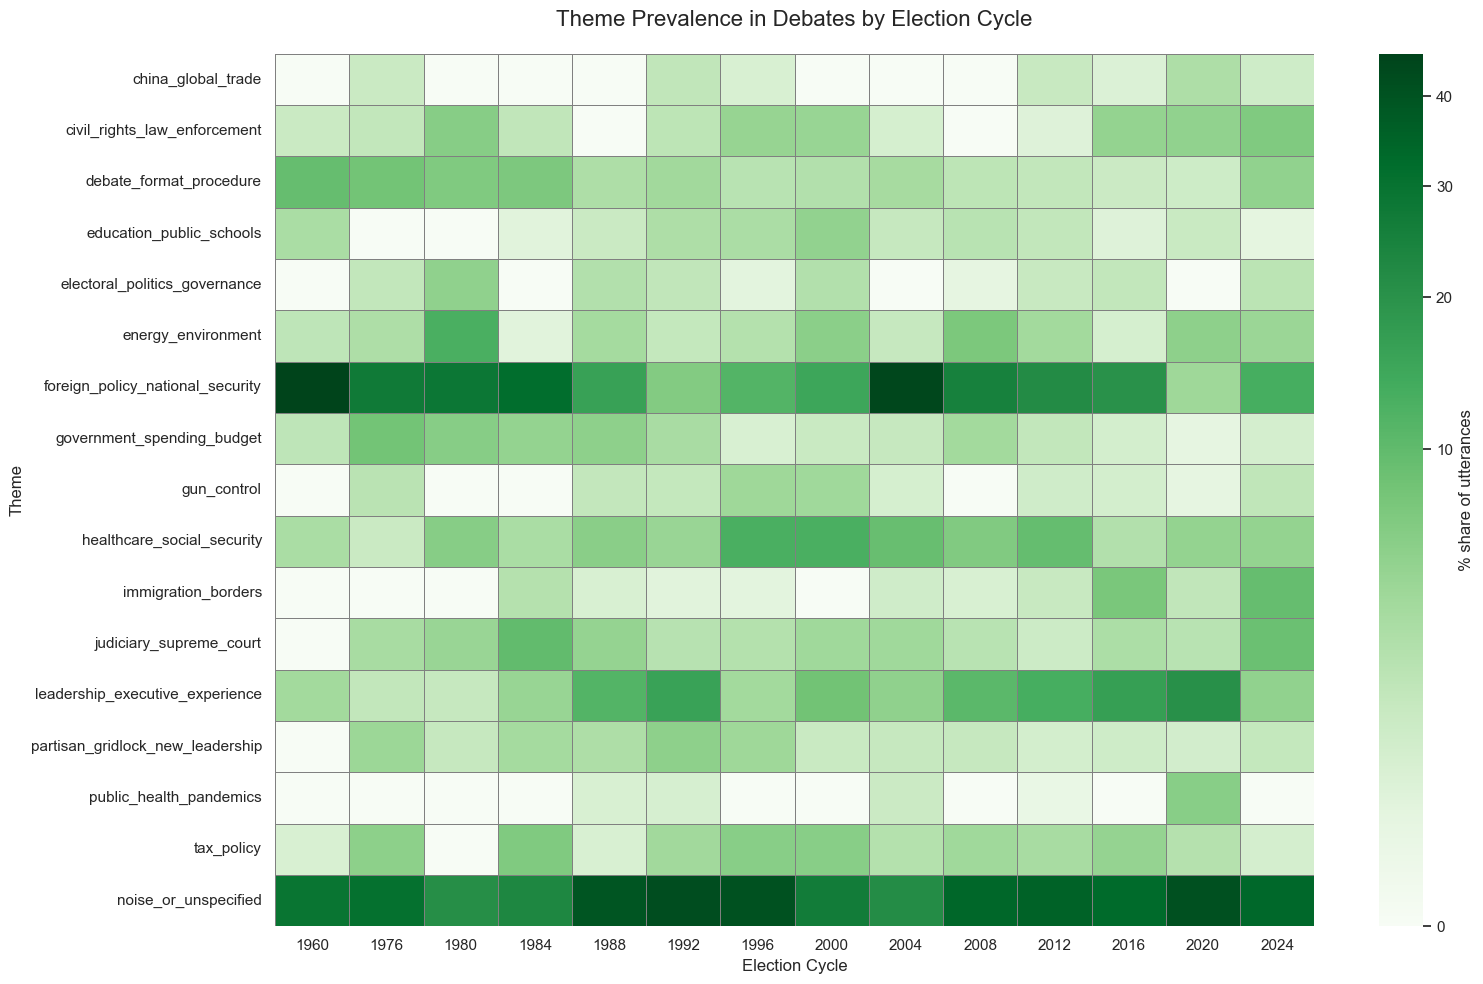

In [314]:
# === THEME PREVALENCE HEATMAP (IMPROVED) ===

from matplotlib.colors import PowerNorm

# aggregate theme % per election cycle
theme_cycle = (
    debates.groupby(["year", "theme"])
    .size()
    .reset_index(name="count")
)
cycle_totals = theme_cycle.groupby("year")["count"].transform("sum")
theme_cycle["pct"] = theme_cycle["count"] / cycle_totals * 100

# pivot for heatmap
heatmap_data = theme_cycle.pivot(index="theme", columns="year", values="pct").fillna(0)

# move noise_or_unspecified to bottom
if "noise_or_unspecified" in heatmap_data.index:
    noise_row = heatmap_data.loc[["noise_or_unspecified"]]
    heatmap_data = heatmap_data.drop("noise_or_unspecified")
    heatmap_data = pd.concat([heatmap_data, noise_row])

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap="Greens",
    linewidths=0.5, linecolor="gray",
    norm=PowerNorm(gamma=0.4),  # boost lower values for better contrast
    cbar_kws={"label": "% share of utterances"},
)

plt.title("Theme Prevalence in Debates by Election Cycle", fontsize=16, pad=20)
plt.xlabel("Election Cycle")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

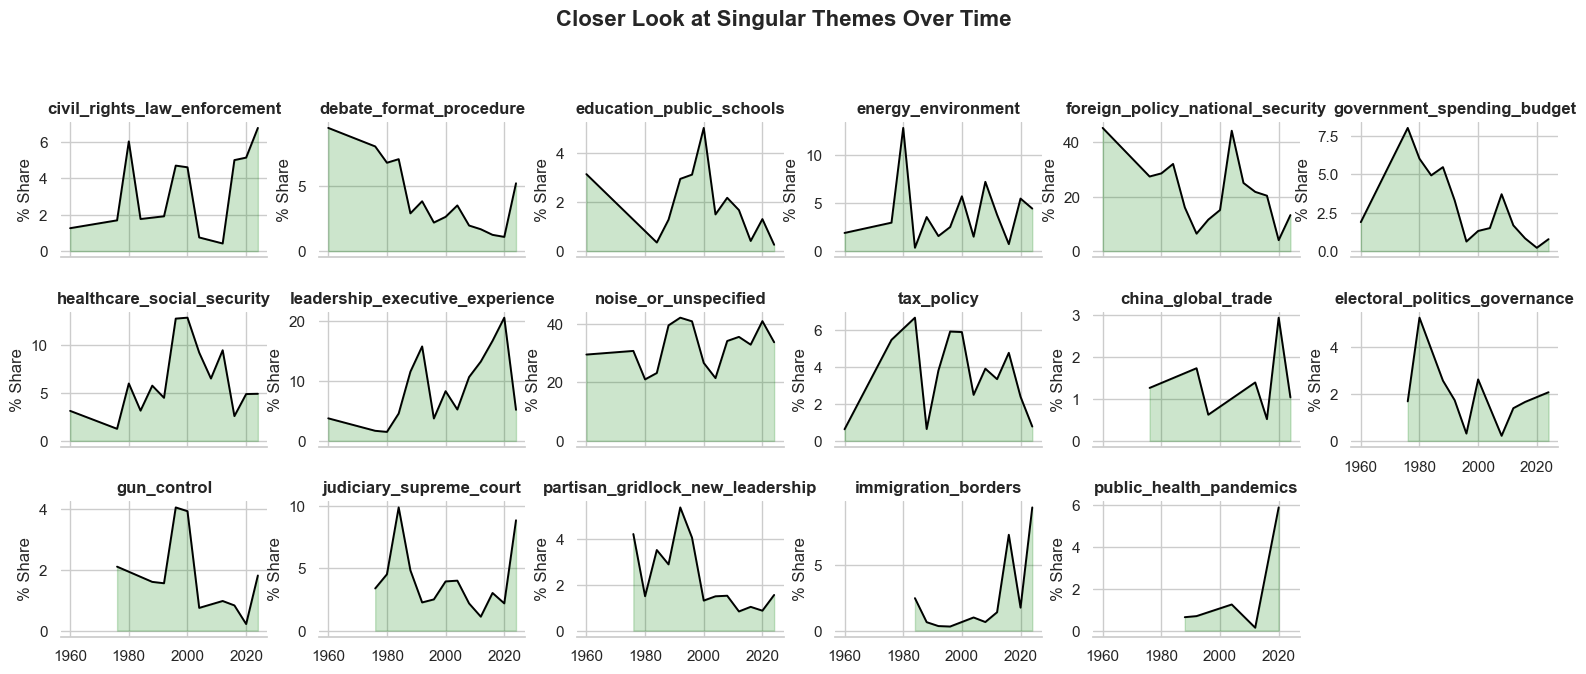

In [315]:
# === SMALL MULTIPLES GRID FOR THEMES ===

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# grid: 6 columns, themes wrap into rows
g = sns.FacetGrid(
    theme_cycle, 
    col="theme", 
    col_wrap=6,     # 6 per row
    aspect=1.2, height=2.2,  # square-ish plots
    sharey=False
)

# line + fill
g.map_dataframe(
    sns.lineplot, 
    x="year", y="pct", 
    color="black", linewidth=1.4
)
g.map_dataframe(
    plt.fill_between, 
    "year", "pct", 
    alpha=0.2, color="green"
)

# style adjustments
g.set_titles("{col_name}", fontsize=10, fontweight="bold")
g.set(xlabel="", ylabel="% Share")
g.set(xticks=[1960, 1980, 2000, 2020]) 
g.despine(left=True)

# add global title
g.fig.suptitle(
    "Closer Look at Singular Themes Over Time",
    fontsize=16, fontweight="bold",
    y=1.05
)

plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.25)  # center & spacing
plt.show()

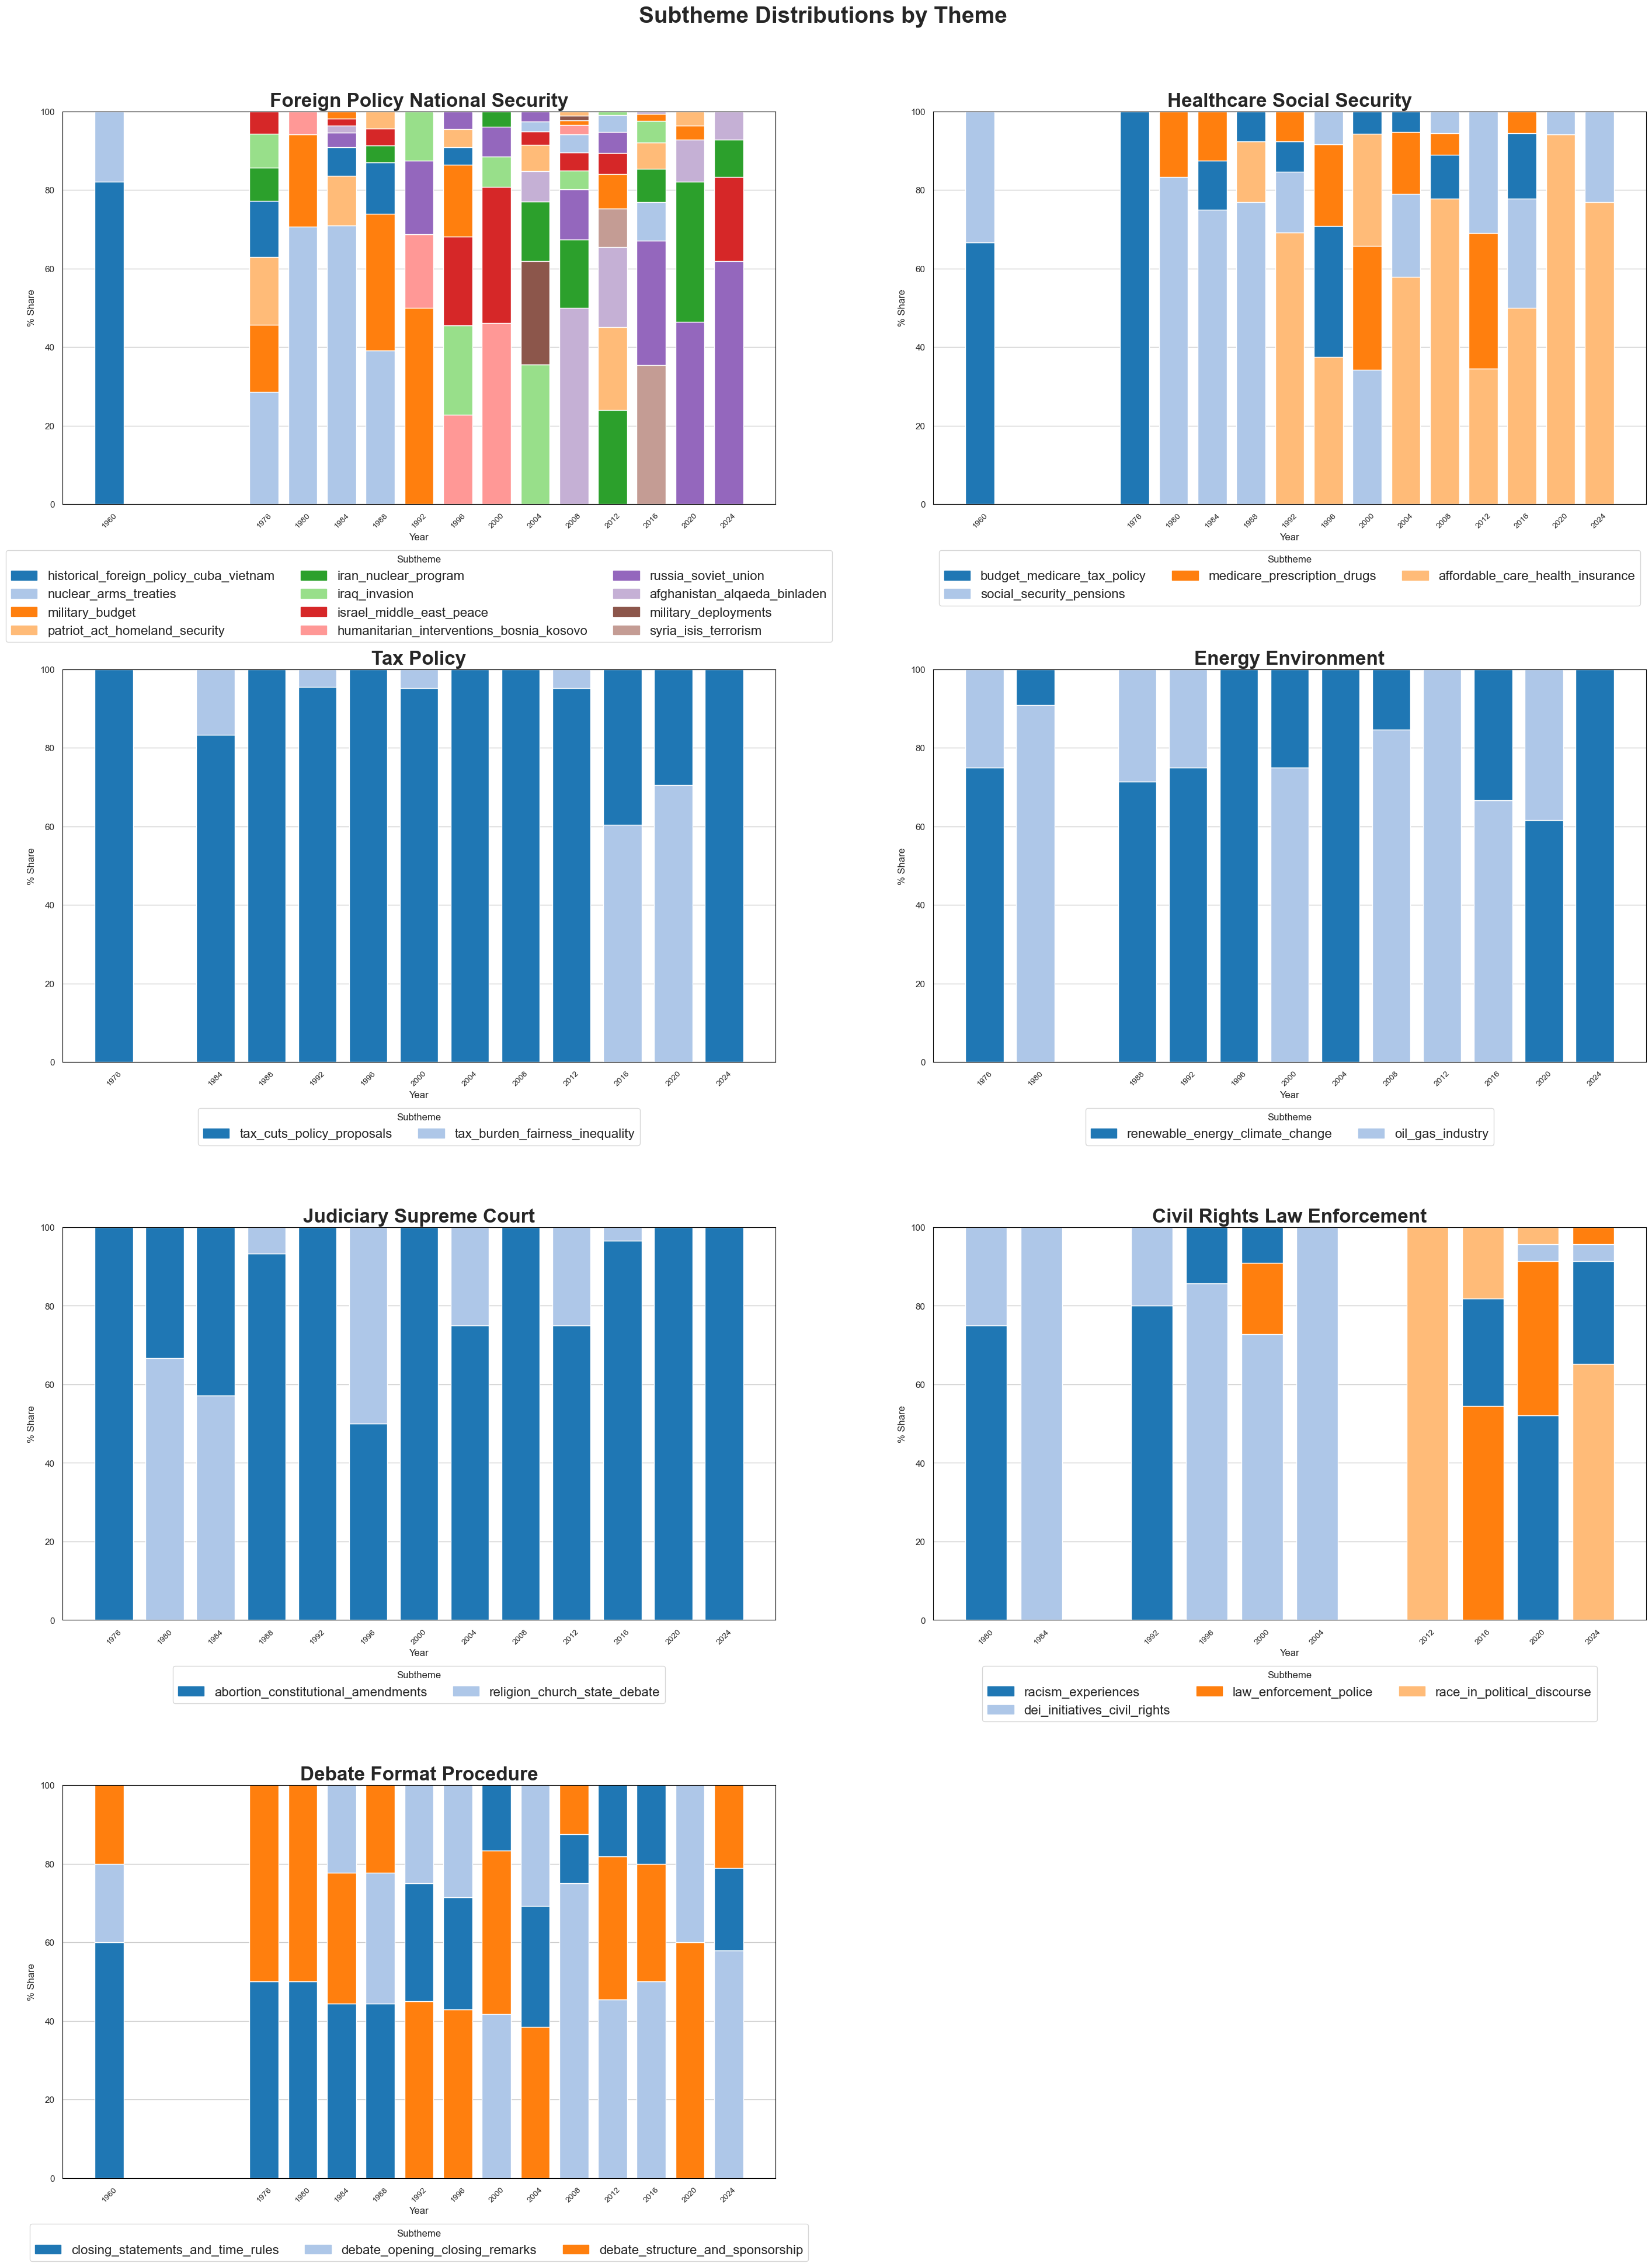

In [317]:
# === SUBTHEME DISTRIBUTION GRID: 7 THEMES ===

themes_to_plot = [
    "foreign_policy_national_security",
    "healthcare_social_security",
    "tax_policy",
    "energy_environment",
    "judiciary_supreme_court",
    "civil_rights_law_enforcement",
    "debate_format_procedure"
]

# setup grid: 3 per row
n_cols = 2
n_rows = (len(themes_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 38))
axes = axes.flatten()

for idx, theme in enumerate(themes_to_plot):
    ax = axes[idx]

    # prepare data for this theme
    df_theme = (
        debates[debates["theme"] == theme]
        .copy()
        .groupby(["year", "subtheme"])
        .size()
        .reset_index(name="count")
    )
    df_theme["subtheme"] = df_theme["subtheme"].fillna("Unassigned")
    df_theme["total"] = df_theme.groupby("year")["count"].transform("sum")
    df_theme["pct"] = df_theme["count"] / df_theme["total"] * 100
    df_theme = df_theme.sort_values(["year","pct"], ascending=[True, False])

    years = sorted(df_theme["year"].unique())
    subthemes = df_theme["subtheme"].unique()

    palette = sns.color_palette("tab20", n_colors=len(subthemes))
    color_map = {sub: palette[i] for i, sub in enumerate(subthemes)}

    # plot stacked bars
    for year in years:
        year_data = df_theme[df_theme["year"] == year]
        bottom = 0
        for _, row in year_data.iterrows():
            ax.bar(
                year, row["pct"],
                bottom=bottom,
                color=color_map[row["subtheme"]],
                edgecolor="white", width=3
            )
            bottom += row["pct"]

    # titles & axes
    ax.set_title(theme.replace("_"," ").title(), fontsize=24, fontweight="bold")
    ax.set_ylabel("% Share")
    ax.set_xlabel("Year")
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45, fontsize=10)
    ax.set_ylim(0, 100)

    # slim black border around each subplot
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(0.8)

    # add legend under each subplot
    handles = [plt.Rectangle((0,0),1,1, color=color_map[sub]) for sub in subthemes]
    ax.legend(
        handles, subthemes, title="Subtheme",
        bbox_to_anchor=(0.5, -0.10), loc="upper center",
        ncol=3, fontsize=16
    )

# hide empty subplot if n_rows*n_cols > themes
for j in range(len(themes_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Subtheme Distributions by Theme", fontsize=28, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [318]:
# === ALLUVIAL FLOW: THEMES → SUBTHEMES ===

import plotly.graph_objects as go

# aggregate data
df_alluvial = (
    debates.groupby(["theme", "subtheme"])
    .size()
    .reset_index(name="count")
)

# filter out NaN subthemes
df_alluvial = df_alluvial[df_alluvial["subtheme"].notna()]

# build node list: themes + subthemes
themes = df_alluvial["theme"].unique().tolist()
subthemes = df_alluvial["subtheme"].unique().tolist()
nodes = themes + subthemes

# mapping theme/subtheme to indices
node_index = {n: i for i, n in enumerate(nodes)}

# links: theme → subtheme
links = []
for _, row in df_alluvial.iterrows():
    links.append(dict(
        source=node_index[row["theme"]],
        target=node_index[row["subtheme"]],
        value=row["count"]
    ))

# Sankey figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=40,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightgreen"
    ),
    link=dict(
        source=[l["source"] for l in links],
        target=[l["target"] for l in links],
        value=[l["value"] for l in links],
        color="rgba(34,139,34,0.4)"   # semi-transparent green
    )
)])

fig.update_layout(
    title_text="Alluvial Flow of Debate Themes and Subthemes",
    font_size=12
)

fig.show()

### 1.2. Partisan Differences in Themes

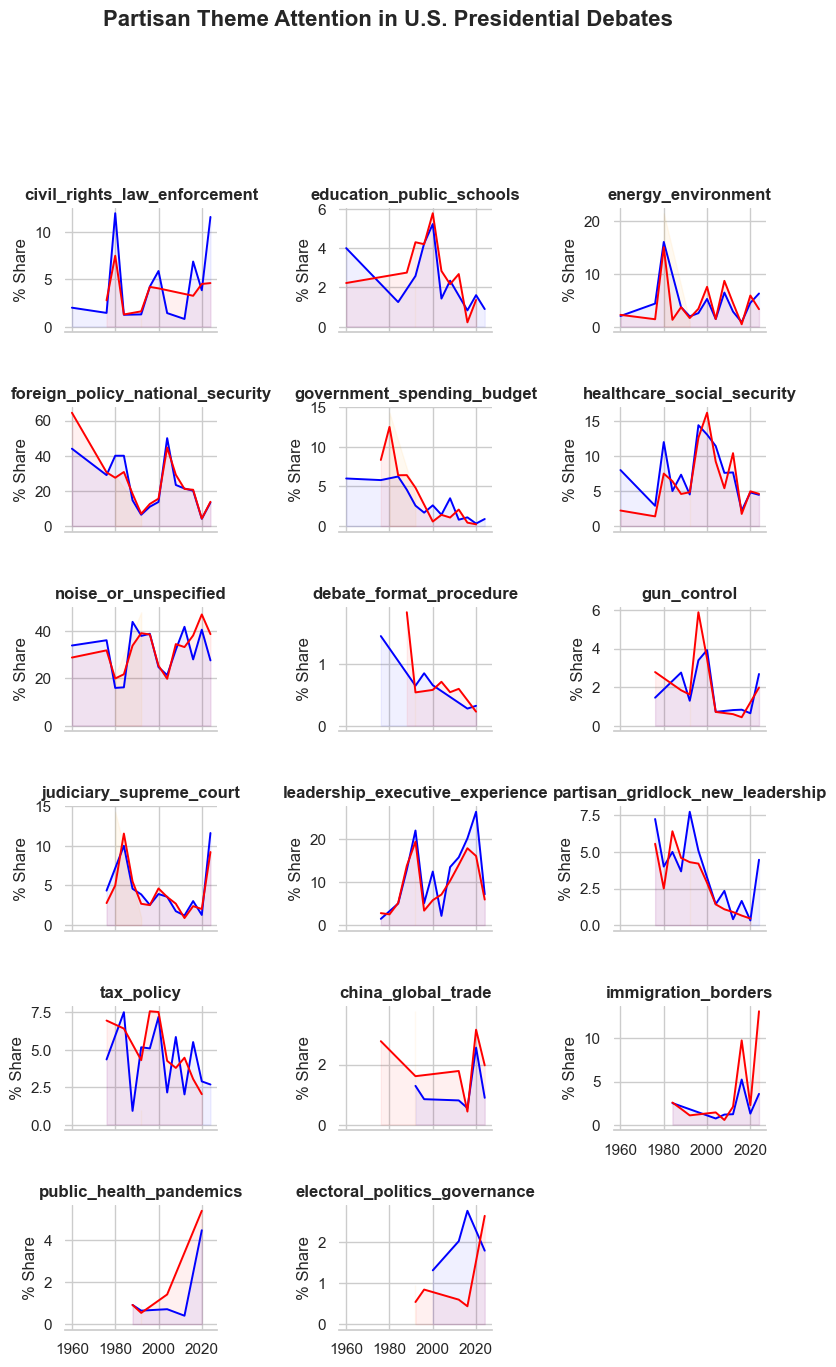

In [319]:
# === SMALL MULTIPLES GRID FOR THEMES (PARTISAN) ===

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# aggregate theme % per year × party
party_theme = (
    debates.groupby(["year", "party_code", "theme"])
    .size()
    .reset_index(name="count")
)
party_totals = party_theme.groupby(["year", "party_code"])["count"].transform("sum")
party_theme["pct"] = party_theme["count"] / party_totals * 100

# Facet grid: one subplot per theme
g = sns.FacetGrid(
    party_theme, 
    col="theme", 
    col_wrap=3, 
    aspect=1.2, height=2.2, 
    sharey=False
)

# Democrat line + fill
g.map_dataframe(
    sns.lineplot, 
    x="year", y="pct", hue="party_code",
    hue_order=["D", "R"],  # ensure consistent ordering
    palette={"D": "blue", "R": "red"},
    linewidth=1.4
)

# fill areas under curves
def partisan_fill(data, color_map={"D":"blue","R":"red","I":"orange"}, alpha=0.06, **kwargs):
    ax = plt.gca()
    for party, group in data.groupby("party_code"):
        if party in color_map:
            ax.fill_between(group["year"], group["pct"], alpha=alpha, color=color_map[party])

party_theme = party_theme[party_theme["party_code"].isin(["D","R"])]

g.map_dataframe(partisan_fill)

# style
g.set_titles("{col_name}", fontsize=5, fontweight="bold")
g.set(xlabel="", ylabel="% Share")
g.set(xticks=[1960, 1980, 2000, 2020])
g.despine(left=True)

# global title
g.fig.suptitle(
    "Partisan Theme Attention in U.S. Presidential Debates",
    fontsize=16, fontweight="bold",
    y=1.05
)

plt.subplots_adjust(top=0.9, hspace=0.6, wspace=0.8)
plt.show()

In [320]:
# === ADD DECADE COLUMN ===

debates["decade"] = (debates["year"] // 10 * 10).astype(str) + "s"

/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_75741/1080562068.py:64: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



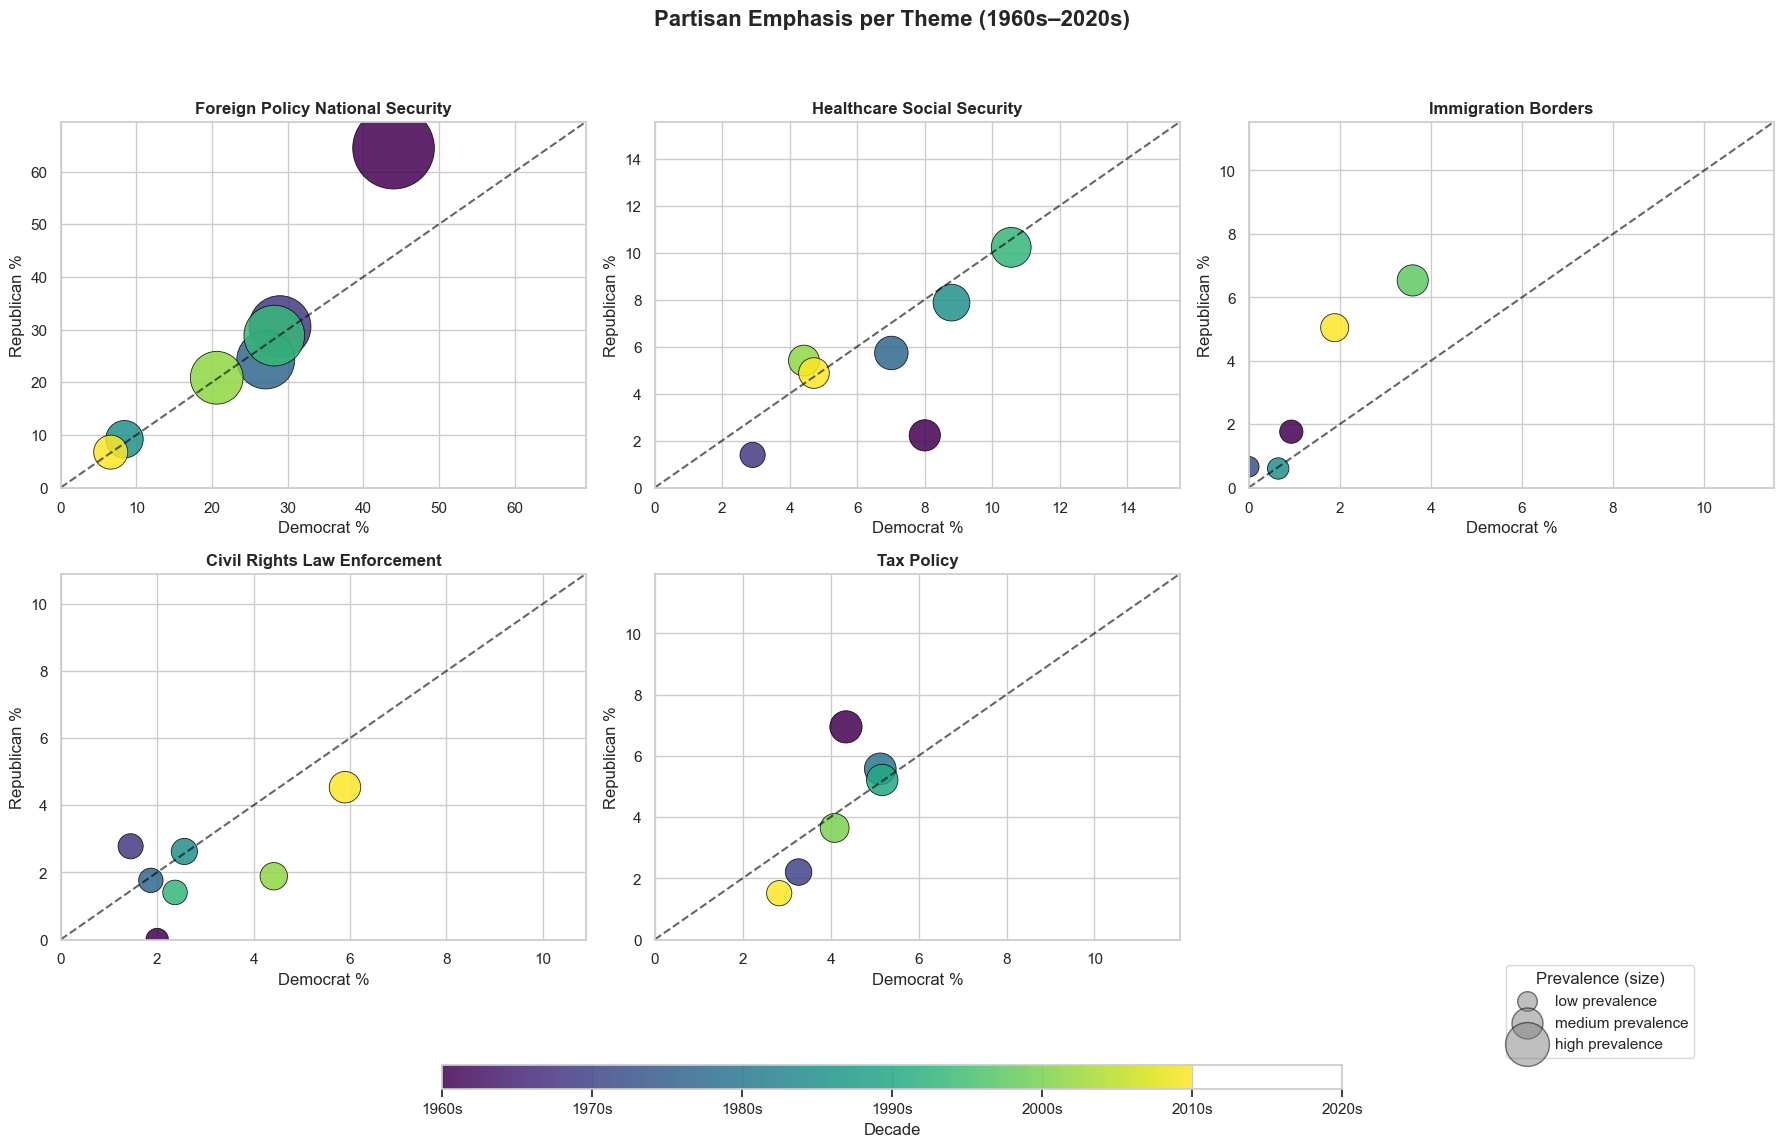

In [322]:
# === PARTISAN EMPHASIS PER THEME (BIGGER POINTS + EXPLICIT LEGENDS) ===

themes_to_plot = [
    "foreign_policy_national_security",
    "healthcare_social_security",
    "immigration_borders",
    "civil_rights_law_enforcement",
    "tax_policy"
]

n_cols = 3
n_rows = (len(themes_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()

for i, theme in enumerate(themes_to_plot):
    ax = axes[i]
    data = pivot[pivot["theme"] == theme]

    # scatter with larger sizes
    sc = ax.scatter(
        data["D"], data["R"],
        c=data["decade"].astype("category").cat.codes,
        cmap="viridis",
        s=data["prevalence"]*30 + 200,  # much larger
        alpha=0.85, edgecolor="black", linewidth=0.6
    )

    # diagonal
    lims = [0, max(data["D"].max(), data["R"].max()) + 5]
    ax.plot(lims, lims, '--', color="black", alpha=0.6)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_title(theme.replace("_"," ").title(), fontsize=12, fontweight="bold")
    ax.set_xlabel("Democrat %")
    ax.set_ylabel("Republican %")

# remove empty subplot
for j in range(len(themes_to_plot), len(axes)):
    fig.delaxes(axes[j])

# colorbar for decades
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Decade")
cbar.set_ticks(range(len(pivot["decade"].unique())))
cbar.set_ticklabels(sorted(pivot["decade"].unique()))

# size legend for prevalence
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

handles = [
    plt.scatter([], [], s=200, color="gray", alpha=0.5, edgecolor="black"),
    plt.scatter([], [], s=500, color="gray", alpha=0.5, edgecolor="black"),
    plt.scatter([], [], s=1000, color="gray", alpha=0.5, edgecolor="black"),
]
labels = ["low prevalence", "medium prevalence", "high prevalence"]
fig.legend(handles, labels, title="Prevalence (size)", loc="lower right", bbox_to_anchor=(0.95, 0.1))

plt.suptitle("Partisan Emphasis per Theme (1960s–2020s)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0,0.15,1,0.95])  # extra space for legends
plt.show()

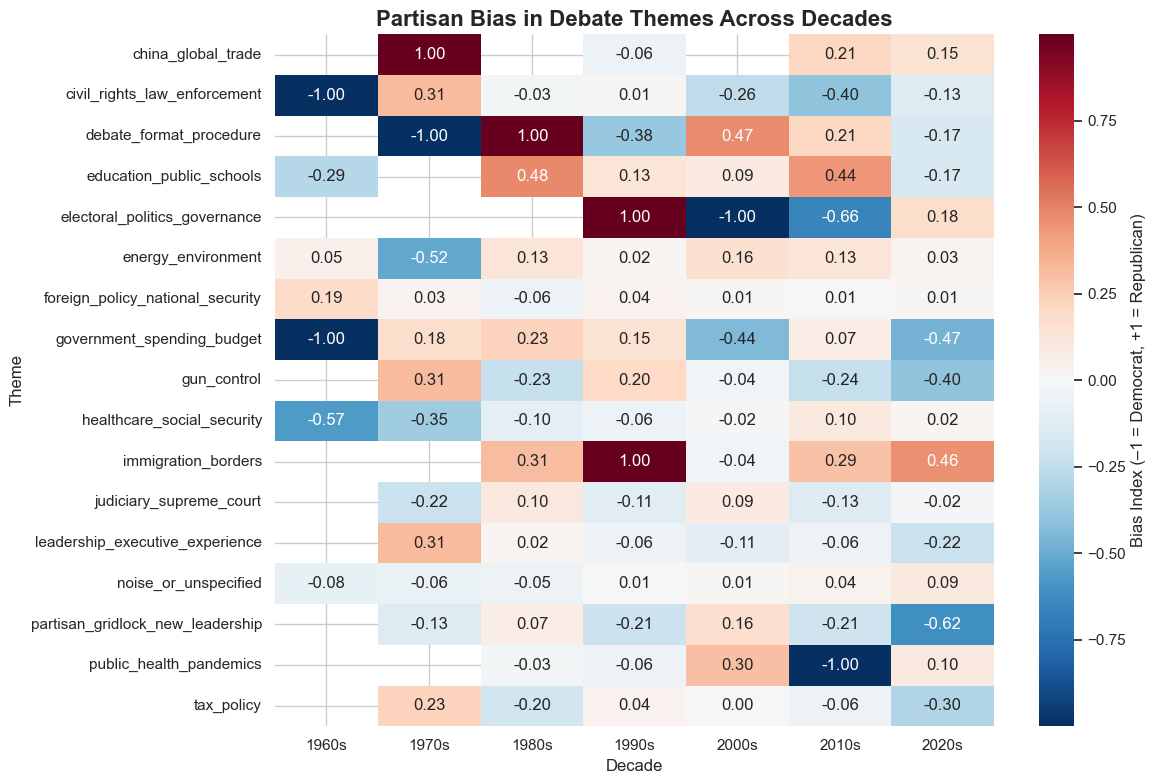

In [323]:
# === PARTISAN BIAS INDEX HEATMAP ===

# aggregate utterances
df_bias = (
    debates.groupby(["decade","party_code","theme"])
    .size()
    .reset_index(name="count")
)

# normalize within party × decade
totals = df_bias.groupby(["decade","party_code"])["count"].transform("sum")
df_bias["pct"] = df_bias["count"] / totals * 100

# pivot: Democrats vs Republicans
pivot = df_bias.pivot_table(
    index=["decade","theme"],
    columns="party_code",
    values="pct",
    fill_value=0
).reset_index()

# compute bias index
pivot["bias"] = (pivot["R"] - pivot["D"]) / (pivot["R"] + pivot["D"] + 1e-6)

# heatmap
heatmap_data = pivot.pivot(index="theme", columns="decade", values="bias")

plt.figure(figsize=(12,8))
sns.heatmap(
    heatmap_data,
    cmap="RdBu_r", center=0, annot=True, fmt=".2f",
    cbar_kws={"label":"Bias Index (–1 = Democrat, +1 = Republican)"}
)
plt.title("Partisan Bias in Debate Themes Across Decades", fontsize=16, fontweight="bold")
plt.xlabel("Decade")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

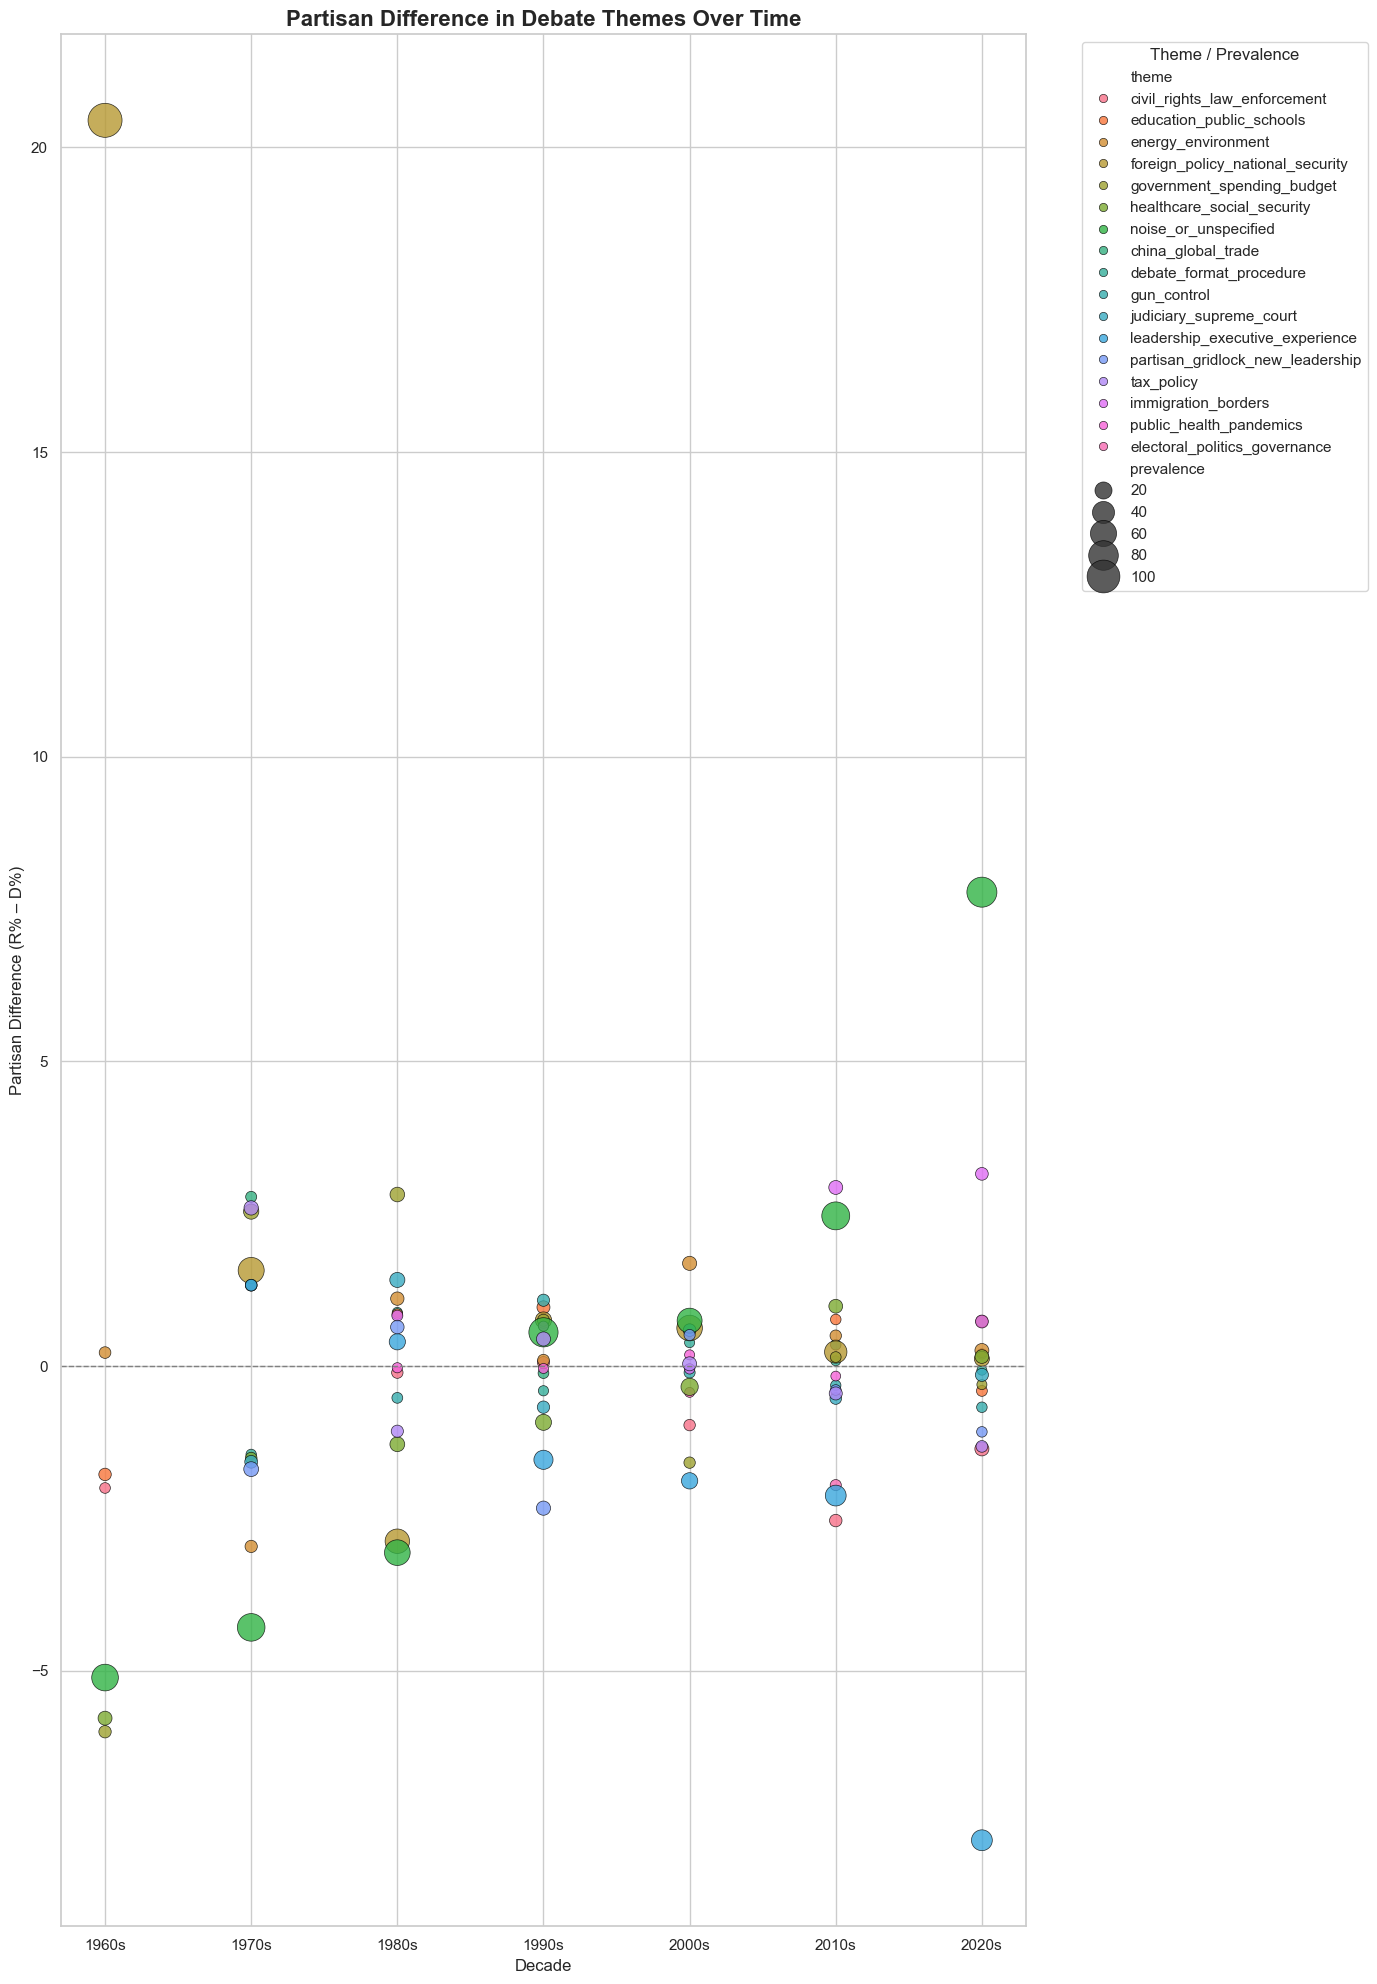

In [324]:
# === PARTISAN DIFFERENCE OVER TIME ===

import matplotlib.pyplot as plt
import seaborn as sns

# aggregate utterances
df_diff = (
    debates.groupby(["decade","party_code","theme"])
    .size()
    .reset_index(name="count")
)

# normalize within party × decade
totals = df_diff.groupby(["decade","party_code"])["count"].transform("sum")
df_diff["pct"] = df_diff["count"] / totals * 100

# pivot: Democrat vs Republican
pivot = df_diff.pivot_table(
    index=["decade","theme"],
    columns="party_code",
    values="pct",
    fill_value=0
).reset_index()

# compute partisan difference
pivot["diff"] = pivot["R"] - pivot["D"]   # positive = R-heavy, negative = D-heavy
pivot["prevalence"] = pivot["R"] + pivot["D"]

# plot
plt.figure(figsize=(14,20))
sns.scatterplot(
    data=pivot,
    x="decade", y="diff",
    size="prevalence", hue="theme",
    sizes=(50, 600), alpha=0.8, edgecolor="black", linewidth=0.5
)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Partisan Difference in Debate Themes Over Time", fontsize=16, fontweight="bold")
plt.ylabel("Partisan Difference (R% – D%)")
plt.xlabel("Decade")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Theme / Prevalence")
plt.tight_layout()
plt.show()

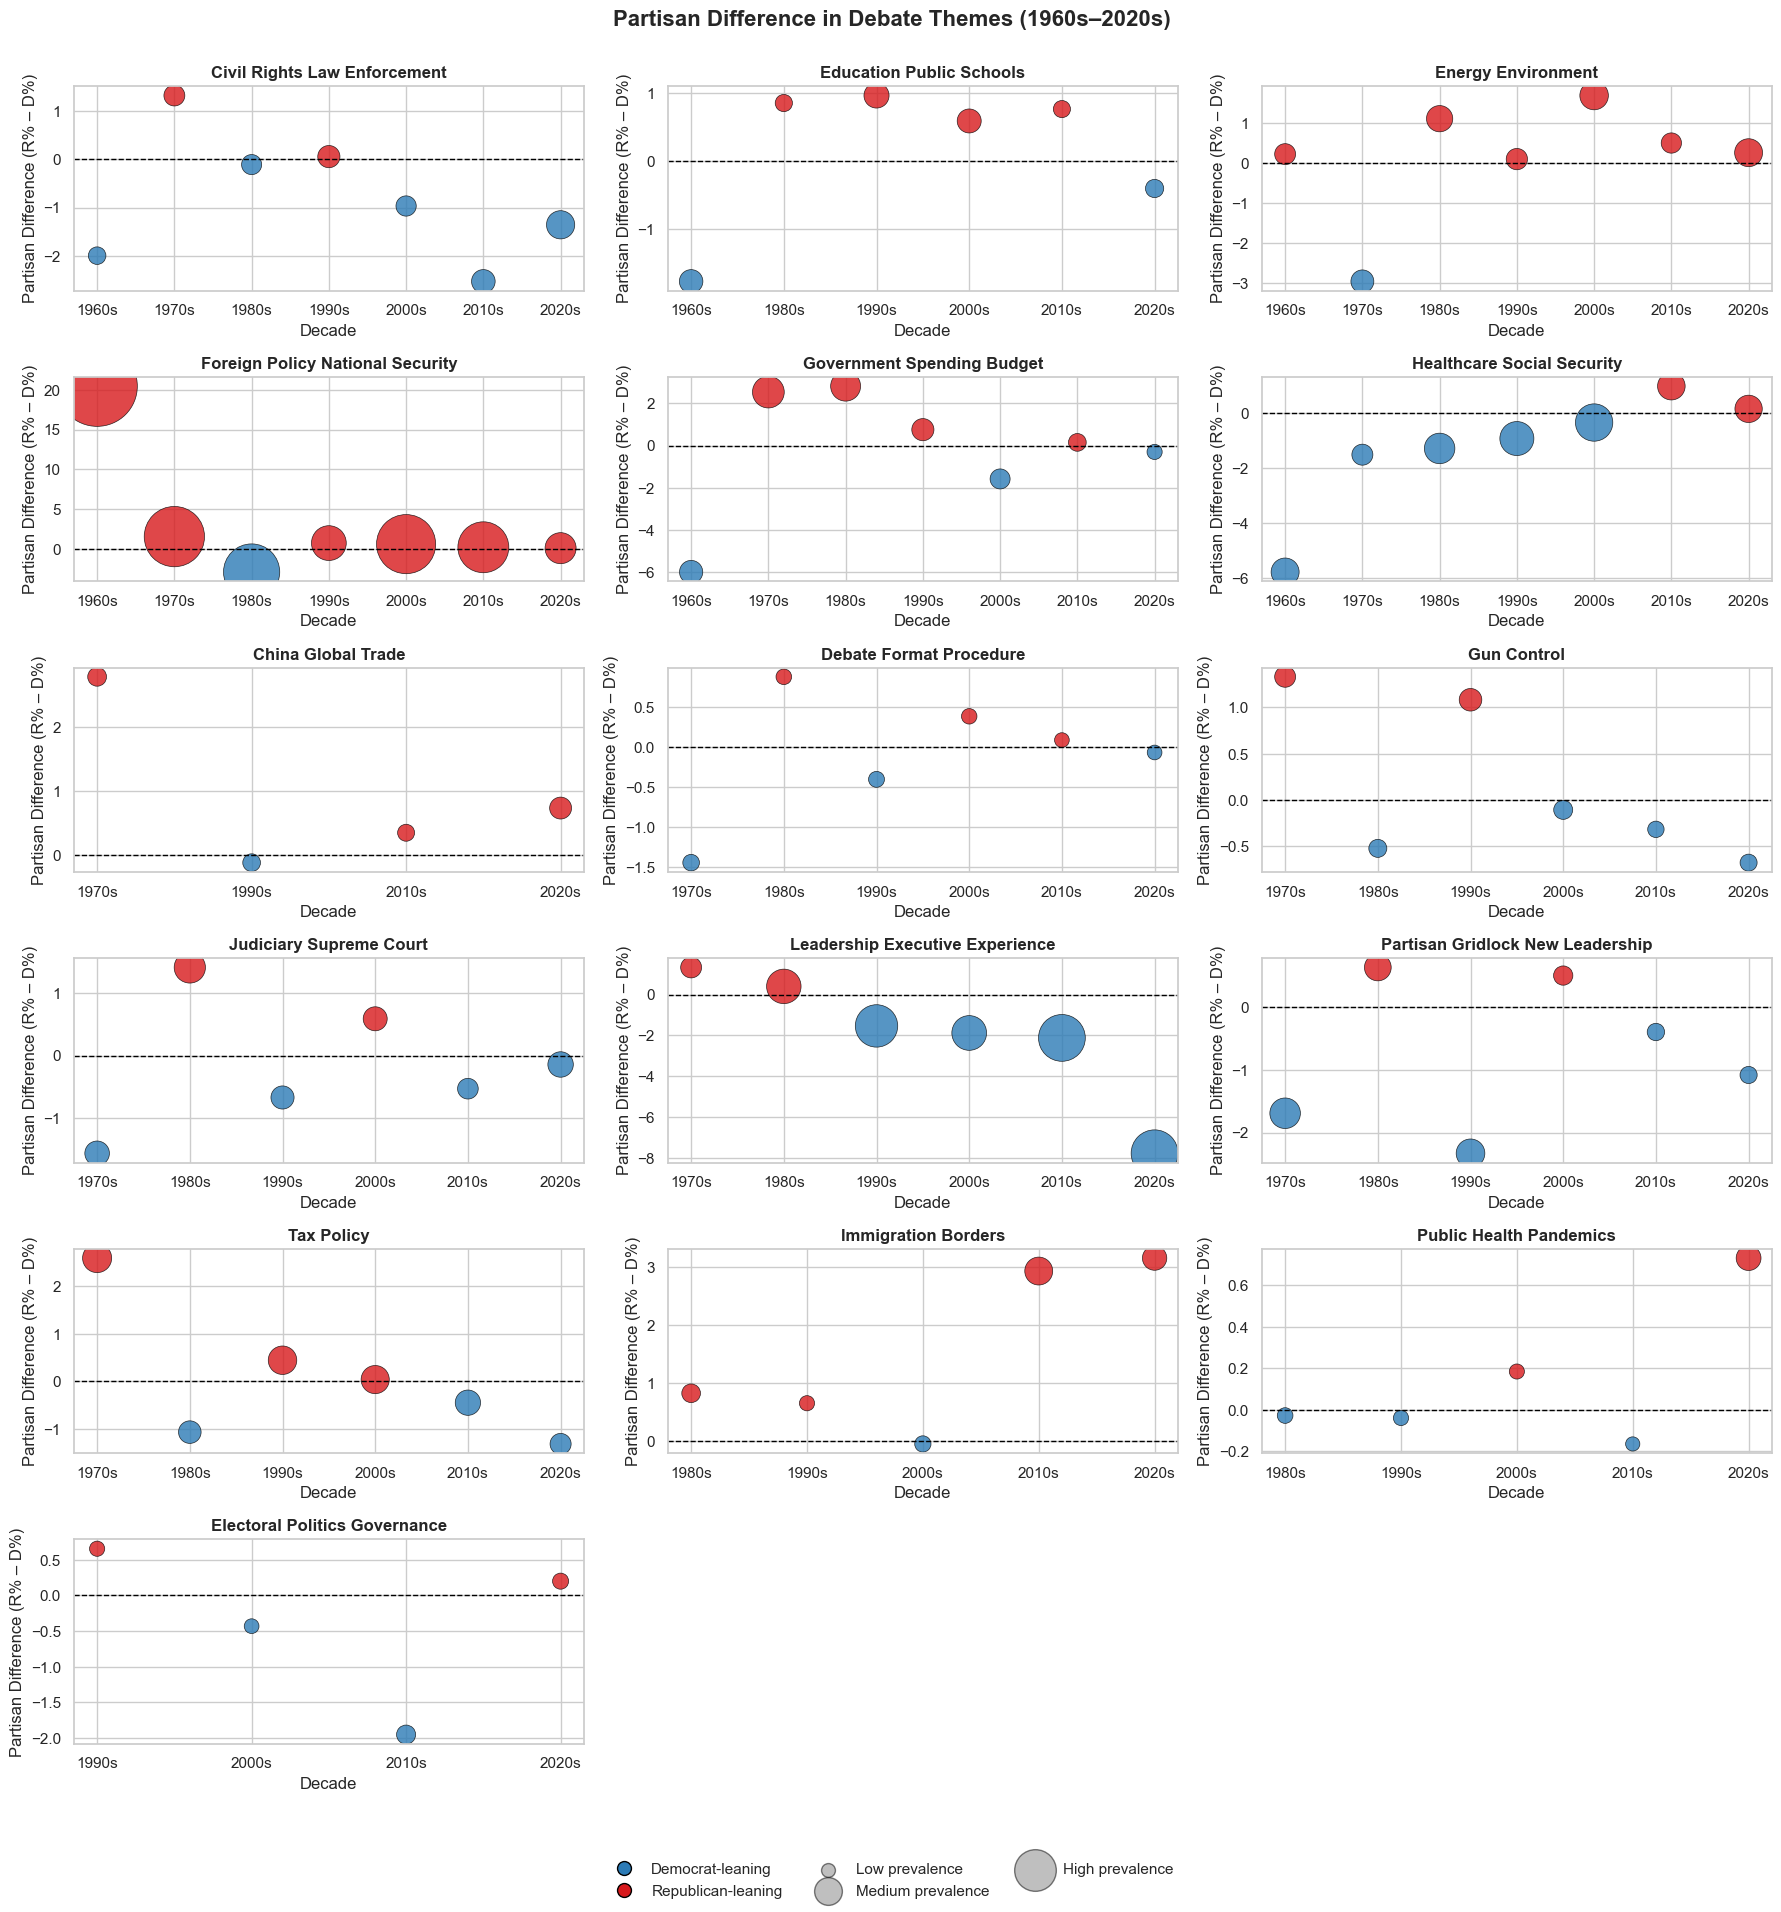

In [326]:
# === PARTISAN DIFFERENCE BY THEME (FACETED) ===

themes_to_plot = [t for t in pivot["theme"].unique() if t != "noise_or_unspecified"]

n_cols = 3
n_rows = (len(themes_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))
axes = axes.flatten()

for i, theme in enumerate(themes_to_plot):
    ax = axes[i]
    data = pivot[pivot["theme"] == theme]

    # assign colors by partisan difference
    colors = data["diff"].apply(lambda x: "#D7191C" if x > 0 else "#2C7BB6")

    # scatter
    sc = ax.scatter(
        data["decade"], data["diff"],
        s=data["prevalence"]*30 + 100,  # bigger baseline
        c=colors, alpha=0.8, edgecolor="black", linewidth=0.5
    )

    # zero line
    ax.axhline(0, color="black", linestyle="--", linewidth=1)

    ax.set_title(theme.replace("_"," ").title(), fontsize=12, fontweight="bold")
    ax.set_xlabel("Decade")
    ax.set_ylabel("Partisan Difference (R% – D%)")

# remove empty subplots
for j in range(len(themes_to_plot), len(axes)):
    fig.delaxes(axes[j])

# shared prevalence legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='Democrat-leaning',
           markerfacecolor="#2C7BB6", markersize=10, markeredgecolor="black"),
    Line2D([0],[0], marker='o', color='w', label='Republican-leaning',
           markerfacecolor="#D7191C", markersize=10, markeredgecolor="black"),
    plt.scatter([],[], s=100, c="gray", alpha=0.5, edgecolor="black", label="Low prevalence"),
    plt.scatter([],[], s=400, c="gray", alpha=0.5, edgecolor="black", label="Medium prevalence"),
    plt.scatter([],[], s=900, c="gray", alpha=0.5, edgecolor="black", label="High prevalence")
]
fig.legend(legend_elements, ["Democrat-leaning","Republican-leaning","Low prevalence","Medium prevalence","High prevalence"],
           loc="lower center", ncol=3, frameon=False)

plt.suptitle("Partisan Difference in Debate Themes (1960s–2020s)", fontsize=16, fontweight="bold", y=0.95)
plt.tight_layout(rect=[0,0.05,1,0.95])  # leave space for legend at bottom
plt.show()

### 1.3. Media Alignment

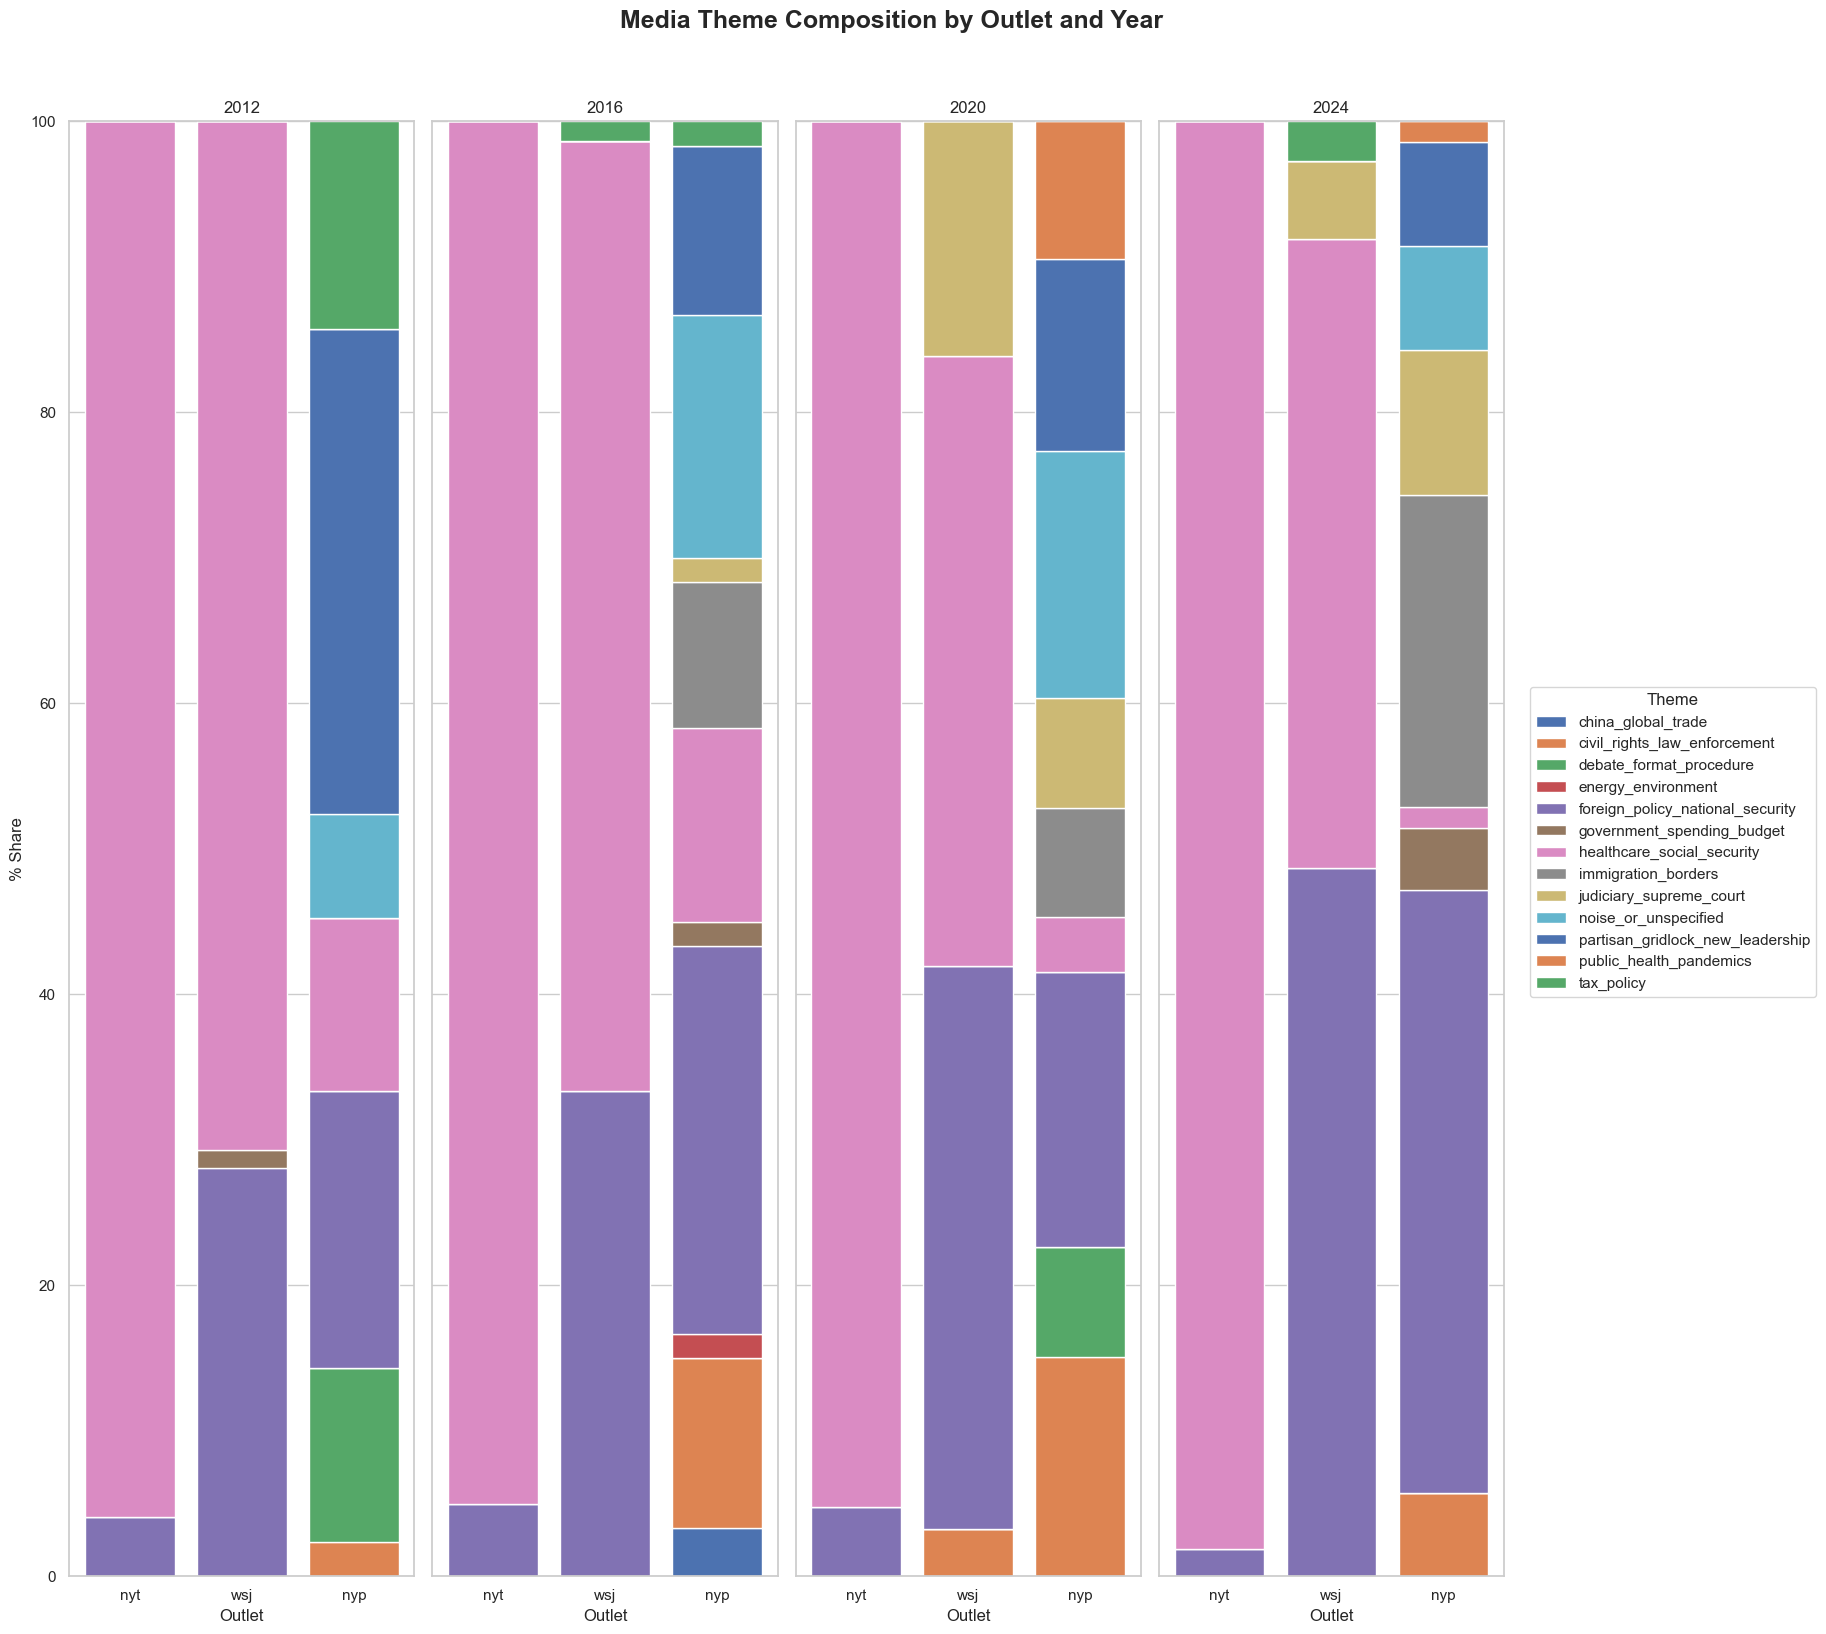

In [327]:
# === STACKED BAR CHARTS: MEDIA THEME COMPOSITION ACROSS OUTLETS AND ELECTION CYCLES ===

# prepare stacked bar data 
media_cycle = (
    media.groupby(["year", "outlet", "theme"])
    .size()
    .reset_index(name="count")
)
outlet_totals = media_cycle.groupby(["year", "outlet"])["count"].transform("sum")
media_cycle["pct"] = media_cycle["count"] / outlet_totals * 100

# pivot for stacked bars
bar_data = media_cycle.pivot_table(
    index=["year","outlet"], columns="theme", values="pct", fill_value=0
)

# plot stacked bars
outlets_order = ["nyt","wsj","nyp"]  # control outlet order
years = sorted(media_cycle["year"].unique())

fig, axes = plt.subplots(1, len(years), figsize=(18, 16), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    subset = bar_data.loc[year]
    subset = subset.reindex(outlets_order)  # ensure consistent order
    
    # plot stacked bars
    bottom = np.zeros(len(subset))
    for theme in subset.columns:
        ax.bar(
            subset.index, subset[theme], bottom=bottom, label=theme
        )
        bottom += subset[theme].values
    
    ax.set_title(str(year))
    ax.set_xlabel("Outlet")
    if i == 0:
        ax.set_ylabel("% Share")
    ax.set_ylim(0, 100)

# single legend outside
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Theme", bbox_to_anchor=(0.85, 0.5), loc="center left")

plt.suptitle("Media Theme Composition by Outlet and Year", fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

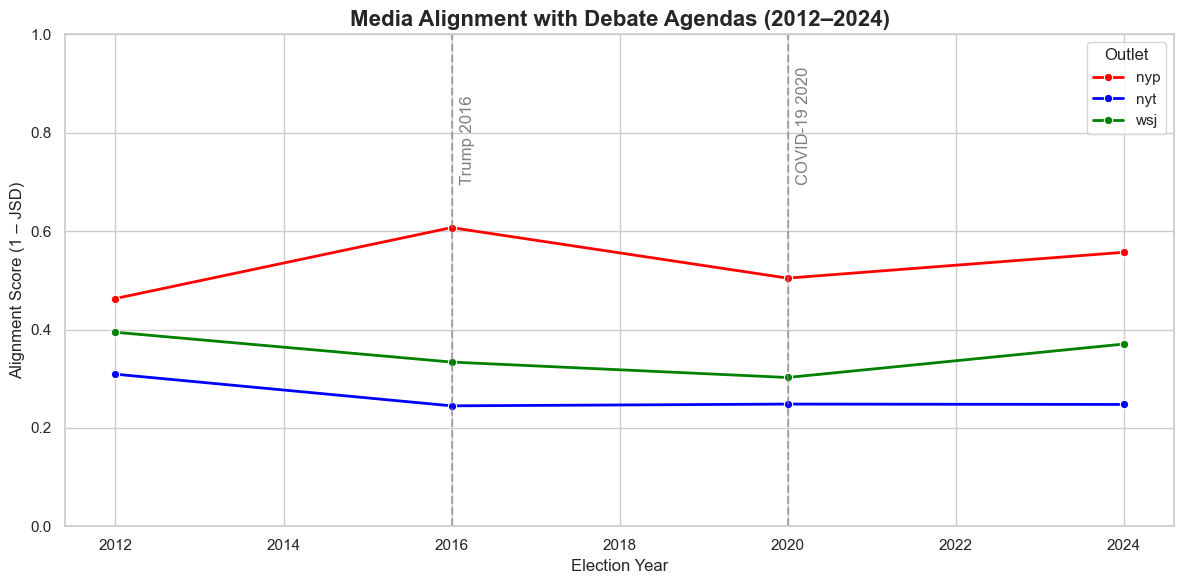

In [328]:
# === DIVERGENCE INDEX (JSD) ===

from scipy.spatial.distance import jensenshannon

def compute_jsd(p, q):
    """Compute Jensen–Shannon divergence between two distributions."""
    return jensenshannon(p, q)

divergences = []
for year in media_cycle["year"].unique():
    debates_dist = (
        debates[debates["year"] == year]
        .groupby("theme").size()
        .pipe(lambda s: s / s.sum())
    )
    for outlet in media_cycle["outlet"].unique():
        media_dist = (
            media[(media["year"] == year) & (media["outlet"] == outlet)]
            .groupby("theme").size()
            .pipe(lambda s: s / s.sum())
        )
        aligned = debates_dist.align(media_dist, fill_value=0)
        jsd = compute_jsd(aligned[0], aligned[1])
        divergences.append({"year": year, "outlet": outlet, "jsd": jsd})

div_df = pd.DataFrame(divergences)   # 👈 this is div_df

# === Convert JSD to alignment score ===
div_df["alignment"] = 1 - div_df["jsd"]

# set outlet colors
outlet_colors = {"nyt": "blue", "wsj": "green", "nyp": "red"}

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=div_df,
    x="year", y="alignment", hue="outlet",
    palette=outlet_colors, marker="o", linewidth=2
)

# add event annotations
plt.axvline(2016, color="gray", linestyle="--", alpha=0.6)
plt.text(2016.1, 0.7, "Trump 2016", rotation=90, color="gray")

plt.axvline(2020, color="gray", linestyle="--", alpha=0.6)
plt.text(2020.1, 0.7, "COVID-19 2020", rotation=90, color="gray")

# labels & title
plt.title("Media Alignment with Debate Agendas (2012–2024)", fontsize=16, fontweight="bold")
plt.ylabel("Alignment Score (1 – JSD)")
plt.xlabel("Election Year")
plt.ylim(0, 1)  # alignment score between 0–1
plt.legend(title="Outlet")

plt.tight_layout()
plt.show()

## 2. Do Politicians and Media Outlets Practice Emotional Coloring?

### 2.1. How Does Sentiment Change Over the Decades?

In [329]:
# === HELPERS: SHARE OF A SENTIMENT BY PARTY-YEAR ===

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

party_palette = {"D": "#2C7BB6", "R": "#D7191C", "I": "#FDAE61"}

def sentiment_share(df, sentiment):
    # total utterances per year × party (denominator)
    totals = (
        df.groupby(["year", "party_code"])
          .size()
          .reset_index(name="total")
    )
    # numerator: utterances with the chosen sentiment per year × party
    numer = (
        df[df["sentiment"] == sentiment]
        .groupby(["year", "party_code"])
        .size()
        .reset_index(name="count")
    )
    # merge and compute %
    out = totals.merge(numer, on=["year", "party_code"], how="left")
    out["count"] = out["count"].fillna(0)
    out["pct"] = out["count"] / out["total"] * 100
    return out.sort_values(["party_code", "year"])

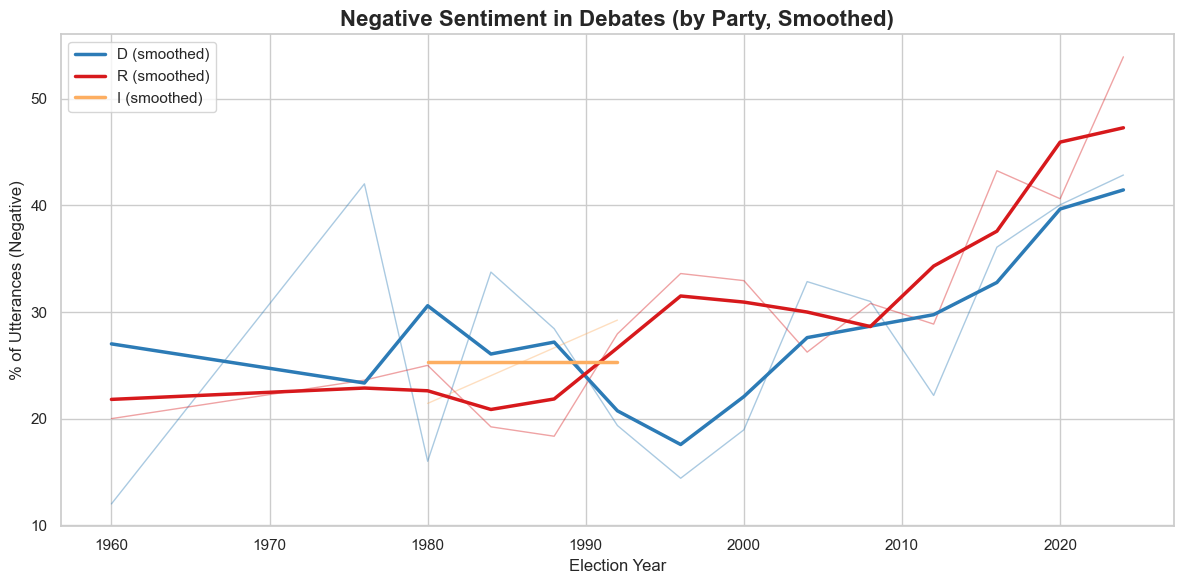

In [330]:
# === LINE PLOT: NEGATIVE SENTIMENT OVER TIME (BY PARTY, SMOOTHED + LIGHT RAW) ===

neg_line = sentiment_share(debates, "negative")

plt.figure(figsize=(12,6))

# raw noisy lines (lighter)
sns.lineplot(
    data=neg_line,
    x="year", y="pct",
    hue="party_code", palette=party_palette,
    linewidth=1, alpha=0.4, legend=False
)

# smoothed bold lines
for party, color in party_palette.items():
    party_data = neg_line[neg_line["party_code"] == party].sort_values("year")
    party_data["smoothed"] = (
        party_data["pct"].rolling(3, center=True, min_periods=1).mean()
    )
    plt.plot(
        party_data["year"], party_data["smoothed"],
        color=color, linewidth=2.5, label=f"{party} (smoothed)"
    )

plt.title("Negative Sentiment in Debates (by Party, Smoothed)", fontsize=16, fontweight="bold")
plt.ylabel("% of Utterances (Negative)")
plt.xlabel("Election Year")
plt.legend()
plt.tight_layout()
plt.show()

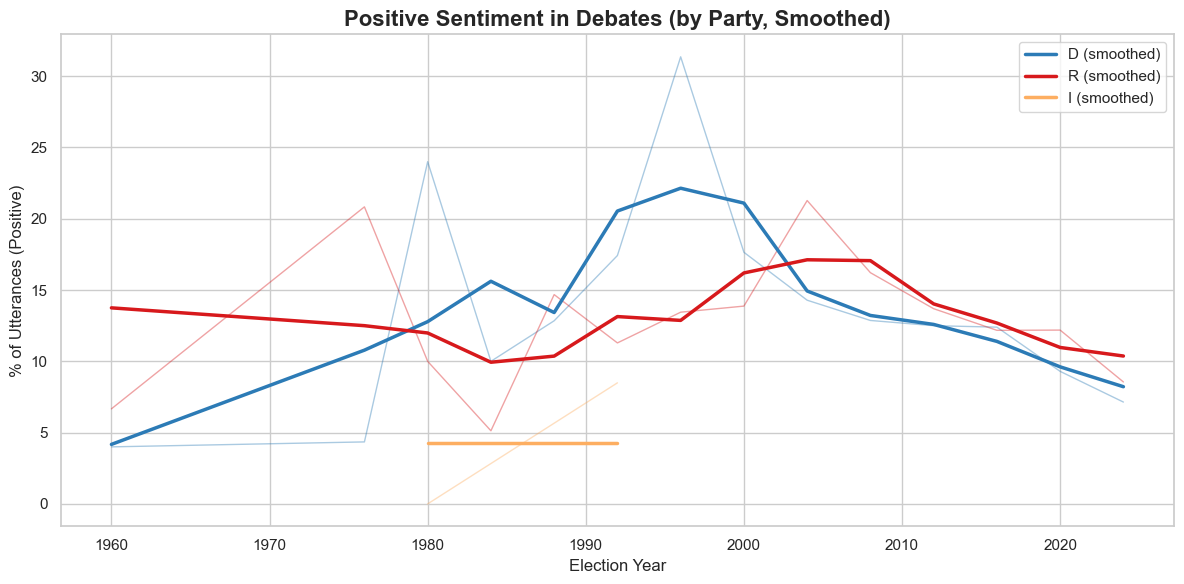

In [331]:
# === LINE PLOT: POSITIVE SENTIMENT OVER TIME (BY PARTY, SMOOTHED + LIGHT RAW) ===

pos_line = sentiment_share(debates, "positive")

plt.figure(figsize=(12,6))

# raw noisy lines (lighter)
sns.lineplot(
    data=pos_line,
    x="year", y="pct",
    hue="party_code", palette=party_palette,
    linewidth=1, alpha=0.4, legend=False
)

# smoothed bold lines
for party, color in party_palette.items():
    party_data = pos_line[pos_line["party_code"] == party].sort_values("year")
    party_data["smoothed"] = (
        party_data["pct"].rolling(3, center=True, min_periods=1).mean()
    )
    plt.plot(
        party_data["year"], party_data["smoothed"],
        color=color, linewidth=2.5, label=f"{party} (smoothed)"
    )

plt.title("Positive Sentiment in Debates (by Party, Smoothed)", fontsize=16, fontweight="bold")
plt.ylabel("% of Utterances (Positive)")
plt.xlabel("Election Year")
plt.legend()
plt.tight_layout()
plt.show()

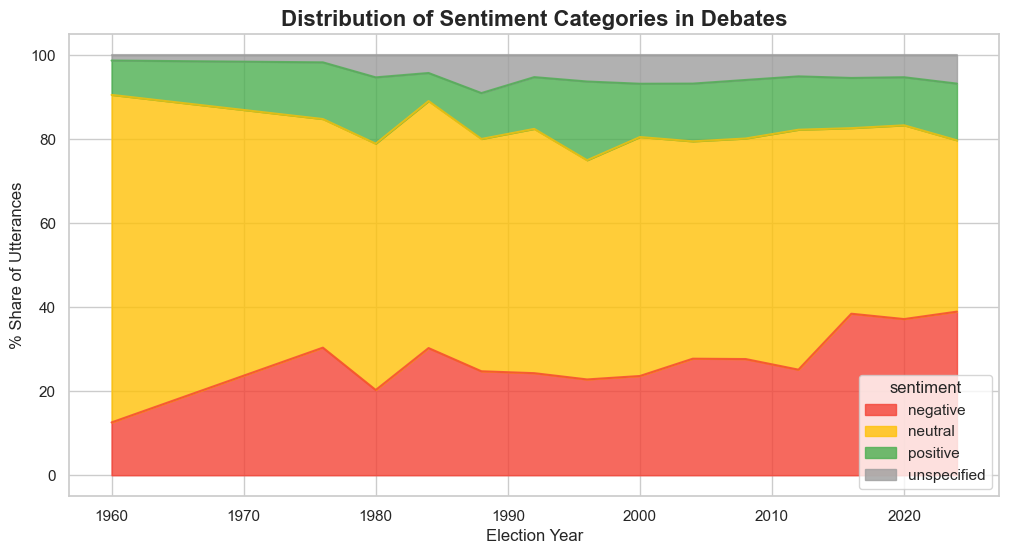

In [332]:
# === STACKED AREA: SENTIMENT DISTRIBUTION OVER TIME ===

sent_dist = (
    debates.groupby(["year","sentiment"])
    .size()
    .reset_index(name="count")
)
totals = sent_dist.groupby("year")["count"].transform("sum")
sent_dist["pct"] = sent_dist["count"] / totals * 100

sent_pivot = sent_dist.pivot(index="year", columns="sentiment", values="pct").fillna(0)

# custom sentiment colors
sentiment_palette = {
    "positive": "#4CAF50",  # green
    "neutral": "#FFC107",   # yellow
    "negative": "#F44336"   # red
}

sent_pivot.plot.area(
    figsize=(12,6), alpha=0.8,
    color=[sentiment_palette.get(col, "#9E9E9E") for col in sent_pivot.columns]
)

plt.title("Distribution of Sentiment Categories in Debates", fontsize=16, fontweight="bold")
plt.ylabel("% Share of Utterances")
plt.xlabel("Election Year")
plt.show()

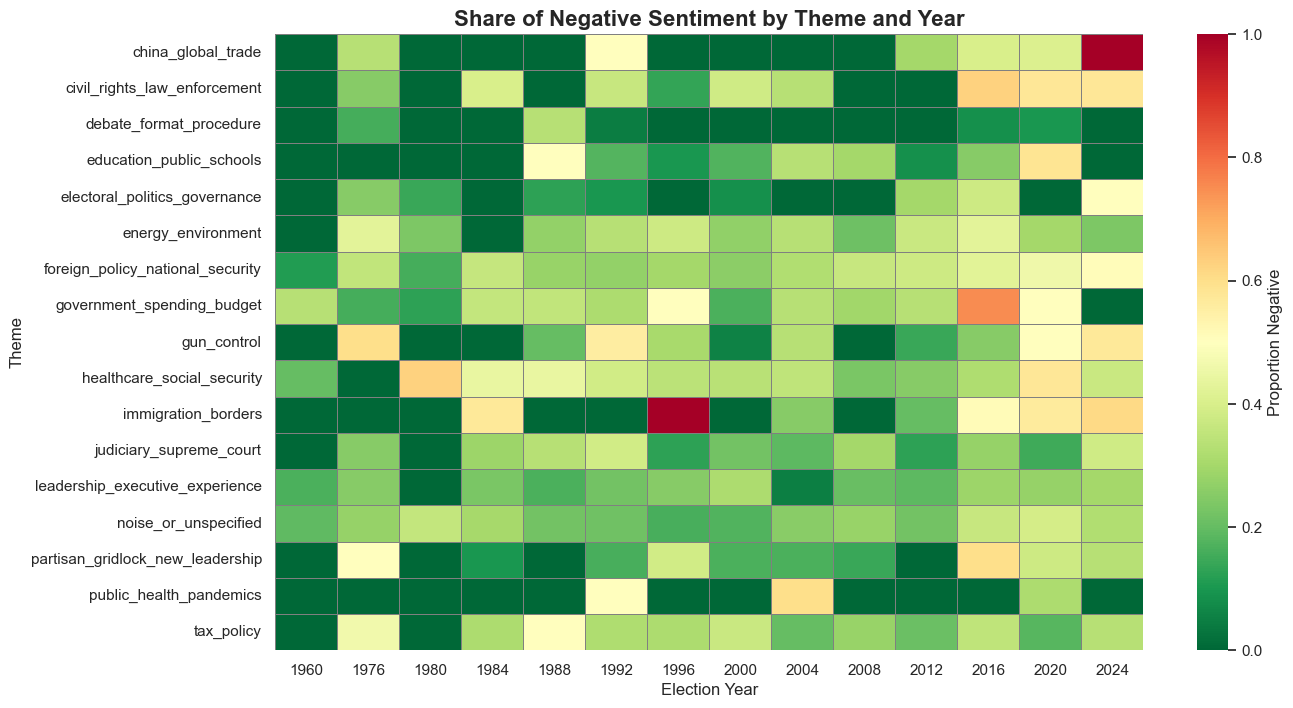

In [333]:
# === HEATMAP: AVERAGE NEGATIVE SHARE PER THEME ===

# compute % negative per theme-year
neg_share = (
    debates.assign(is_negative=debates["sentiment"]=="negative")
    .groupby(["theme","year"])["is_negative"]
    .mean()
    .reset_index()
    .pivot(index="theme", columns="year", values="is_negative")
    .fillna(0)
)

plt.figure(figsize=(14,8))
sns.heatmap(
    neg_share, cmap="RdYlGn_r", center=0.5,
    linewidths=0.5, linecolor="gray",
    cbar_kws={"label": "Proportion Negative"}
)
plt.title("Share of Negative Sentiment by Theme and Year", fontsize=16, fontweight="bold")
plt.xlabel("Election Year")
plt.ylabel("Theme")
plt.show()

### 2.2. Is Emotional Coloring More Prevalent Recently?

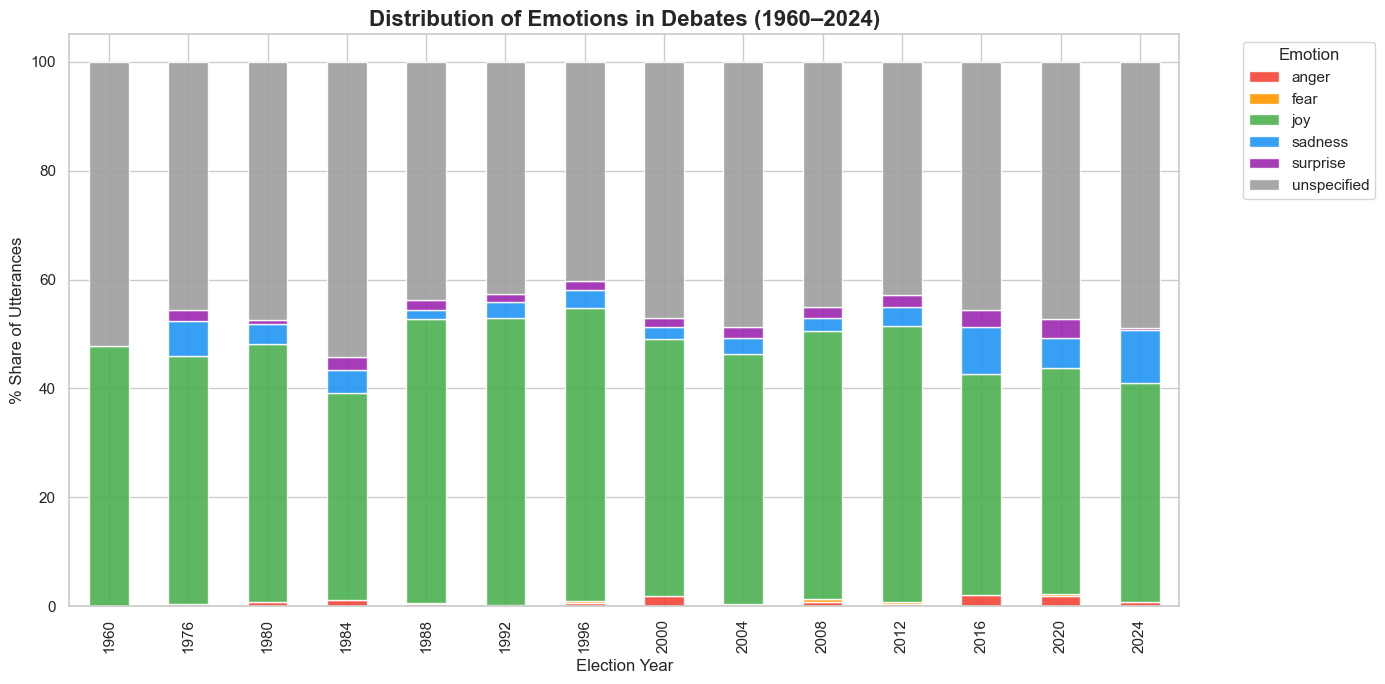

In [334]:
# === STACKED BARS: EMOTION DISTRIBUTION PER CYCLE (CLEAN COLORS) ===

# compute distribution
emo_dist = (
    debates.groupby(["year","emotion"])
    .size()
    .reset_index(name="count")
)
totals = emo_dist.groupby("year")["count"].transform("sum")
emo_dist["pct"] = emo_dist["count"] / totals * 100

emo_pivot = emo_dist.pivot(index="year", columns="emotion", values="pct").fillna(0)

# consistent emotion palette
emotion_palette = {
    "anger": "#F44336",
    "fear": "#FF9800",
    "joy": "#4CAF50",
    "sadness": "#2196F3",
    "surprise": "#9C27B0",
    "unspecified": "#9E9E9E"
}

# reorder columns for readability
col_order = ["anger","fear","joy","sadness","surprise","unspecified"]
emo_pivot = emo_pivot.reindex(columns=col_order)

emo_pivot.plot(
    kind="bar", stacked=True, figsize=(14,7), alpha=0.9,
    color=[emotion_palette[c] for c in emo_pivot.columns]
)

plt.title("Distribution of Emotions in Debates (1960–2024)", fontsize=16, fontweight="bold")
plt.ylabel("% Share of Utterances")
plt.xlabel("Election Year")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

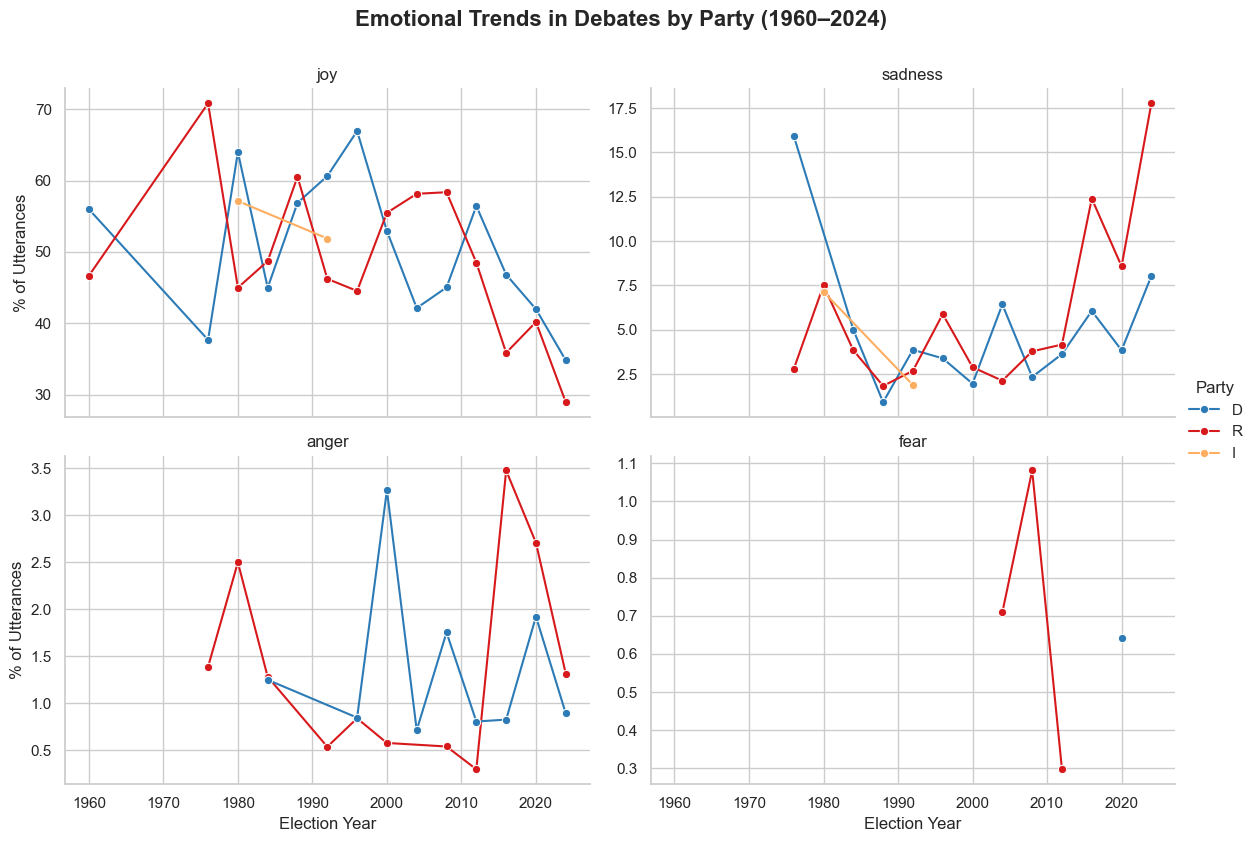

In [335]:
# === TREND LINES: EMOTIONS OVER TIME BY PARTY (FACETTED BY EMOTION) ===

emo_trends = (
    debates.groupby(["year","party_code","emotion"])
    .size()
    .reset_index(name="count")
)
totals = emo_trends.groupby(["year","party_code"])["count"].transform("sum")
emo_trends["pct"] = emo_trends["count"] / totals * 100

# restrict to key emotions
key_emotions = ["anger","joy","fear","sadness"]
emo_subset = emo_trends[emo_trends["emotion"].isin(key_emotions)]

g = sns.FacetGrid(
    emo_subset, col="emotion", col_wrap=2, height=4, aspect=1.5,
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="year", y="pct", hue="party_code",
    palette={"D":"#2C7BB6","R":"#D7191C","I":"#FDAE61"},
    marker="o"
)

g.set_titles("{col_name}")
g.set_axis_labels("Election Year", "% of Utterances")
g.add_legend(title="Party")
plt.suptitle("Emotional Trends in Debates by Party (1960–2024)", fontsize=16, fontweight="bold", y=1.05)
plt.show()

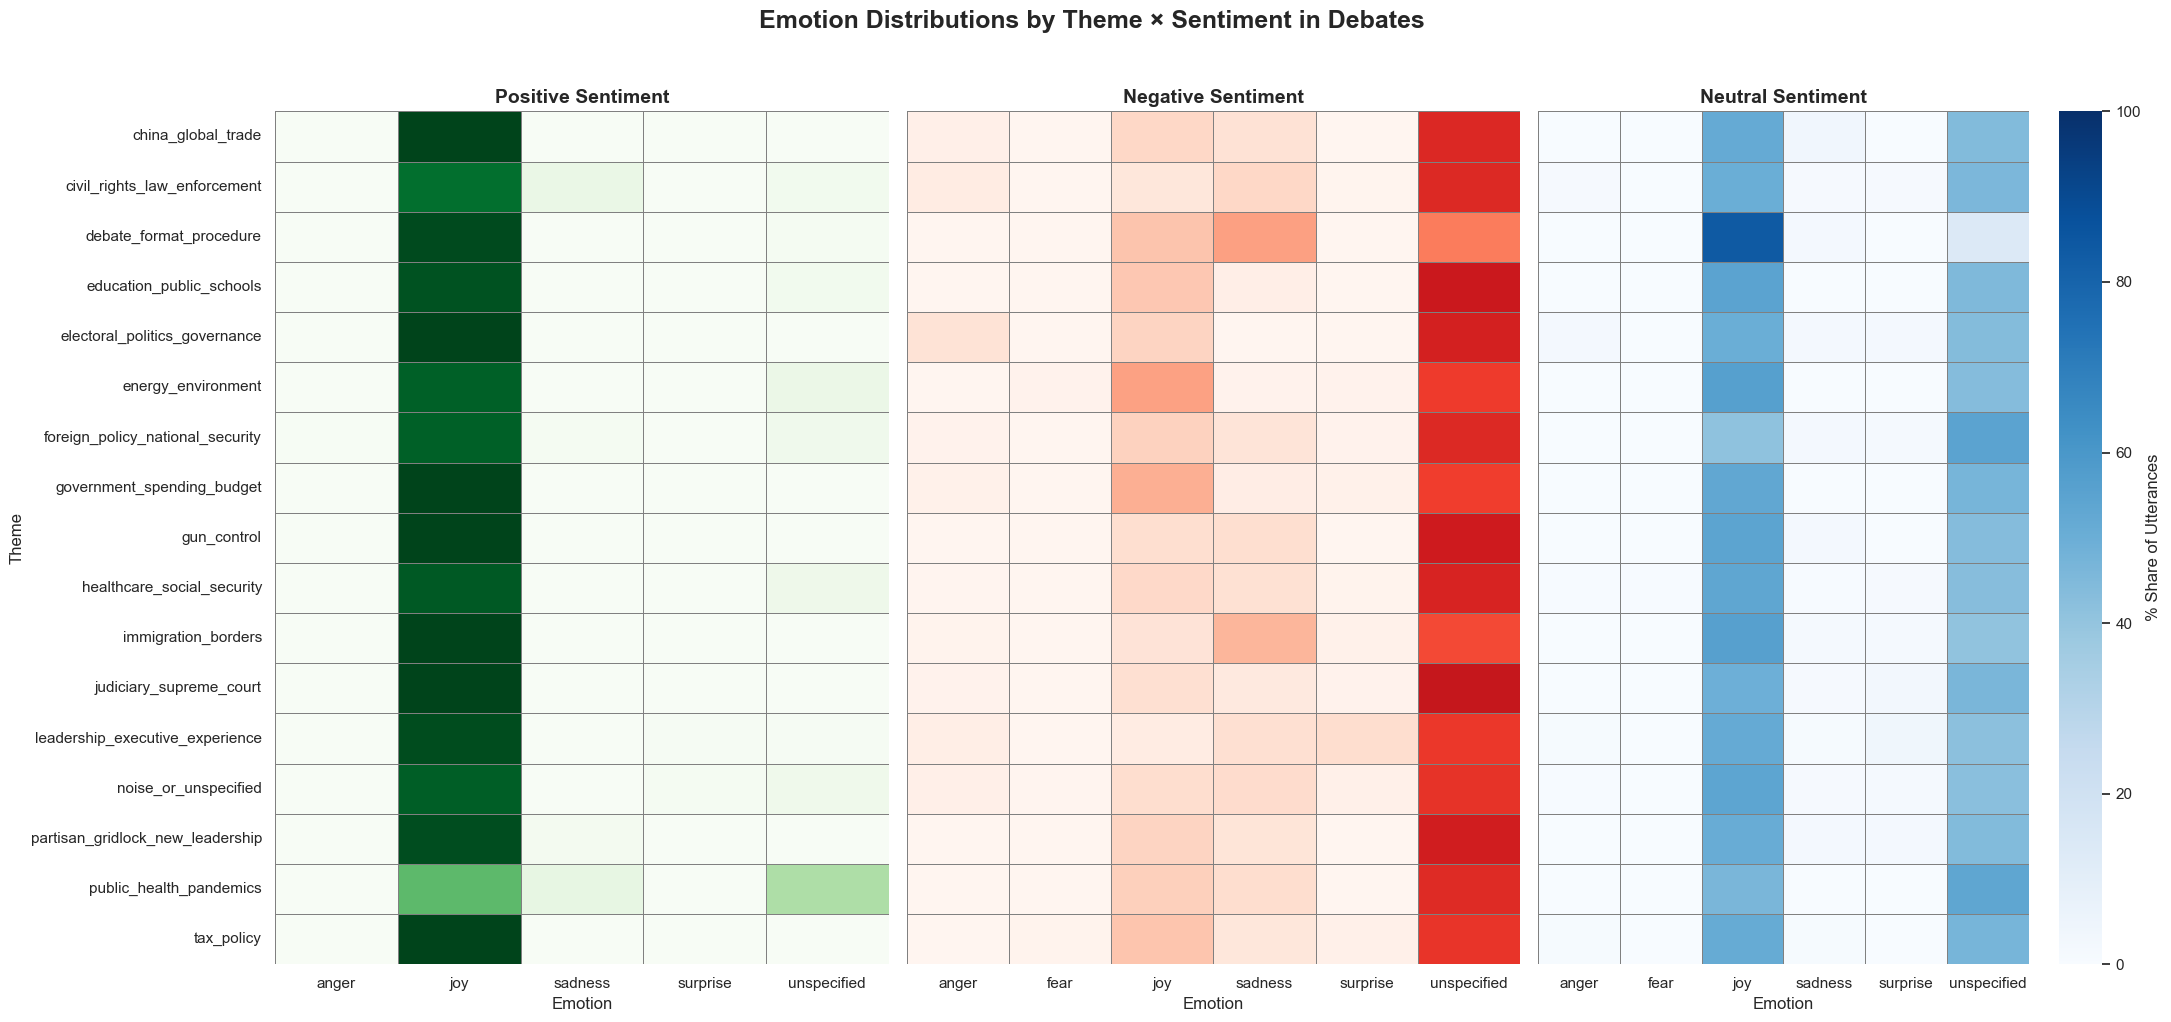

In [336]:
# === THEMES × EMOTIONS × SENTIMENT HEATMAPS ===

import seaborn as sns
import matplotlib.pyplot as plt

# group by theme, sentiment, emotion
emo_sent_theme = (
    debates.groupby(["theme","sentiment","emotion"])
    .size()
    .reset_index(name="count")
)

# normalize within theme × sentiment
totals = emo_sent_theme.groupby(["theme","sentiment"])["count"].transform("sum")
emo_sent_theme["pct"] = emo_sent_theme["count"] / totals * 100

# pivot for heatmap (one per sentiment)
sentiments = ["positive","negative","neutral"]
sentiment_colors = {
    "positive": "Greens",
    "negative": "Reds",
    "neutral": "Blues"
}

fig, axes = plt.subplots(1, len(sentiments), figsize=(22, 10), sharey=True)

for i, sent in enumerate(sentiments):
    subset = emo_sent_theme[emo_sent_theme["sentiment"] == sent]
    heatmap_data = subset.pivot(index="theme", columns="emotion", values="pct").fillna(0)

    sns.heatmap(
        heatmap_data, ax=axes[i],
        cmap=sentiment_colors[sent],
        linewidths=0.5, linecolor="gray",
        vmin=0, vmax=100,
        cbar=(i==len(sentiments)-1),
        cbar_kws={"label": "% Share of Utterances"}
    )
    axes[i].set_title(f"{sent.capitalize()} Sentiment", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Emotion")
    if i == 0:
        axes[i].set_ylabel("Theme")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Emotion Distributions by Theme × Sentiment in Debates", fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### 2.3. Does Media Reflect Political Discourse?

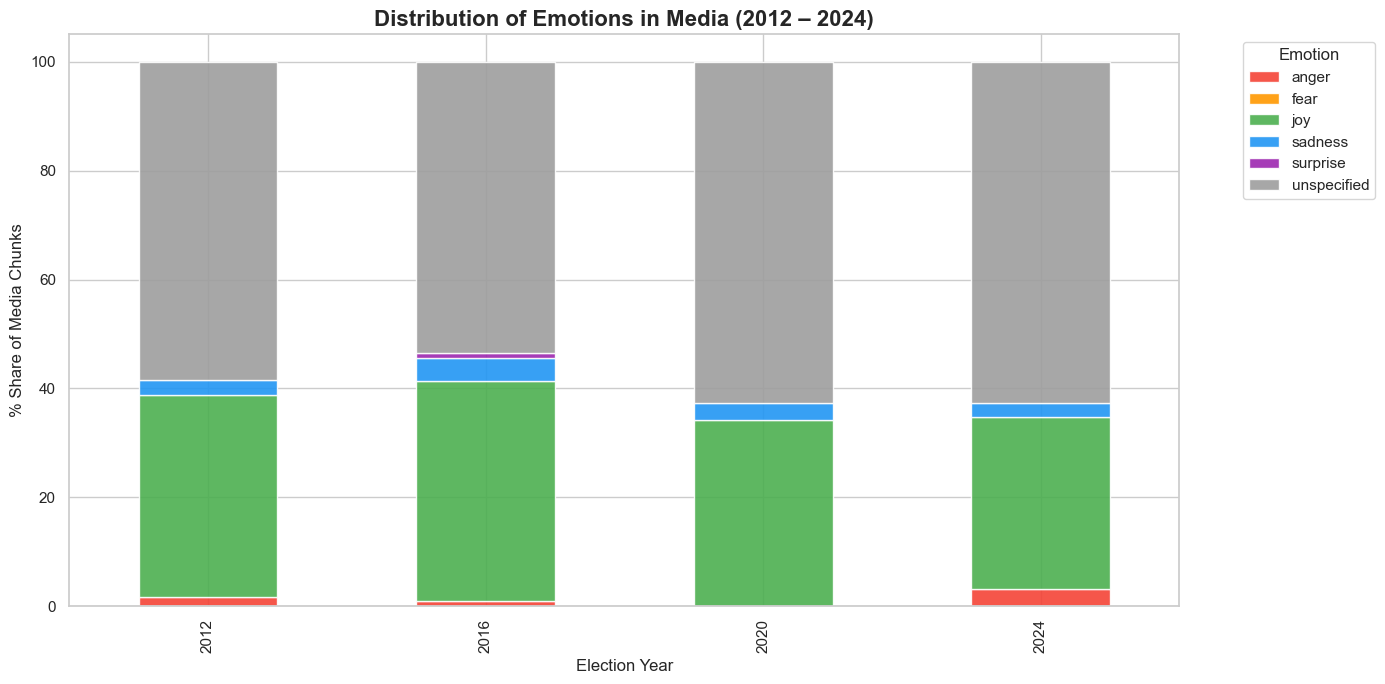

In [338]:
# === STACKED BARS: EMOTION DISTRIBUTION PER CYCLE (CLEAN COLORS) ===

# compute distribution
emo_dist = (
    media.groupby(["year","emotion"])
    .size()
    .reset_index(name="count")
)
totals = emo_dist.groupby("year")["count"].transform("sum")
emo_dist["pct"] = emo_dist["count"] / totals * 100

emo_pivot = emo_dist.pivot(index="year", columns="emotion", values="pct").fillna(0)

# consistent emotion palette
emotion_palette = {
    "anger": "#F44336",
    "fear": "#FF9800",
    "joy": "#4CAF50",
    "sadness": "#2196F3",
    "surprise": "#9C27B0",
    "unspecified": "#9E9E9E"
}

# reorder columns for readability
col_order = ["anger","fear","joy","sadness","surprise","unspecified"]
emo_pivot = emo_pivot.reindex(columns=col_order)

emo_pivot.plot(
    kind="bar", stacked=True, figsize=(14,7), alpha=0.9,
    color=[emotion_palette[c] for c in emo_pivot.columns]
)

plt.title("Distribution of Emotions in Media (2012 – 2024)", fontsize=16, fontweight="bold")
plt.ylabel("% Share of Media Chunks")
plt.xlabel("Election Year")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

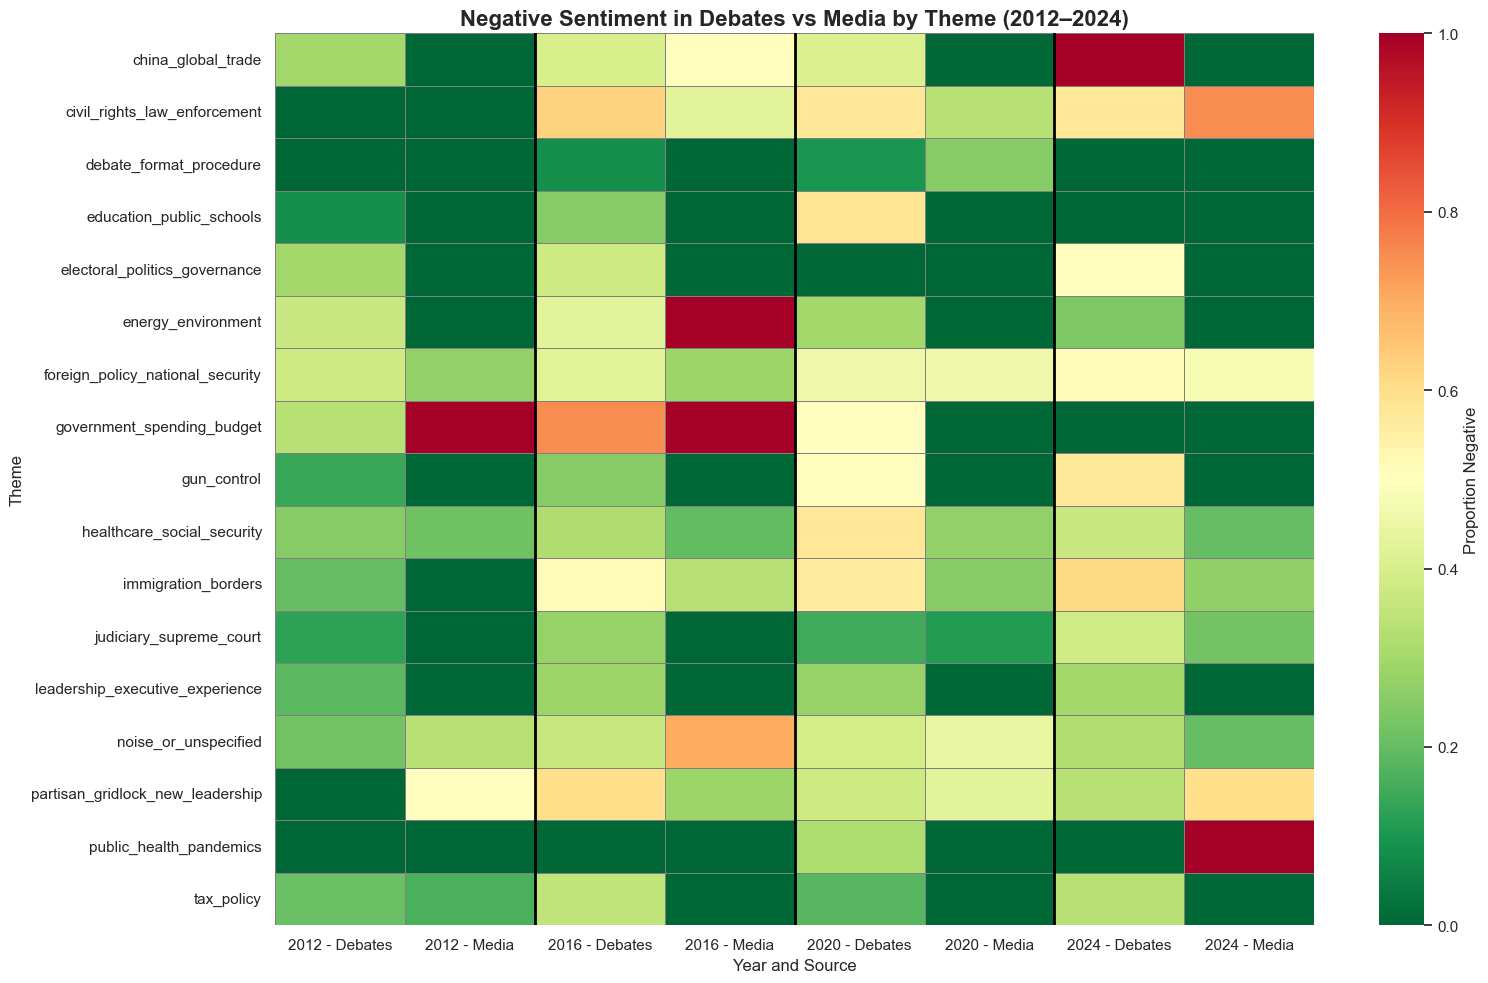

In [339]:
# === HEATMAP: NEGATIVE SHARE WITH YEAR-SOURCE ON X-AXIS ===

# debates
neg_share_deb = (
    debates[debates["year"] >= 2012]
    .assign(is_negative=debates["sentiment"]=="negative")
    .groupby(["theme","year"])["is_negative"]
    .mean()
    .reset_index()
)
neg_share_deb["source"] = "Debates"

# media
neg_share_media = (
    media.assign(is_negative=media["sentiment"]=="negative")
    .groupby(["theme","year"])["is_negative"]
    .mean()
    .reset_index()
    .rename(columns={"theme":"theme"})
)
neg_share_media["source"] = "Media"

# merge
neg_compare = pd.concat([neg_share_deb, neg_share_media])

# create combined column "year-source"
neg_compare["year_source"] = neg_compare["year"].astype(str) + " - " + neg_compare["source"]

# pivot for heatmap
heatmap_data = neg_compare.pivot(index="theme", columns="year_source", values="is_negative").fillna(0)

# sort columns in chronological order (2012 Debates, 2012 Media, 2016 Debates, 2016 Media...)
year_order = sorted(neg_compare["year"].unique())
col_order = []
for y in year_order:
    col_order.extend([f"{y} - Debates", f"{y} - Media"])
heatmap_data = heatmap_data.reindex(columns=col_order)

# plot with group separators
plt.figure(figsize=(16,10))
ax = sns.heatmap(
    heatmap_data, cmap="RdYlGn_r", center=0.5,
    linewidths=0.5, linecolor="gray",
    cbar_kws={"label": "Proportion Negative"}
)

ax.set_title("Negative Sentiment in Debates vs Media by Theme (2012–2024)", fontsize=16, fontweight="bold")
ax.set_xlabel("Year and Source")
ax.set_ylabel("Theme")

# bold vertical separators (between Debates and Media each year)
n_rows, n_cols = heatmap_data.shape
for j in range(2, n_cols, 2):            # after columns 2, 4, 6, ...
    ax.axvline(j, color="black", lw=2, zorder=10)

plt.tight_layout()
plt.show()

### 2.4. Candidate-Level Spotlight

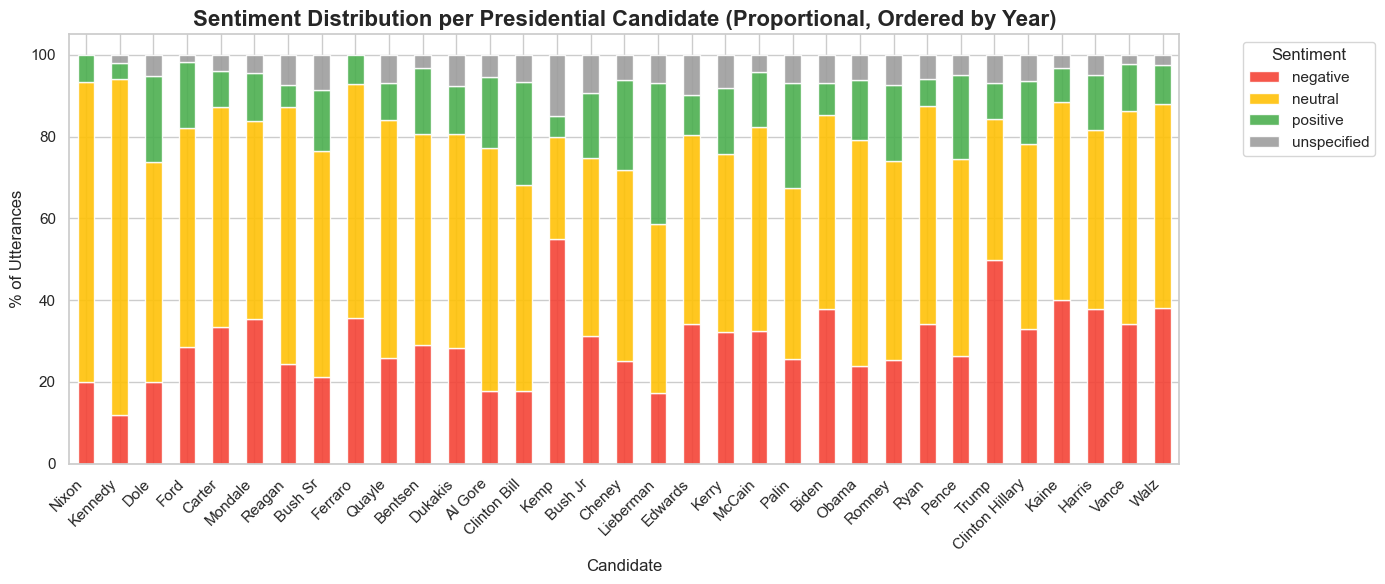

In [340]:
# === SENTIMENT PER PRESIDENTIAL CANDIDATE (EXCLUDE VPs) ===

import pandas as pd
import matplotlib.pyplot as plt

# consistent sentiment palette
sentiment_palette = {
    "positive": "#4CAF50",
    "neutral": "#FFC107",
    "negative": "#F44336",
    "unspecified": "#9E9E9E"
}
# keep only Rs and Ds, exclude known VPs
cand_sent = debates[
    (debates["party_code"].isin(["R","D"]))
]

# candidate-year mapping (first year they appear)
cand_year = (
    cand_sent.groupby("speaker")["year"]
    .min()
    .reset_index()
    .rename(columns={"year":"first_year"})
)

# party mapping
cand_party = (
    cand_sent.groupby("speaker")["party_code"]
    .first()
    .reset_index()
)

# combine metadata
cand_meta = cand_year.merge(cand_party, on="speaker")

# group by candidate + sentiment
cand_sent_dist = (
    cand_sent.groupby(["speaker","sentiment"])
    .size()
    .reset_index(name="count")
)

# normalize per candidate
totals = cand_sent_dist.groupby("speaker")["count"].transform("sum")
cand_sent_dist["pct"] = cand_sent_dist["count"] / totals * 100

# pivot for plotting
cand_sent_pivot = cand_sent_dist.pivot(index="speaker", columns="sentiment", values="pct").fillna(0)

# merge metadata for ordering
cand_sent_pivot = cand_sent_pivot.merge(cand_meta, on="speaker")

# define ordering: by first year, then put R before D
cand_sent_pivot["party_order"] = cand_sent_pivot["party_code"].map({"R":0, "D":1})
cand_sent_pivot = cand_sent_pivot.sort_values(["first_year","party_order"], ascending=[True,True])

# reset index for plotting
cand_sent_pivot = cand_sent_pivot.set_index("speaker")

# palette and sentiment order (negative first)
sentiment_order = ["negative","neutral","positive","unspecified"]

# stacked vertical barplot
cand_sent_pivot[sentiment_order].plot(
    kind="bar", stacked=True, figsize=(14,6), alpha=0.9,
    color=[sentiment_palette[c] for c in sentiment_order]
)

plt.title("Sentiment Distribution per Presidential Candidate (Proportional, Ordered by Year)", fontsize=16, fontweight="bold")
plt.ylabel("% of Utterances")
plt.xlabel("Candidate")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 3. Framing and Rhetoric as Political Tools

In [341]:
# === CONFIG ===
FRAME_COL = "framing"
RHET_COL = "rhetoric"

frame_order = ["economic", "security", "fairness", "morality", "legality", "unspecified"]
rhet_palette = {"attack": "#E91E63", "defense": "#03A9F4", "acclaim": "#8BC34A", "unspecified": "#B0BEC5"}

# color config
frame_palette = {
    "economic consequences": "#FF9800",
    "security and safety": "#F44336",
    "fairness and social justice": "#2196F3",
    "morality and ethics": "#9C27B0",
    "legality and constitutionality": "#4CAF50",
    "unspecified": "#9E9E9E"
}
# group + normalize
df = (
    debates.groupby(["party_code", FRAME_COL, RHET_COL])
    .size().reset_index(name="count")
)
totals = df.groupby(["party_code", FRAME_COL])["count"].transform("sum")
df["pct"] = df["count"] / totals * 100

# pivot for stacked bars
pivot = df.pivot_table(index=["party_code", FRAME_COL], columns=RHET_COL, values="pct", fill_value=0).reset_index()

### 3.1. How Do Parties Use Different Rhetorical Strategies?

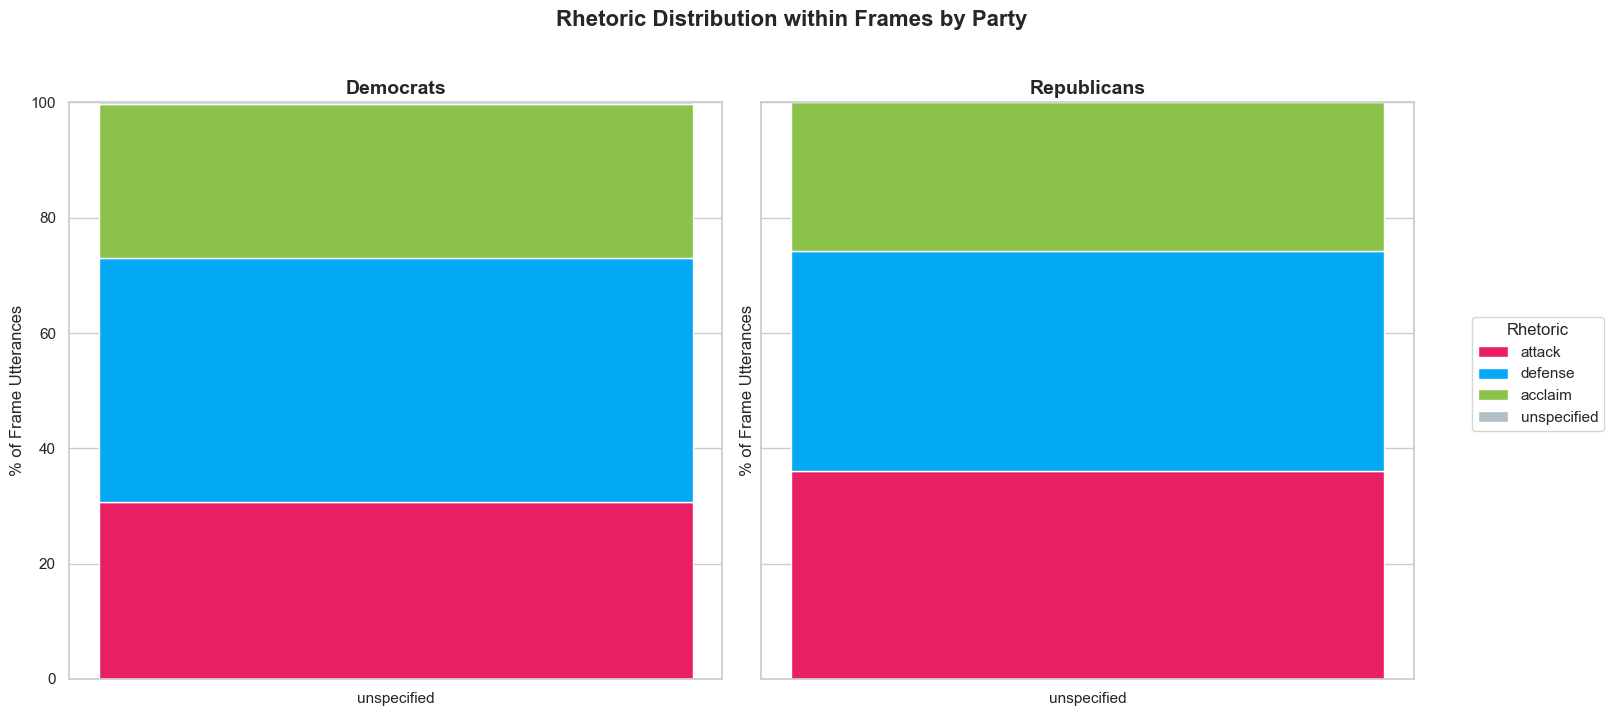

In [342]:
# === VERTICAL STACKED BARS ===
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

for i, party in enumerate(["D", "R"]):
    subset = pivot[pivot["party_code"] == party].set_index(FRAME_COL)
    subset = subset.reindex(frame_order)

    bottom = np.zeros(len(subset))
    for rhet, color in rhet_palette.items():
        if rhet in subset.columns:
            axes[i].bar(
                subset.index, subset[rhet],
                bottom=bottom, color=color, label=rhet if i == 0 else ""
            )
            bottom += subset[rhet].values

    axes[i].set_title("Democrats" if party == "D" else "Republicans", fontsize=14, fontweight="bold")
    axes[i].set_ylabel("% of Frame Utterances")

fig.legend(title="Rhetoric", bbox_to_anchor=(0.92, 0.5), loc="center left")
plt.suptitle("Rhetoric Distribution within Frames by Party", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout(rect=[0,0,0.9,1])
plt.show()

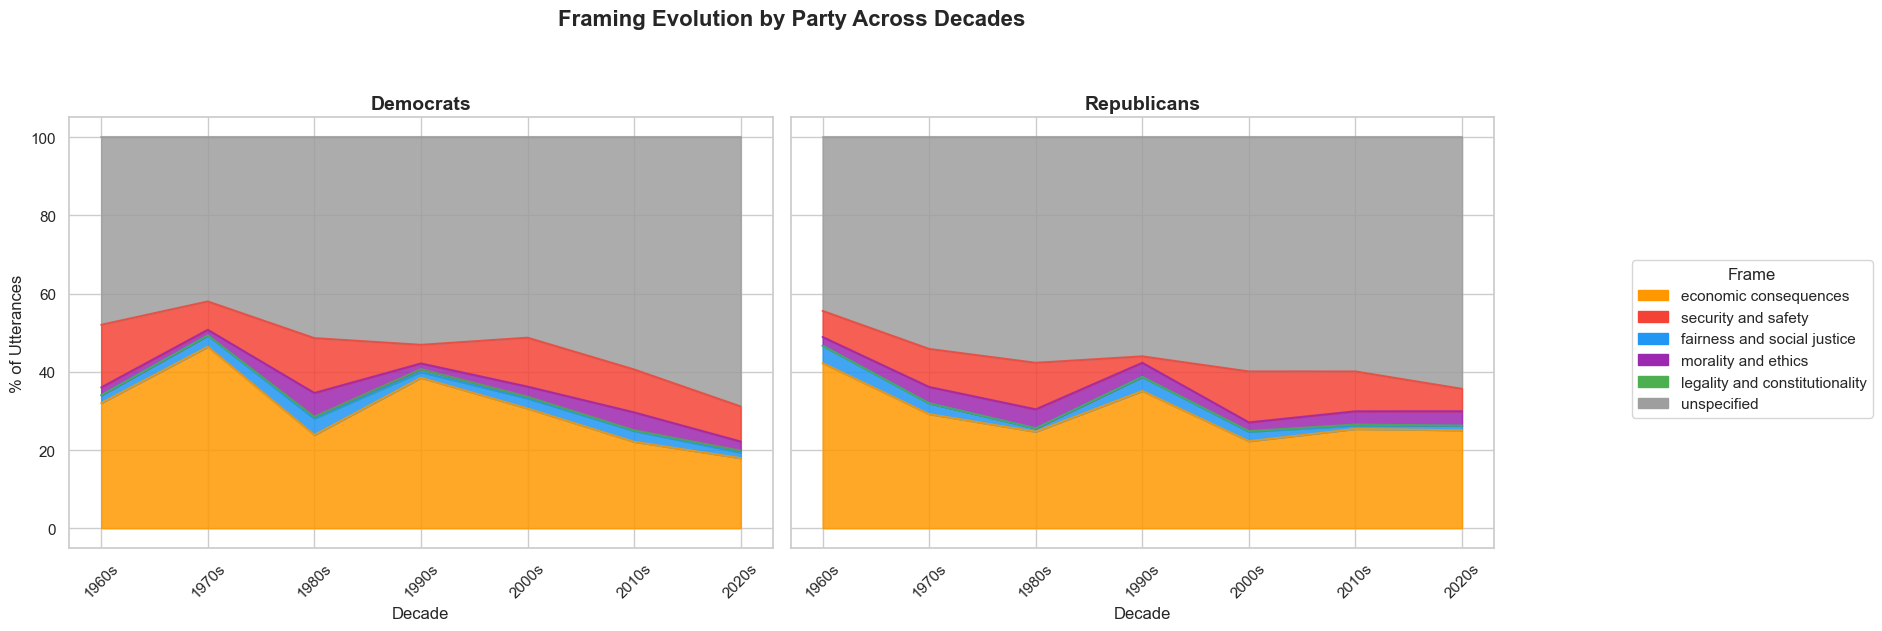

In [245]:
# === FRAMING DISTRIBUTION OVER TIME BY PARTY (STACKED AREA) ===

# filter to valid data
df_frames_time = debates[
    debates[FRAME_COL].notna() &
    debates["party_code"].isin(["D", "R"])
].copy()

df_frames_time["decade"] = (df_frames_time["year"] // 10 * 10).astype(str) + "s"

# group + normalize
decade_frame = (
    df_frames_time
    .groupby(["decade", "party_code", FRAME_COL])
    .size()
    .reset_index(name="count")
)

totals = decade_frame.groupby(["decade", "party_code"])["count"].transform("sum")
decade_frame["pct"] = decade_frame["count"] / totals * 100

# pivot for stacked area
pivot = decade_frame.pivot_table(index="decade", columns=["party_code", FRAME_COL], values="pct").fillna(0)
pivot = pivot.sort_index()

# === PLOT ===
parties = ["D", "R"]
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i, party in enumerate(parties):
    ax = axes[i]
    cols = [col for col in pivot.columns if col[0] == party]
    pivot[cols].plot.area(
        ax=ax,
        color=[frame_palette.get(f, "#9E9E9E") for (_, f) in cols],
        legend=False,
        alpha=0.85
    )
    ax.set_title("Democrats" if party == "D" else "Republicans", fontsize=14, fontweight="bold")
    ax.set_ylabel("% of Utterances")
    ax.set_xlabel("Decade")
    ax.set_xticks(range(len(pivot.index)))
    ax.set_xticklabels(pivot.index, rotation=45)

# custom legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in frame_palette.values()]
labels = list(frame_palette.keys())
fig.legend(handles, labels, title="Frame", loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.suptitle("Framing Evolution by Party Across Decades", fontsize=16, fontweight="bold", y=1.05)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

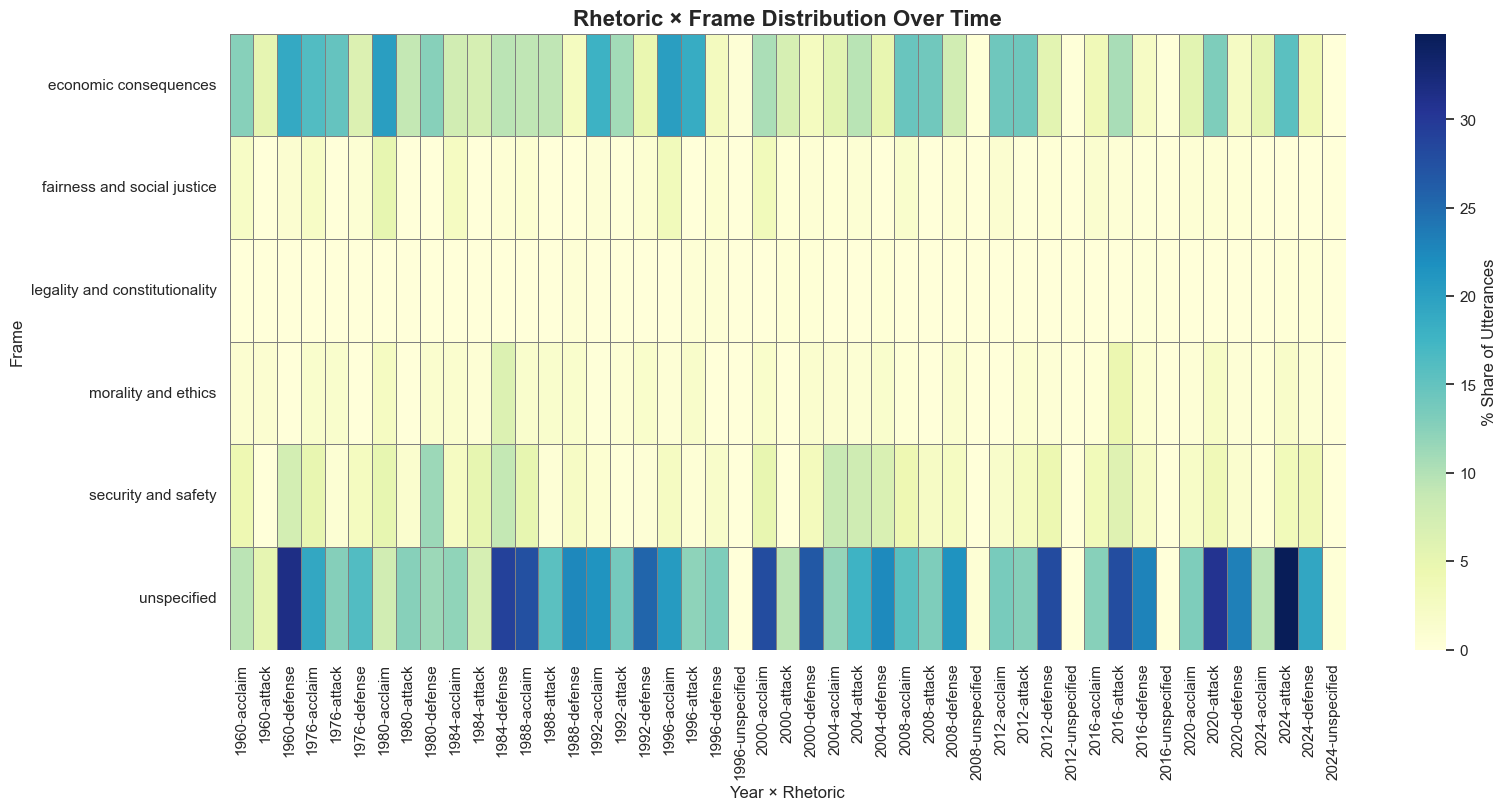

In [343]:
# === OVERALL EVOLUTION: FRAME × RHETORIC OVER TIME ===

combo = (
    debates.groupby(["year","framing","rhetoric"])
    .size().reset_index(name="count")
)
totals = combo.groupby("year")["count"].transform("sum")
combo["pct"] = combo["count"] / totals * 100

heat = combo.pivot_table(index="framing", columns=["year","rhetoric"], values="pct", fill_value=0)

plt.figure(figsize=(18,8))
sns.heatmap(
    heat, cmap="YlGnBu", linewidths=0.5, linecolor="gray",
    cbar_kws={"label":"% Share of Utterances"}
)
plt.title("Rhetoric × Frame Distribution Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Year × Rhetoric")
plt.ylabel("Frame")
plt.show()

### 3.2. How Does Framing Interact With Themes and Sentiment?

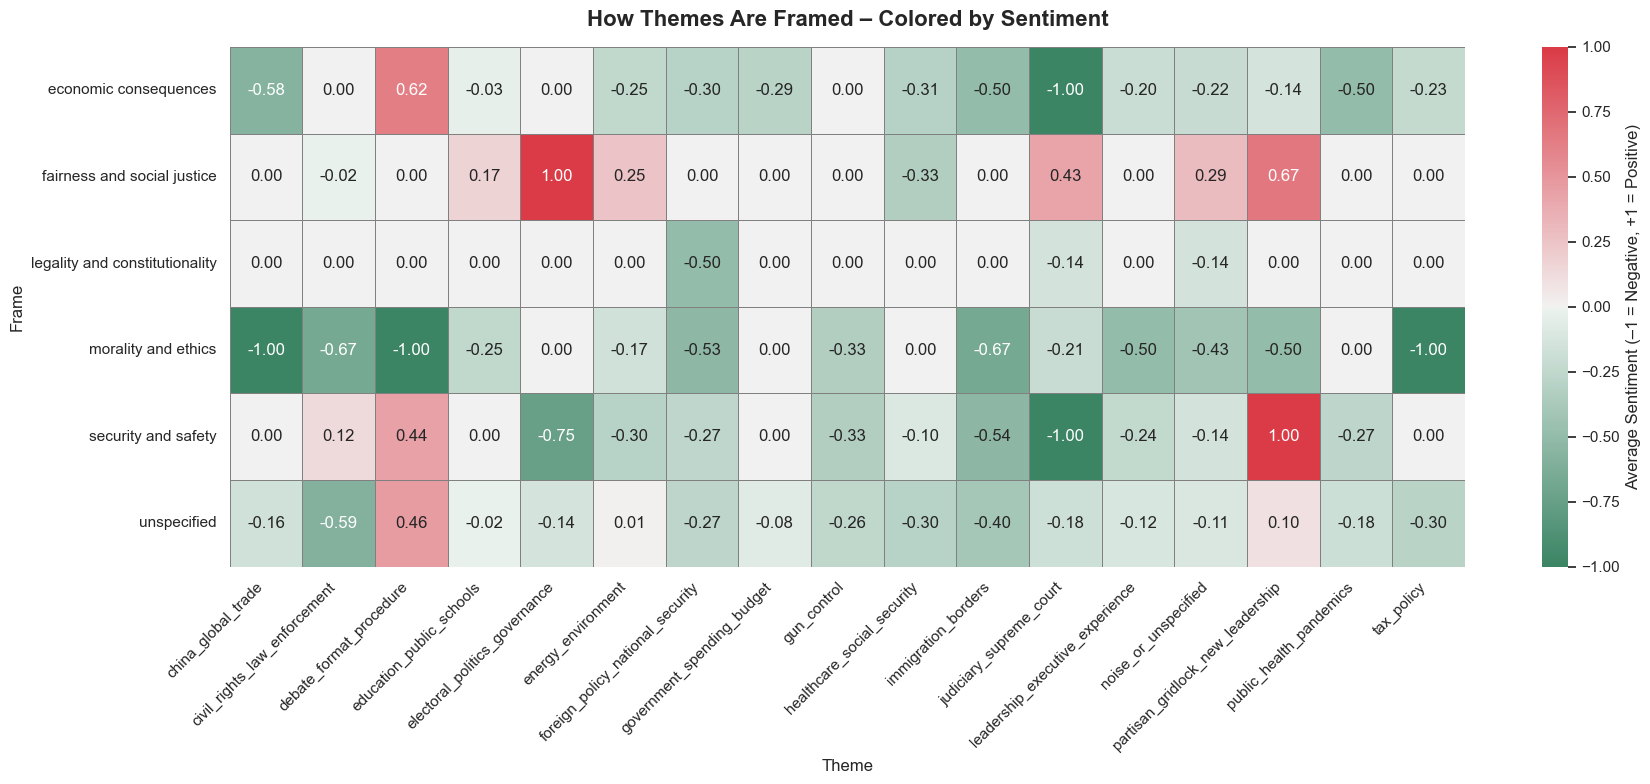

In [344]:
# === FRAME × THEME HEATMAP COLORED BY SENTIMENT ===

# compute average sentiment per (frame × theme)
sent_map = {"positive": 1, "neutral": 0, "negative": -1}
df_heat = (
    debates[
        debates[FRAME_COL].notna() &
        debates["theme"].notna() &
        debates["sentiment"].isin(sent_map)
    ].copy()
)
df_heat["sent_val"] = df_heat["sentiment"].map(sent_map)

avg_sent = (
    df_heat
    .groupby([FRAME_COL, "theme"])["sent_val"]
    .mean()
    .reset_index(name="avg_sentiment")
)

# pivot for heatmap
heatmap_data = avg_sent.pivot(index=FRAME_COL, columns="theme", values="avg_sentiment").fillna(0)

# plot
plt.figure(figsize=(18, 8))
sns.heatmap(
    heatmap_data, annot=True, fmt=".2f",
    cmap=sns.diverging_palette(150, 10, as_cmap=True), center=0,
    linewidths=0.5, linecolor="gray",
    cbar_kws={"label": "Average Sentiment (–1 = Negative, +1 = Positive)"}
)
plt.title("How Themes Are Framed – Colored by Sentiment", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Theme")
plt.ylabel("Frame")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

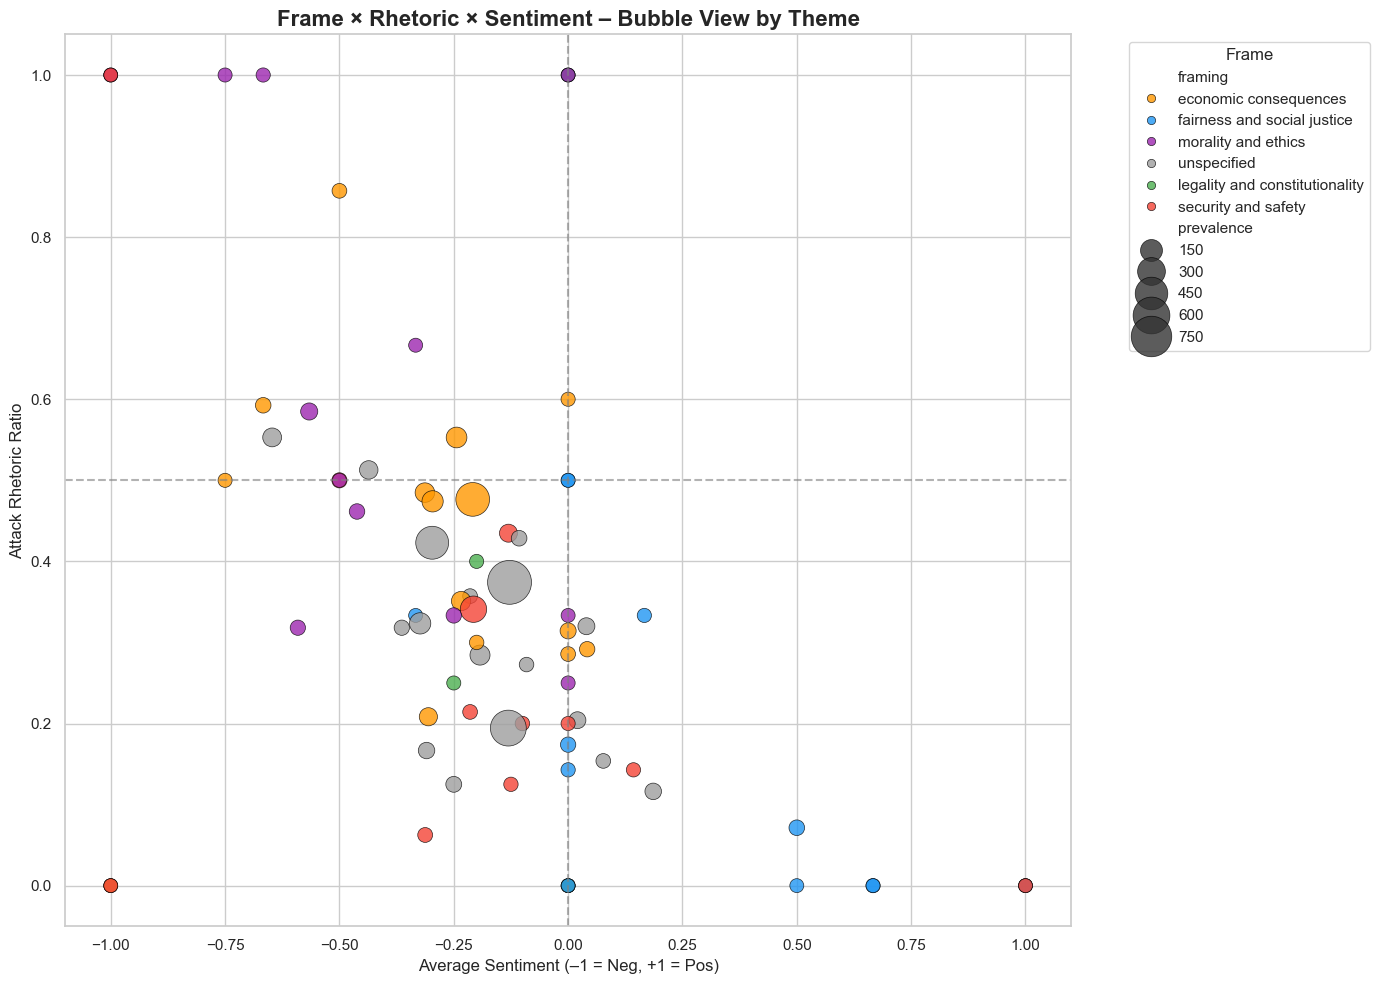

In [345]:
# === SCATTERPLOT: SENTIMENT × ATTACK RATIO BY FRAME+THEME ===

# prepare aggregate data for bubble chart
df_bubble = (
    debates[
        debates[FRAME_COL].notna() &
        debates["theme"].notna() &
        debates["sentiment"].isin(sent_map) &
        debates[RHET_COL].isin(["attack", "defense", "acclaim"])
    ].copy()
)
df_bubble["sent_val"] = df_bubble["sentiment"].map(sent_map)
df_bubble["is_attack"] = (df_bubble[RHET_COL] == "attack").astype(int)

bubble_data = (
    df_bubble
    .groupby(["theme", FRAME_COL])
    .agg(
        sentiment_mean=("sent_val", "mean"),
        attack_ratio=("is_attack", "mean"),
        prevalence=("utterance_id", "count")
    )
    .reset_index()
)

# plot bubble chart
plt.figure(figsize=(14,10))
sns.scatterplot(
    data=bubble_data,
    x="sentiment_mean", y="attack_ratio",
    size="prevalence", hue=FRAME_COL,
    palette=frame_palette, alpha=0.8,
    sizes=(100, 1000), edgecolor="black", linewidth=0.5
)
plt.axhline(0.5, color="gray", linestyle="--", alpha=0.6)   # attack midpoint
plt.axvline(0, color="gray", linestyle="--", alpha=0.6)     # neutral sentiment

plt.title("Frame × Rhetoric × Sentiment – Bubble View by Theme", fontsize=16, fontweight="bold")
plt.xlabel("Average Sentiment (–1 = Neg, +1 = Pos)")
plt.ylabel("Attack Rhetoric Ratio")
plt.legend(title="Frame", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 3.3. Can Partisan Divergence in Frames and Rhetoric be Identified?

/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_75741/3112609052.py:35: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/var/folders/sc/040g6l752pg38ngvcz_ths0c0000gn/T/ipykernel_75741/3112609052.py:36: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



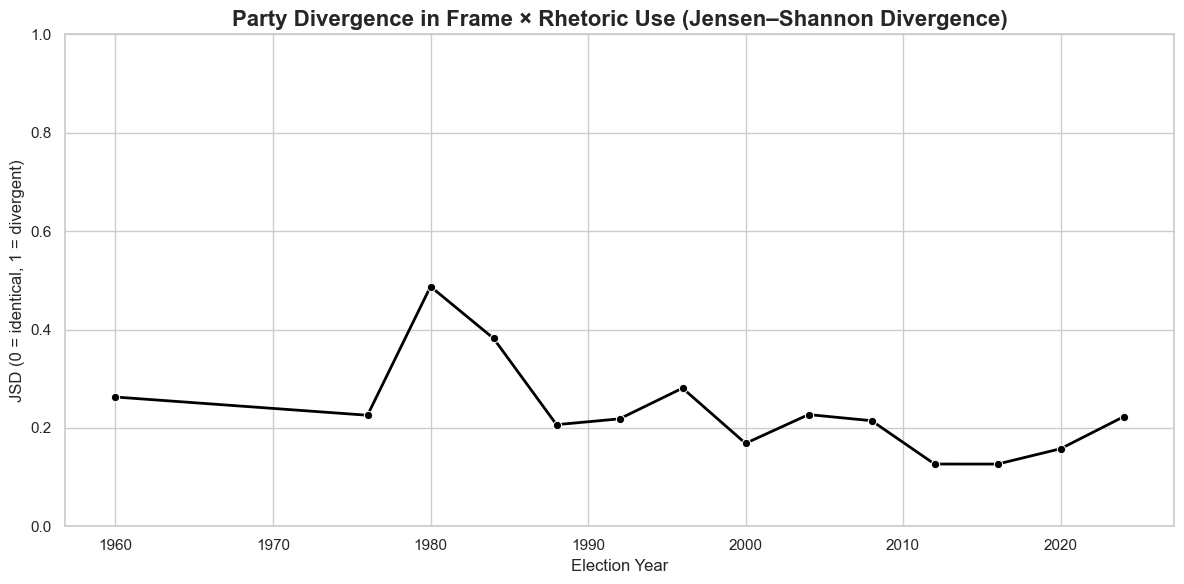

In [346]:
# === PARTISAN DIVERGENCE IN FRAME × RHETORIC OVER TIME (JSD) ===

# filter to valid parties + annotations
df = debates[
    debates["party_code"].isin(["D", "R"]) &
    debates[FRAME_COL].notna() &
    debates[RHET_COL].notna()
]

# group by year × party × frame × rhetoric
grouped = (
    df.groupby(["year", "party_code", FRAME_COL, RHET_COL])
    .size()
    .reset_index(name="count")
)

# normalize within party-year
totals = grouped.groupby(["year", "party_code"])["count"].transform("sum")
grouped["pct"] = grouped["count"] / totals

# pivot to distributions
pivot = grouped.pivot_table(
    index=["year", "party_code"],
    columns=[FRAME_COL, RHET_COL],
    values="pct",
    fill_value=0
).reset_index()

# compute JSD
jsd_results = []
for year in pivot["year"].unique():
    d_row = pivot[(pivot["year"] == year) & (pivot["party_code"] == "D")]
    r_row = pivot[(pivot["year"] == year) & (pivot["party_code"] == "R")]
    if not d_row.empty and not r_row.empty:
        jsd = jensenshannon(d_row.drop(columns=["year", "party_code"]).values[0],
                            r_row.drop(columns=["year", "party_code"]).values[0])
        jsd_results.append({"year": year, "jsd": jsd})

jsd_df = pd.DataFrame(jsd_results)

# plot JSD over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=jsd_df, x="year", y="jsd", marker="o", linewidth=2, color="black")

plt.title("Party Divergence in Frame × Rhetoric Use (Jensen–Shannon Divergence)", fontsize=16, fontweight="bold")
plt.ylabel("JSD (0 = identical, 1 = divergent)")
plt.xlabel("Election Year")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

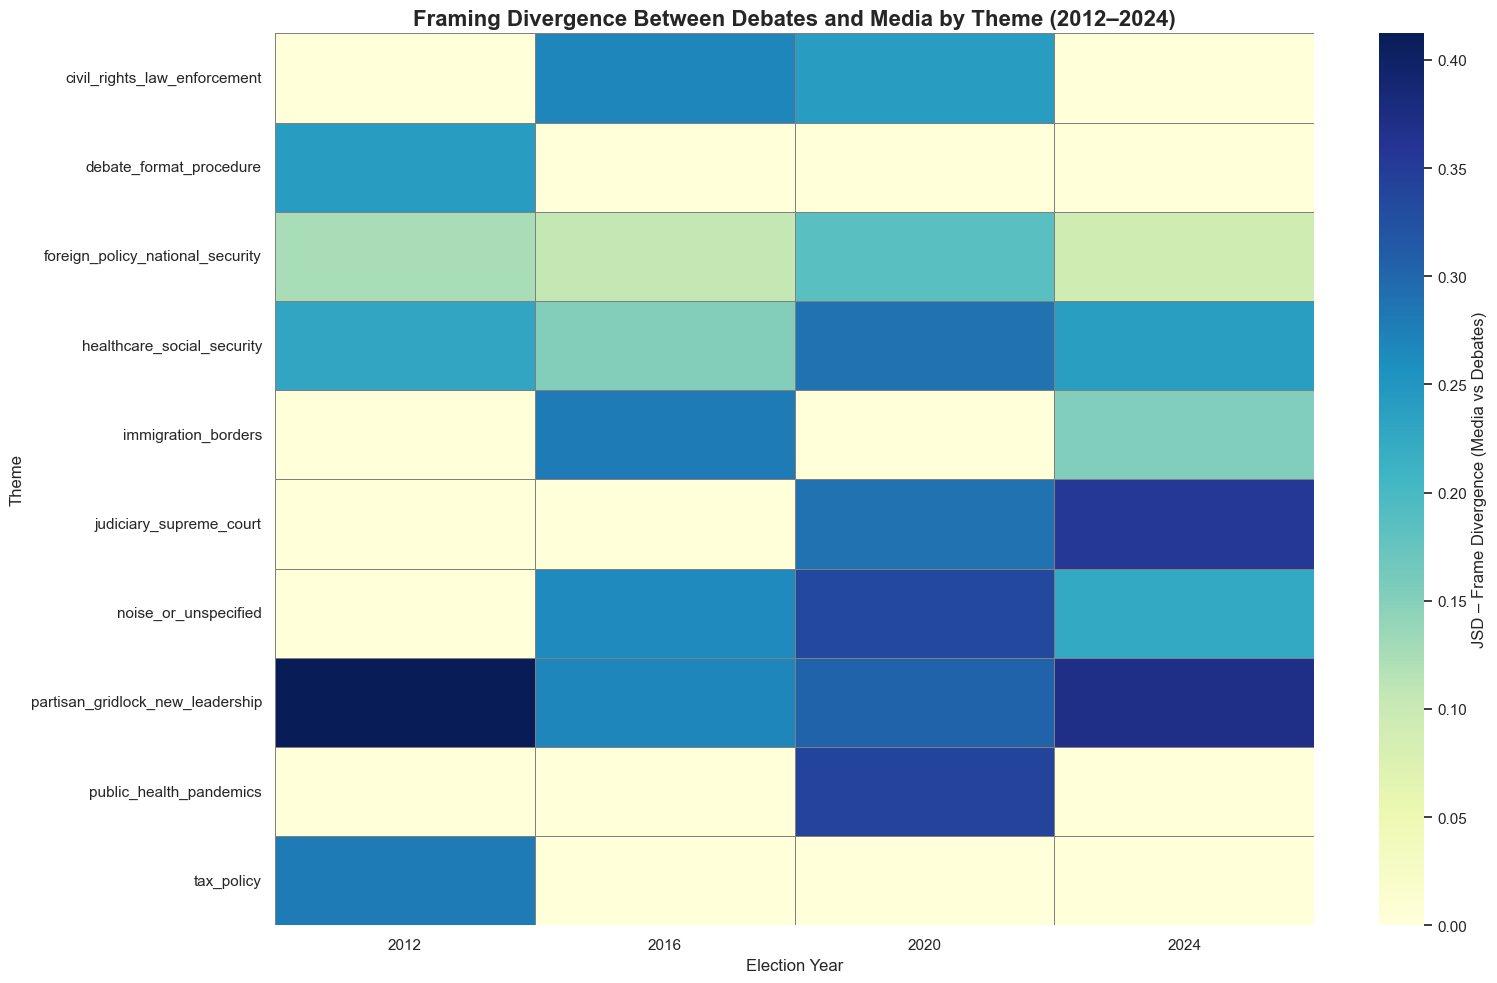

In [347]:
# === HEATMAP: JSD FRAME DIVERGENCE PER THEME × YEAR ===

from scipy.spatial.distance import jensenshannon

# filter valid themes and frames
df_deb = debates[
    (debates["year"] >= 2012) &
    debates["theme"].notna() &
    debates[FRAME_COL].notna()
].copy()

df_med = media[
    media["theme"].notna() &
    media[FRAME_COL].notna()
].copy()

jsd_rows = []
for year in df_deb["year"].unique():
    for theme in df_deb["theme"].unique():
        # debate frame dist
        deb_subset = df_deb[(df_deb["year"] == year) & (df_deb["theme"] == theme)]
        med_subset = df_med[(df_med["year"] == year) & (df_med["theme"] == theme)]

        if len(deb_subset) < 5 or len(med_subset) < 5:
            continue  # skip low data points for robustness

        deb_dist = (
            deb_subset.groupby(FRAME_COL).size()
            .pipe(lambda s: s / s.sum())
        )
        med_dist = (
            med_subset.groupby(FRAME_COL).size()
            .pipe(lambda s: s / s.sum())
        )

        aligned = deb_dist.align(med_dist, fill_value=0)
        jsd = jensenshannon(aligned[0], aligned[1])
        jsd_rows.append({"theme": theme, "year": year, "jsd": jsd})
        
jsd_df = pd.DataFrame(jsd_rows)

# pivot to heatmap form
heatmap_data = jsd_df.pivot(index="theme", columns="year", values="jsd").fillna(0)

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu", linewidths=0.5, linecolor="gray",
    cbar_kws={"label": "JSD – Frame Divergence (Media vs Debates)"}
)

plt.title("Framing Divergence Between Debates and Media by Theme (2012–2024)", fontsize=16, fontweight="bold")
plt.xlabel("Election Year")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

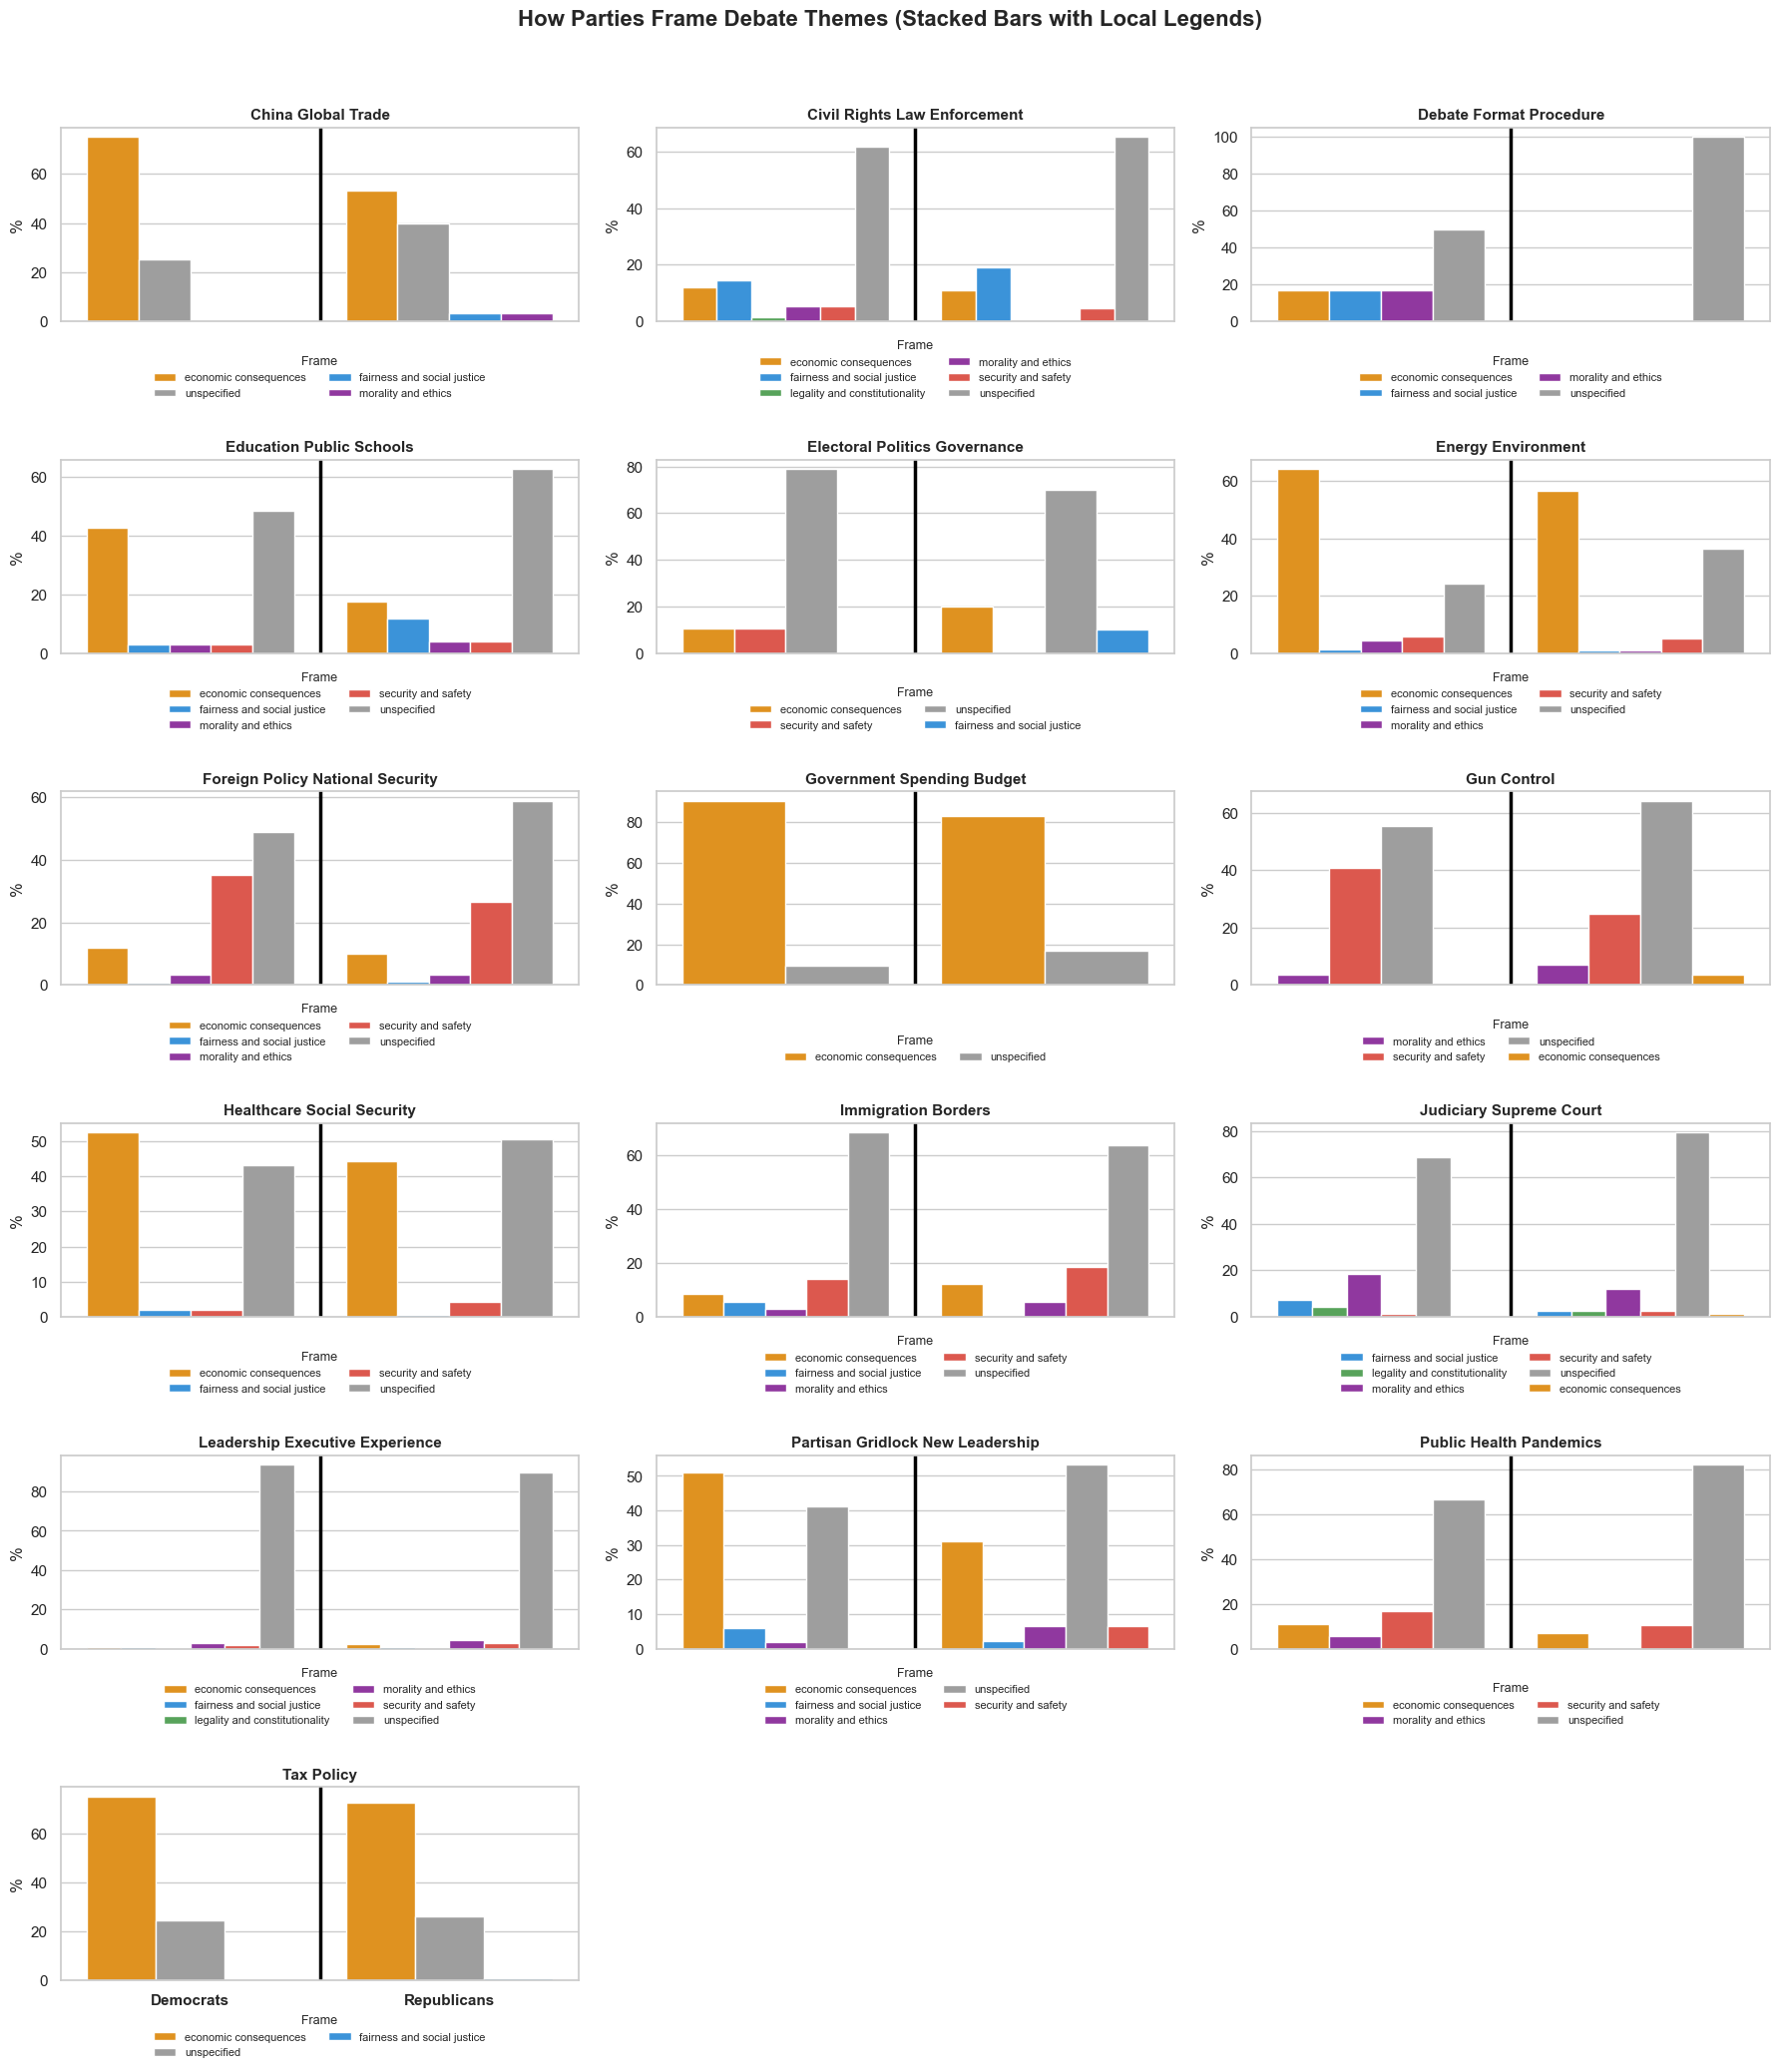

In [348]:
# === THEME × FRAME DISTRIBUTION BY PARTY (3 PER ROW, LEGENDS UNDER, PARTY LABELS, DIVIDER) ===

# prep
df_theme_frame = debates[
    (debates["party_code"].isin(["D", "R"])) &
    debates[FRAME_COL].notna() &
    (debates["theme"] != "noise_or_unspecified")
].copy()

df_theme_frame["party_label"] = df_theme_frame["party_code"].map({"D": "D", "R": "R"})

theme_frame_grouped = (
    df_theme_frame
    .groupby(["theme", "party_label", FRAME_COL])
    .size()
    .reset_index(name="count")
)

totals = theme_frame_grouped.groupby(["theme", "party_label"])["count"].transform("sum")
theme_frame_grouped["pct"] = theme_frame_grouped["count"] / totals * 100

# config
themes = sorted(theme_frame_grouped["theme"].unique())
n_cols = 3
n_rows = (len(themes) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3.6 * n_rows), sharex=True)

for idx, theme in enumerate(themes):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    subset = theme_frame_grouped[theme_frame_grouped["theme"] == theme]

    # barplot
    bars = sns.barplot(
        data=subset,
        x="party_label", y="pct", hue=FRAME_COL,
        palette=frame_palette, ax=ax
    )

    # vertical divider
    ax.axvline(0.5, color="black", linewidth=2.5)

    # set fixed D/R labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Democrats", "Republicans"], fontsize=11, fontweight="bold")

    ax.set_xlabel("")
    ax.set_ylabel("%")
    ax.set_title(theme.replace("_", " ").title(), fontsize=11, fontweight="bold")

    # handle legend
    handles, labels = bars.get_legend_handles_labels()
    ax.legend(
        handles, labels, title="Frame",
        loc="lower center", bbox_to_anchor=(0.5, -0.45),
        ncol=2, fontsize=8, title_fontsize=9,
        frameon=False
    )

# remove unused axes
for j in range(len(themes), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.suptitle("How Parties Frame Debate Themes", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

## 4. Is the Political Center Fading Away?

### 4.1. Is Ideology Prone to Temporal and Partisan Shifts?

/Users/emmamora/anaconda3/envs/thesis-nlp/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning:

The following kwargs were not used by contour: 'linewidth'



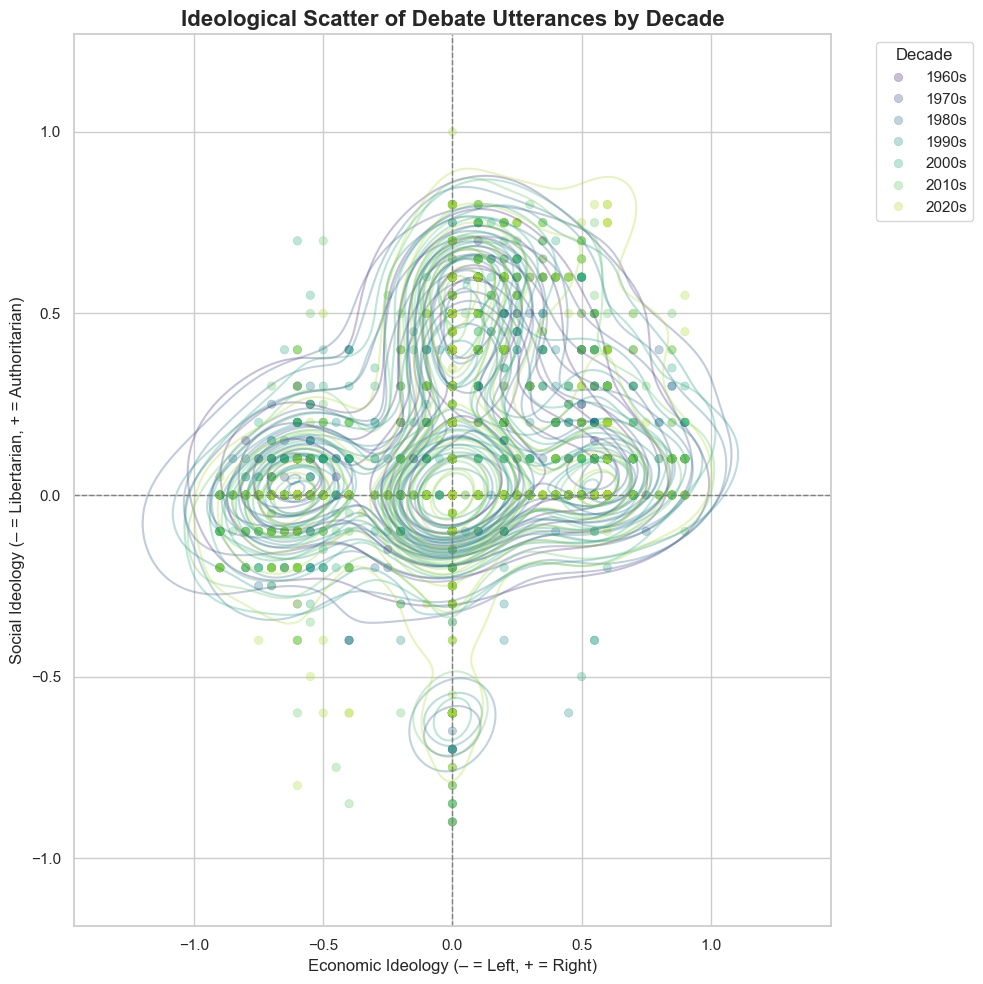

In [262]:
# === SCATTERPLOT: IDEOLOGY (Econ × Soc) WITH DENSITY CONTOURS ===

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=debates,
    x="ideology_econ", y="ideology_soc",
    hue="decade", palette="viridis", alpha=0.3, edgecolor=None
)

sns.kdeplot(
    data=debates,
    x="ideology_econ", y="ideology_soc",
    hue="decade", palette="viridis", alpha=0.3,
    linewidth=1.2, common_norm=False
)

plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.title("Ideological Scatter of Debate Utterances by Decade", fontsize=16, fontweight="bold")
plt.xlabel("Economic Ideology (– = Left, + = Right)")
plt.ylabel("Social Ideology (– = Libertarian, + = Authoritarian)")
plt.legend(title="Decade", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

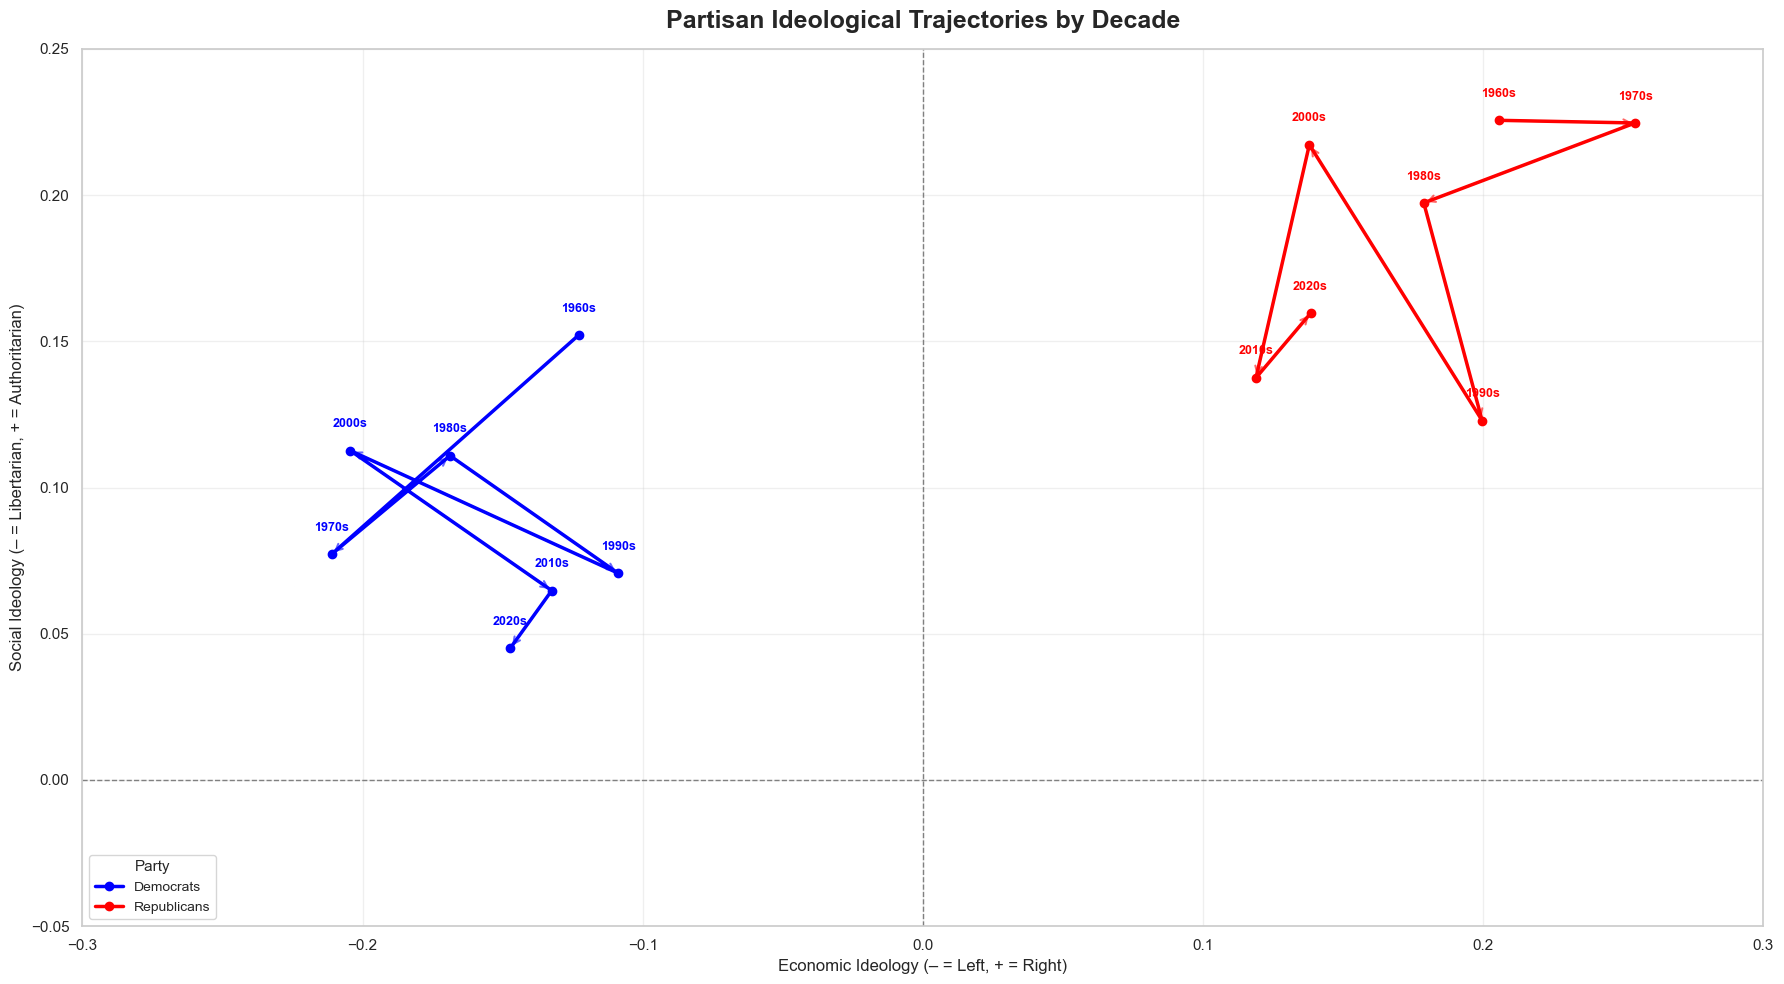

In [282]:
# === PARTISAN IDEOLOGICAL TRAJECTORIES BY DECADE (IMPROVED) ===

from matplotlib.patches import FancyArrowPatch

# group by decade and party
df_centroids = (
    debates[debates["party_code"].isin(["D", "R"])]
    .groupby(["decade", "party_code"])[["ideology_econ", "ideology_soc"]]
    .mean()
    .reset_index()
)

# plot setup
plt.figure(figsize=(18, 10))
ax = plt.gca()

# fixed ideology space
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.05, 0.25)

# centerlines
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)

# party colors
colors = {"D": "blue", "R": "red"}
labels = {"D": "Democrats", "R": "Republicans"}

# trajectory arrows + labels
for party in ["D", "R"]:
    sub = df_centroids[df_centroids["party_code"] == party].sort_values("decade")
    
    # line path
    plt.plot(sub["ideology_econ"], sub["ideology_soc"],
             color=colors[party], linewidth=2.5, marker='o', markersize=6, label=labels[party])
    
    # arrow segments
    for i in range(len(sub) - 1):
        x1, y1 = sub.iloc[i][["ideology_econ", "ideology_soc"]]
        x2, y2 = sub.iloc[i+1][["ideology_econ", "ideology_soc"]]
        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                arrowstyle='->', mutation_scale=12,
                                color=colors[party], alpha=0.6, linewidth=1.5)
        ax.add_patch(arrow)
    
    # add decade labels above points
    for _, row in sub.iterrows():
        plt.text(row["ideology_econ"], row["ideology_soc"] + 0.008,
                 row["decade"], fontsize=9, fontweight="bold",
                 ha="center", color=colors[party])

# styling
plt.title("Partisan Ideological Trajectories by Decade", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Economic Ideology (– = Left, + = Right)", fontsize=12)
plt.ylabel("Social Ideology (– = Libertarian, + = Authoritarian)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Party", fontsize=10, title_fontsize=11, loc="lower left")
plt.tight_layout()
plt.show()

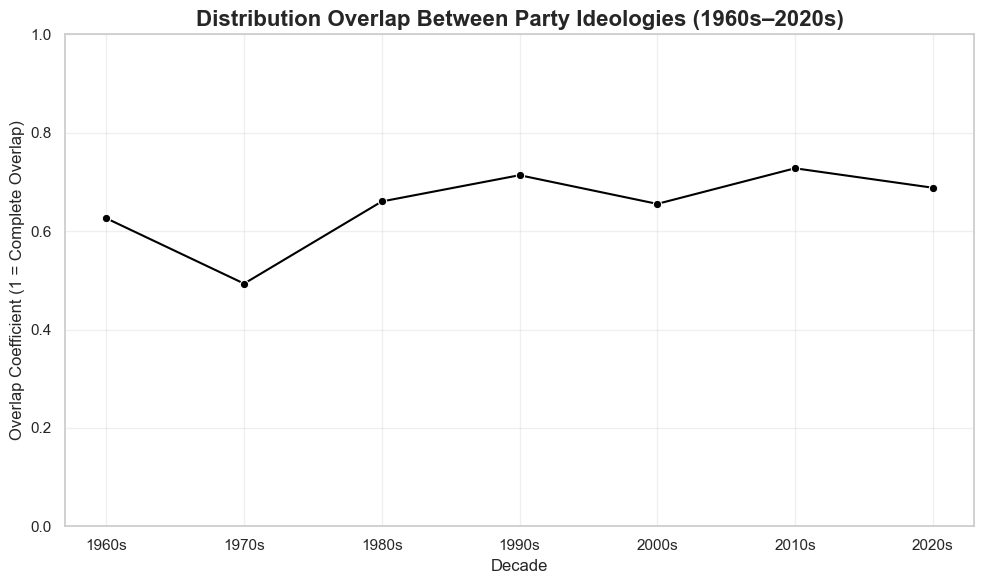

In [283]:
# === OVERLAP COEFFICIENT BETWEEN PARTY IDEOLOGY DISTRIBUTIONS (PER DECADE) ===

from scipy.stats import gaussian_kde
from numpy import linspace, minimum

# restrict to valid decades and major parties
valid_df = debates[
    (debates["party_code"].isin(["D", "R"])) &
    debates["ideology_econ"].notna() &
    debates["ideology_soc"].notna()
].copy()

# compute overlap coefficient per decade (2D KDE overlap)
overlap_scores = []
for decade in sorted(valid_df["decade"].unique()):
    sub = valid_df[valid_df["decade"] == decade]
    d = sub[sub["party_code"] == "D"]
    r = sub[sub["party_code"] == "R"]

    if len(d) < 30 or len(r) < 30:
        continue

    # fit 2D KDEs
    kde_d = gaussian_kde(d[["ideology_econ","ideology_soc"]].T)
    kde_r = gaussian_kde(r[["ideology_econ","ideology_soc"]].T)

    # sample grid
    x = linspace(-1, 1, 100)
    y = linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])

    p_d = kde_d(positions)
    p_r = kde_r(positions)

    # overlap coefficient = sum of minima
    ov = np.sum(minimum(p_d, p_r)) / np.sum(p_d)
    overlap_scores.append({"decade": decade, "overlap": ov})

# to DataFrame
ov_df = pd.DataFrame(overlap_scores)

# plot
plt.figure(figsize=(10,6))
sns.lineplot(data=ov_df, x="decade", y="overlap", marker="o", color="black")

plt.title("Distribution Overlap Between Party Ideologies (1960s–2020s)", fontsize=16, fontweight="bold")
plt.ylabel("Overlap Coefficient (1 = Complete Overlap)")
plt.xlabel("Decade")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 4.2. How Do Recent Candidates Position Themselves?

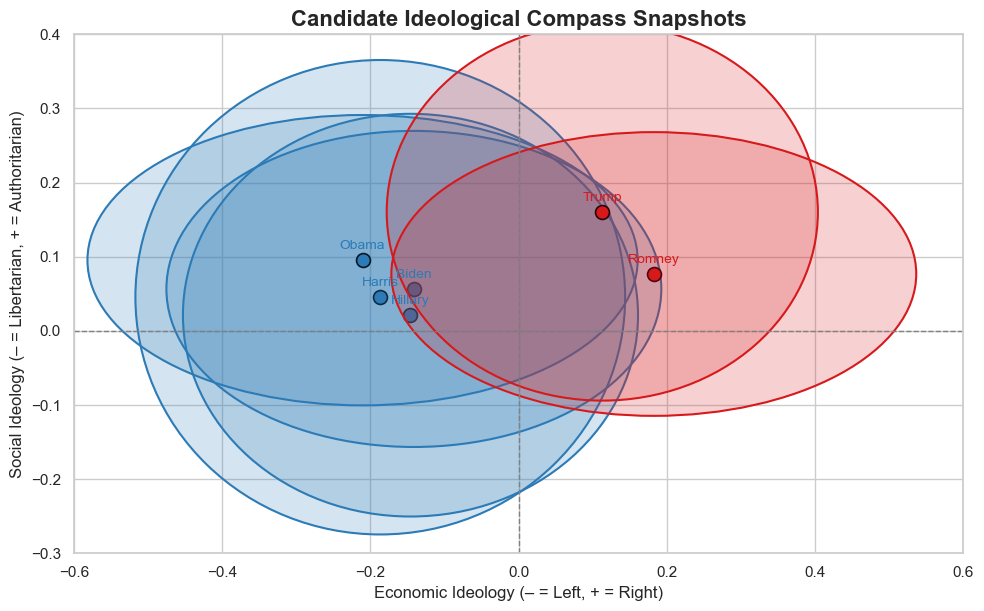

In [287]:
# === CANDIDATE COMPASS SNAPSHOTS (FIGURE 4) ===

from matplotlib.patches import Ellipse
from matplotlib.colors import to_rgba

# list of candidates to highlight
candidates = ["Trump", "Biden", "Harris", "Clinton Hillary", "Obama", "Romney"]

# compute mean ideology per candidate
df_cand = (
    debates[debates["speaker"].isin(candidates)]
    .groupby("speaker")[["ideology_econ", "ideology_soc"]]
    .agg(["mean", "std"])
)
df_cand.columns = ["_".join(col) for col in df_cand.columns]
df_cand = df_cand.reset_index()

# get party color
party_map = debates.set_index("speaker")["party_code"].to_dict()
colors = {"D": "#2C7BB6", "R": "#D7191C"}

# === PLOT ===
fig, ax = plt.subplots(figsize=(10, 10))

# axis lines
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.axvline(0, color="gray", linestyle="--", linewidth=1)

# loop through each candidate
for _, row in df_cand.iterrows():
    name = row["speaker"]
    party = party_map.get(name, "I")
    color = colors.get(party, "gray")

    x, y = row["ideology_econ_mean"], row["ideology_soc_mean"]
    x_std, y_std = row["ideology_econ_std"], row["ideology_soc_std"]

    # plot point
    ax.scatter(x, y, color=color, s=100, label=name, edgecolor="black", linewidth=1.2)

    # ellipse (scaled std dev)
    ellipse = Ellipse(
        (x, y), width=2*x_std, height=2*y_std,
        facecolor=to_rgba(color, alpha=0.2), edgecolor=color, linewidth=1.5
    )
    ax.add_patch(ellipse)

    # safer labeling: show last name if possible, else full name
    label = name.split()[-1] if len(name.split()) >= 2 else name
    ax.text(x, y + 0.015, label, color=color, fontsize=10, ha="center")

# style
ax.set_title("Candidate Ideological Compass Snapshots", fontsize=16, fontweight="bold")
ax.set_xlabel("Economic Ideology (– = Left, + = Right)")
ax.set_ylabel("Social Ideology (– = Libertarian, + = Authoritarian)")
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.3, 0.4)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


## 5. How Have Key Political Terms Shifted Across Time?

### 5.1. Do Anchor Terms Change Meaning Over Time?

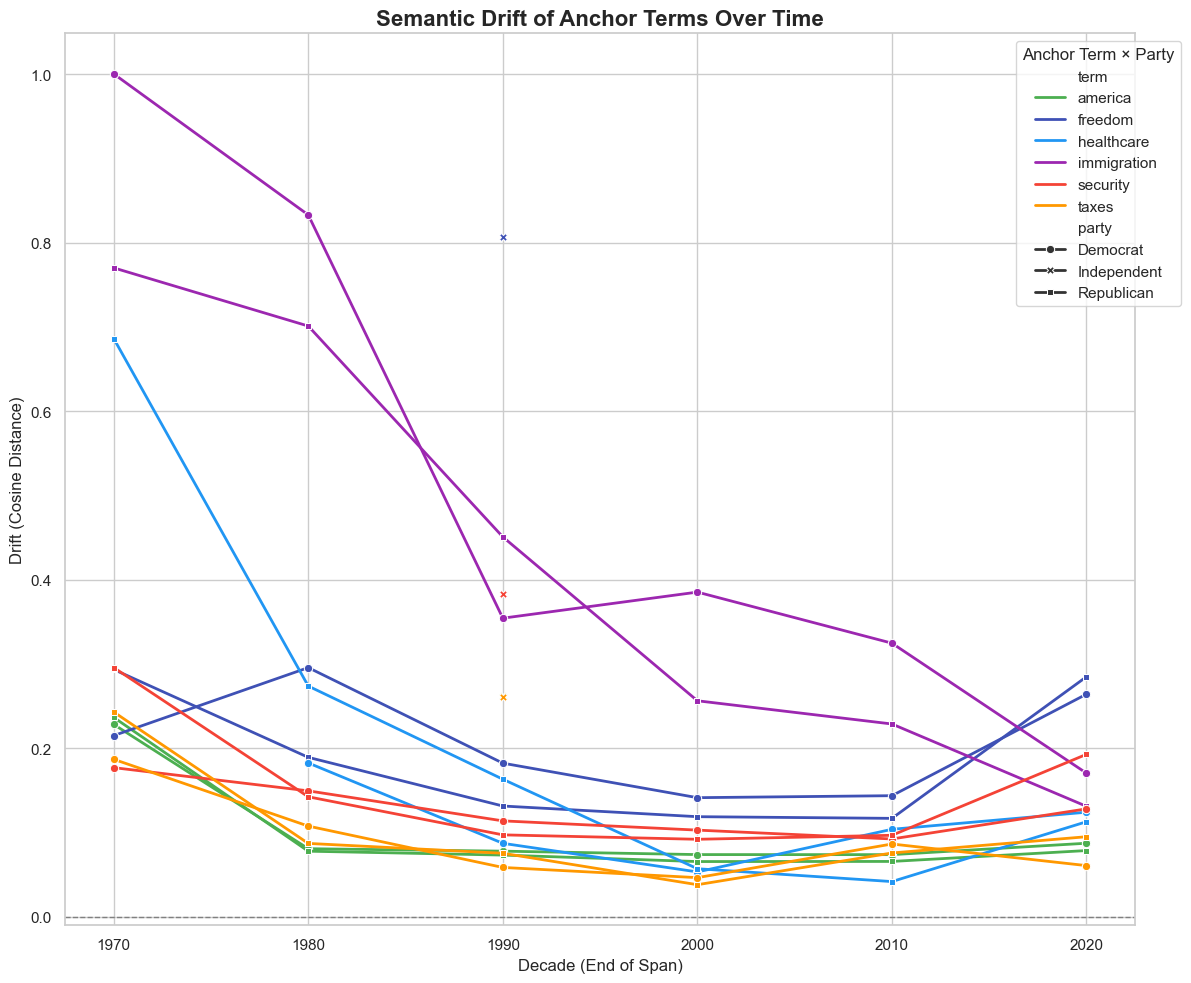

In [299]:
# # === SEMANTIC DRIFT OF ANCHORS OVER TIME ===

import ast

semantic_drift = pd.read_csv(DATA / "ideological_drift" / "semantic_drift.csv")

# parse anchor (from string to tuple)
semantic_drift["anchor"] = semantic_drift["anchor"].apply(ast.literal_eval)
semantic_drift["term"] = semantic_drift["anchor"].apply(lambda x: x[0])
semantic_drift["party"] = semantic_drift["anchor"].apply(lambda x: x[1])

# palette
anchor_palette = {
    "freedom": "#3F51B5",
    "security": "#F44336",
    "america": "#4CAF50",
    "taxes": "#FF9800",
    "immigration": "#9C27B0",
    "healthcare": "#2196F3"
}

# plot
plt.figure(figsize=(12, 10))
sns.lineplot(
    data=semantic_drift,
    x="decade2", y="drift", hue="term", style="party",
    markers=True, dashes=False, linewidth=2, palette=anchor_palette
)

plt.title("Semantic Drift of Anchor Terms Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Decade (End of Span)")
plt.ylabel("Drift (Cosine Distance)")
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.legend(title="Anchor Term × Party", bbox_to_anchor=(1.05, 1), loc="best")
plt.tight_layout()
plt.show()

### 5.2. Do Anchor Terms Mean Different Things for Democrats vs Republicans?

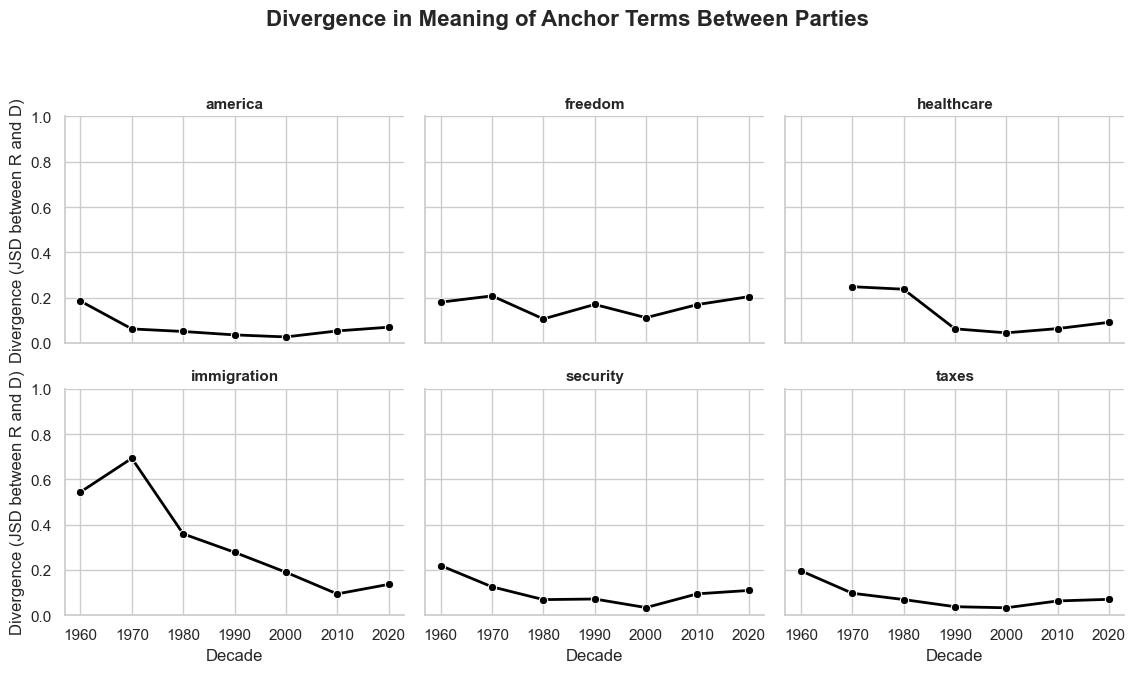

In [302]:
# === PARTY DIVERGENCE IN ANCHOR MEANING OVER TIME ===

# load data
party_div = pd.read_csv(DATA / "ideological_drift" / "party_divergence.csv")

# restrict to valid anchor terms (sorted for consistent layout)
anchor_order = ["america", "freedom", "healthcare", "immigration", "security", "taxes"]
df_div = party_div[party_div["anchor"].isin(anchor_order)].copy()

g = sns.FacetGrid(
    df_div, col="anchor", col_wrap=3,
    col_order=anchor_order,
    height=3.2, aspect=1.2,
    sharey=True
)

g.map_dataframe(
    sns.lineplot, 
    x="decade", y="divergence_RD", 
    marker="o", linewidth=2, color="black"
)

g.set_axis_labels("Decade", "Divergence (JSD between R and D)")
g.set_titles("{col_name}", size=11, fontweight="bold")
g.set(ylim=(0, 1))
g.fig.suptitle("Divergence in Meaning of Anchor Terms Between Parties", fontsize=16, fontweight="bold", y=1.05)
plt.tight_layout()
plt.show()

### 5.3. Do Anchors Align With Themes in Debates and Media?

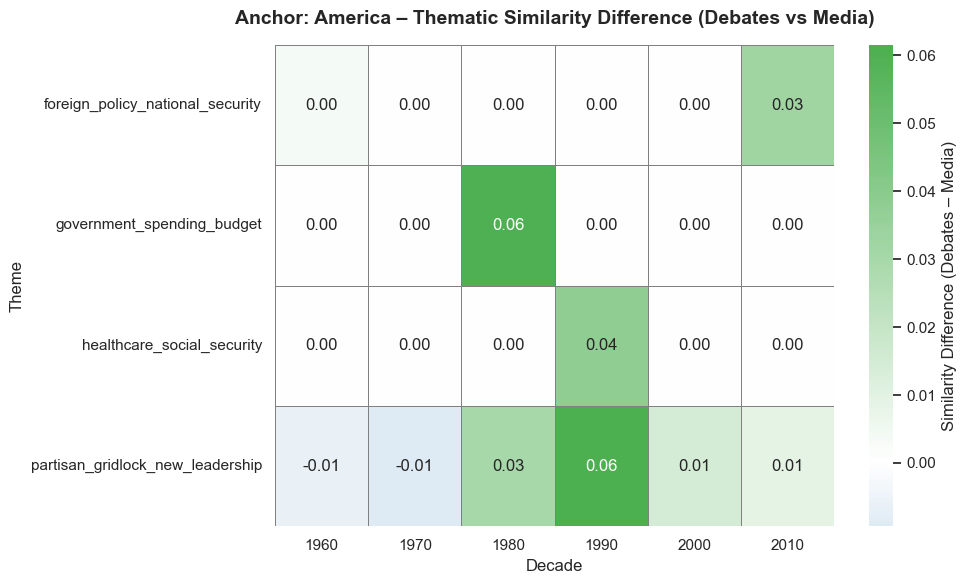

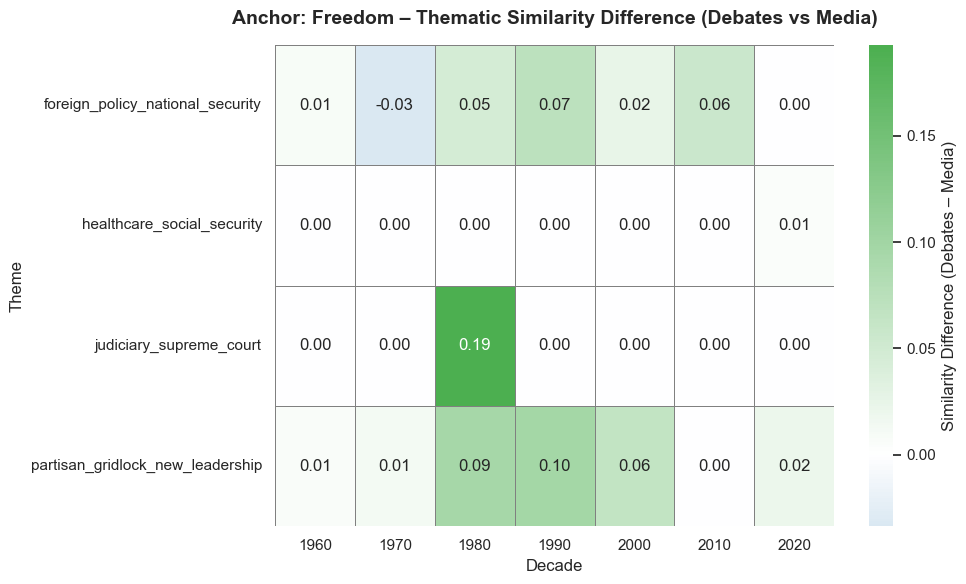

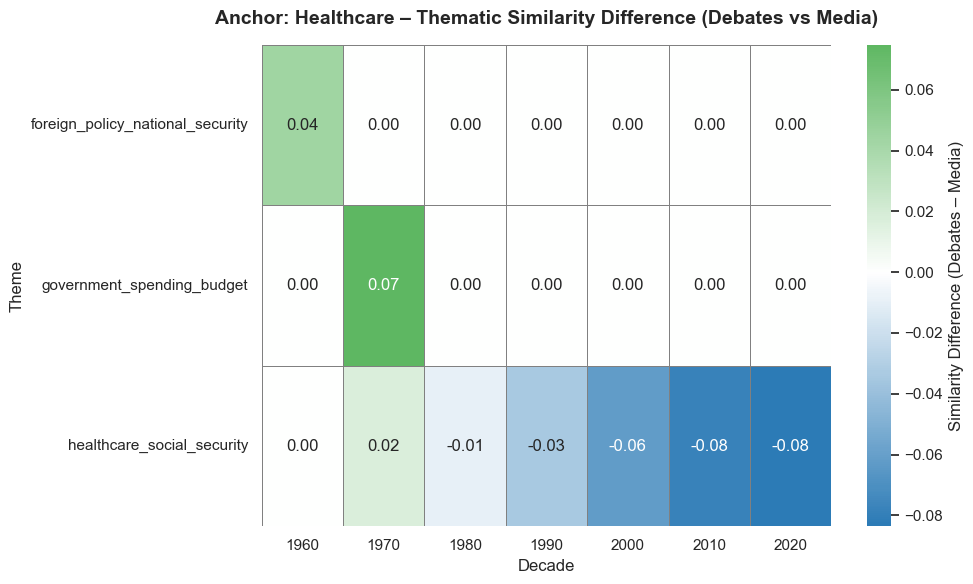

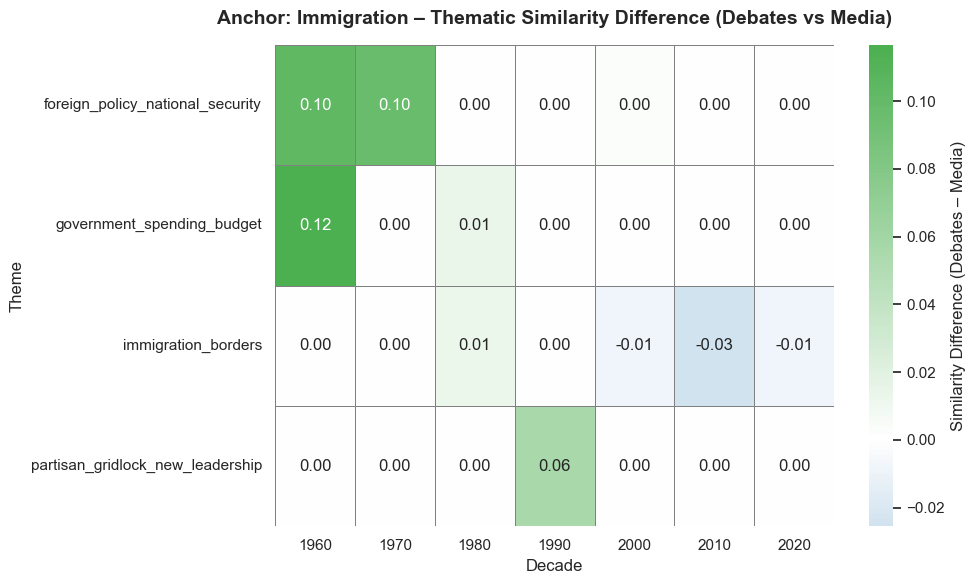

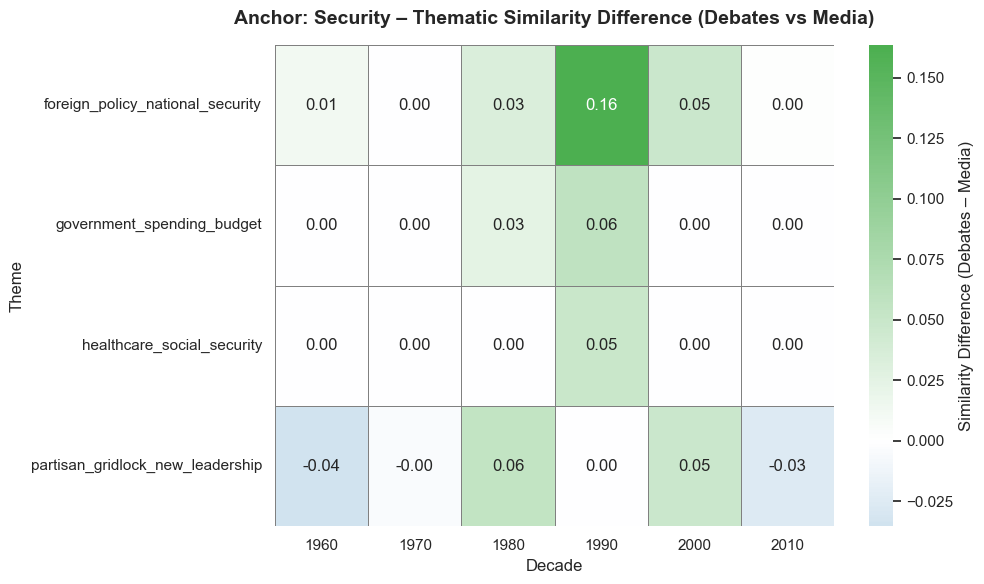

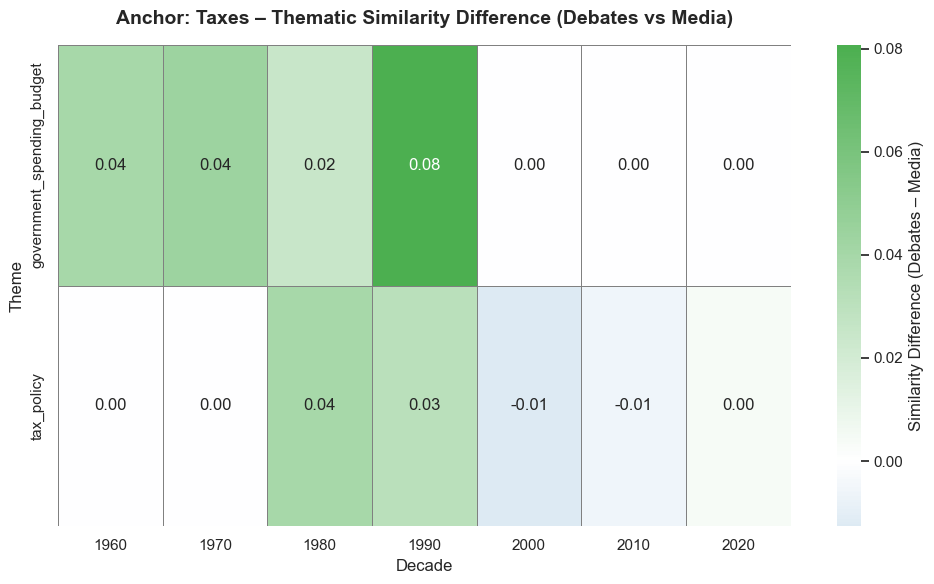

In [312]:
# === ANCHOR → THEME ALIGNMENT DIVERGENCE (DEBATES vs MEDIA) ===

from matplotlib.colors import LinearSegmentedColormap

# load data
alignment = pd.read_csv(Path( DATA/"ideological_drift"/"anchor_theme_alignment.csv"))

# clean
pivot = (
    alignment.pivot_table(
        index=["anchor", "decade", "theme"],
        columns="domain",
        values="similarity"
    )
    .dropna()
    .reset_index()
)
pivot["diff"] = pivot["debates"] - pivot["media"]  # positive = debates

# list of anchors to plot
anchors = pivot["anchor"].unique()

# colors
div_palette = LinearSegmentedColormap.from_list(
    "BlueGreen", ["#2C7BB6", "#ffffff", "#4CAF50"]
)
color_map = {"positive": "#3E4C59", "negative": "#F44336"}

# plot each anchor separately
for anchor in anchors:
    subset = pivot[pivot["anchor"] == anchor]
    heatmap_data = subset.pivot(index="theme", columns="decade", values="diff").fillna(0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        cmap=div_palette,
        center=0,
        linewidths=0.5, linecolor="gray",
        annot=True, fmt=".2f",
        cbar_kws={"label": "Similarity Difference (Debates – Media)"}
    )
    plt.title(
        f"Anchor: {anchor.title()} – Thematic Similarity Difference (Debates vs Media)",
        fontsize=14, fontweight="bold", pad=15
    )
    plt.xlabel("Decade")
    plt.ylabel("Theme")
    plt.tight_layout()
    plt.show()